<h1>
REAL TIME OBJECT DETECTION IN LOW-LIGHT CONDITIONS USING TRANSFER LEARNING
<span class="tocSkip"></span></h1>


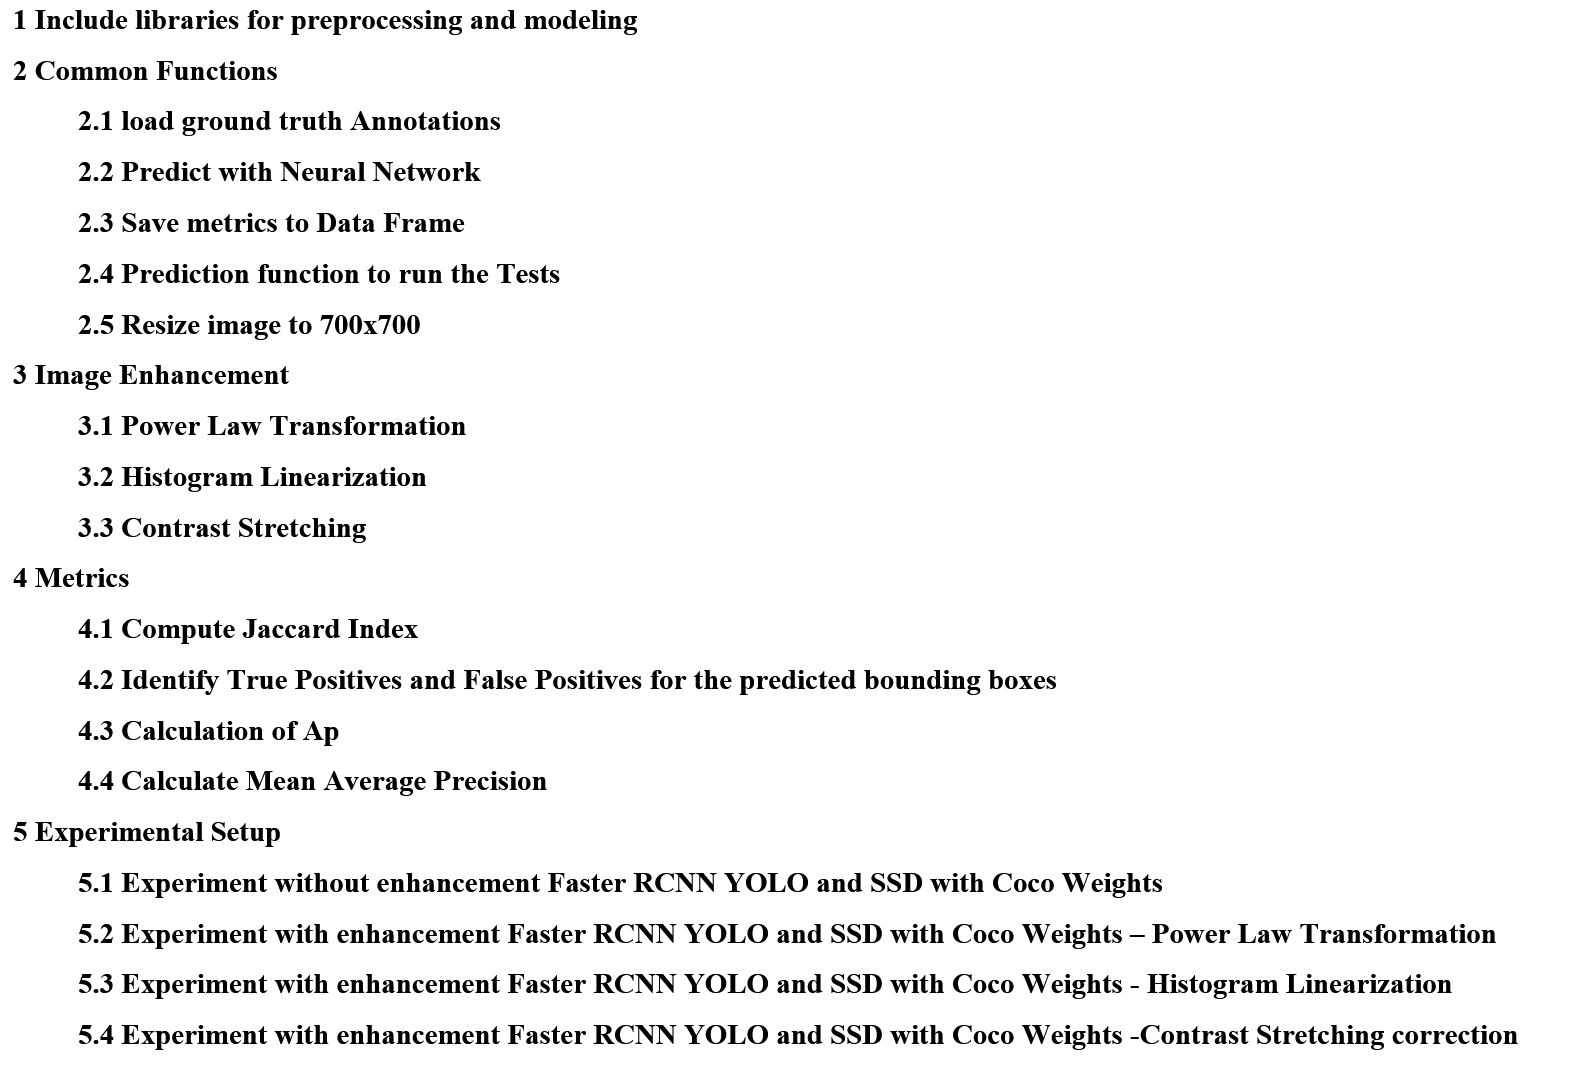

## Include libraries for preprocessing and modeling

In [1]:
from matplotlib import pyplot as plt
import gluoncv
from gluoncv import model_zoo, data, utils
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import glob
from pyodi.core import boxes,utils
import warnings
import timeit
warnings.simplefilter("ignore")
import pandas as pd
#pd.options.display.max_rows = 5000
import glob, os
import cv2

/home/ec2-user/anaconda3/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.9.0+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [2]:
import cv2
import os

os.chdir("/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images")
files= glob.glob("*.jpg")


def resize_image(filePath):
    src = cv2.imread(filePath, cv2.IMREAD_UNCHANGED)
    fileName=os.path.basename(filePath)
    # set a new height in pixels
    new_height = 500
    new_width=500
    # dsize
    dsize = (new_width, new_height)
    # resize image
    output = cv2.resize(src, dsize)
    cv2.imwrite('/mnt/d/Ms/experiment/pretrained/500_500_new/lowlight_500_500_100/images/'+fileName,output) 

## Common Functions

### load ground truth Annotations

In [3]:

gt_annotation = '/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/annotations/instances_default.json'
ground_truth=COCO(gt_annotation)
df2=utils.coco_ground_truth_to_df(gt_annotation, max_images=200000)

2021-12-05 00:31:51.470 | INFO     | pyodi.core.utils:coco_ground_truth_to_df:38 - Loading Ground Truth File
2021-12-05 00:31:51.482 | INFO     | pyodi.core.utils:coco_ground_truth_to_df:48 - Converting COCO Ground Truth to pd.DataFrame


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [4]:
df2

image_id        area   id     category  col_left  row_top   width  \
0           1  17437.6432    1          Car    265.81   351.72  140.99   
1           1   7779.4080    2          Car      0.00   370.98   95.90   
2           1   2366.4576    3          Car    124.83   387.20   64.87   
3           1   3532.1652    4          Car     87.54   378.07   58.84   
4           1   1014.4220    5       person    218.70   376.55   27.80   
..        ...         ...  ...          ...       ...      ...     ...   
518       140   3444.8010  519  street sign    320.00   182.91   39.19   
519       140   1800.1614  520          Car    261.36   201.81   37.34   
520       141  17060.1200  521      bicycle    306.73   280.27  178.64   
521       141  20380.2195  522       person    360.13   130.92  112.01   
522       142   8033.7408  523       person    221.66   215.05   46.32   

     height  iscrowd      img_file_name  img_width  img_height  
0    123.68        0  0058_0.9_0.04.jpg        500         500  
1     81.12        0  0058_0.9_0.04.jpg        500         500  
2     36.48        0  0058_0.9_0.04.jpg        500         500  
3     60.03        0  0058_0.9_0.04.jpg        500         500  
4     36.49        0  0058_0.9_0.04.jpg        500         500  
..      ...      ...                ...        ...         ...  
518   87.90        0      flood_539.jpg        500         500  
519   48.21        0      flood_539.jpg        500         500  
520   95.50        0      flood_549.jpg        500         500  
521  181.95        0      flood_549.jpg        500         500  
522  173.44        0      wf_person.jpg        500         500  

[523 rows x 12 columns]

In [6]:
import seaborn as sns

[Text(0, 0, 'person'),
 Text(1, 0, 'Car'),
 Text(2, 0, 'bus'),
 Text(3, 0, 'airplane'),
 Text(4, 0, 'truck'),
 Text(5, 0, 'bird'),
 Text(6, 0, 'bicycle'),
 Text(7, 0, 'motorcycle'),
 Text(8, 0, 'boat'),
 Text(9, 0, 'street sign'),
 Text(10, 0, 'dog'),
 Text(11, 0, 'horse'),
 Text(12, 0, 'cat'),
 Text(13, 0, 'train')]

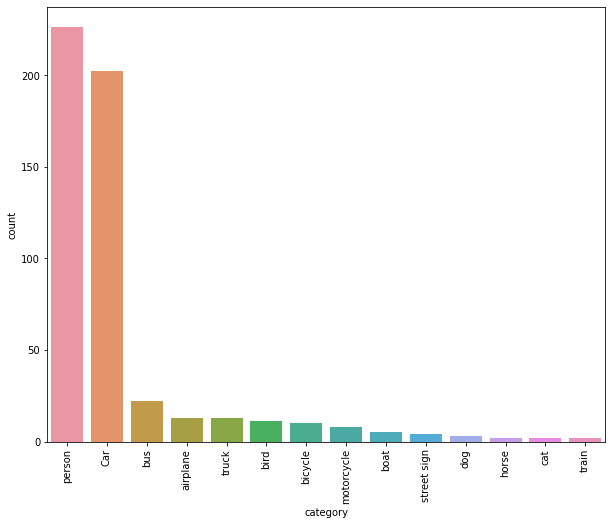

In [7]:
plot=sns.countplot(x = 'category',
              data = df2,
              order = df2['category'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

### Predict with Neural Network

In [8]:
FasterRCNN_model =model_zoo.get_model('faster_rcnn_fpn_resnet50_v1b_coco', pretrained=True,)
YOLO_model= model_zoo.get_model('yolo3_darknet53_coco', pretrained=True)
SSD_model= model_zoo.get_model('ssd_512_resnet50_v1_coco', pretrained=True)

In [9]:
def predict_with_NN(input_dataframe, input_image,nn_type):
    classes=None
    im_fname = input_image
    if(nn_type=="FASTER_RCNN"):
        x, orig_img = data.transforms.presets.rcnn.load_test(im_fname,short=500)

    elif( nn_type=="YOLO"):
        x, orig_img = data.transforms.presets.yolo.load_test(im_fname,short=500)     
    else:
        x, orig_img = data.transforms.presets.ssd.load_test(im_fname,short=500)
    start =None
    box_ids=None
    scores=None
    bboxes=None
    if(nn_type=="FASTER_RCNN"):
        print("In RCNN Detector+++++++++++++++++++++++++")
        start = timeit.default_timer()
        box_ids, scores, bboxes=FasterRCNN_model(x)
        end = timeit.default_timer()
        classes=FasterRCNN_model.classes
        
    elif(nn_type=="YOLO"):
        print("In YOLO Detector")
        start = timeit.default_timer()
        box_ids, scores, bboxes=YOLO_model(x)
        end = timeit.default_timer()
        classes=YOLO_model.classes
    else:
        print("In else+++++++++++++++++++++++++++++++++++++")
        start = timeit.default_timer()
        box_ids, scores, bboxes=SSD_model(x)
        end = timeit.default_timer()
        classes=SSD_model.classes
        
    time_taken =end-start
    print(time_taken)
    print(orig_img.shape)
    #ax = gluoncv.utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=classes)
    #plt.show()
    return orig_img, box_ids,scores, bboxes,classes,time_taken

In [10]:
def Normalize_image_bounding_box(input_frame,input_bbsize_column,image_size):
    image_frame[input_bbsize_column]=image_frame[input_bbsize_column]/image_size
    return image_frame

In [11]:
def extract_prediction_attributes(bounding_box,image_name,image,category_list,scores_list,confidence_threshold,exclude_classes):
    row_count=0
    prediction_data = {
        'image_id': [2],
        'area': [0],
        'id': [1],
        'category':["car"],
        "col_left":[0],
        "row_top":[0],
        "width":[0],
        "height":[0],
        "iscrowd":[0],
        "img_file_name":["test_jpg"],
        "img_width":[100],
        "img_height":[100]

    }
    dataframe_result = pd.DataFrame( columns=df2.columns)
    #dfrow=pd.DataFrame(prediction_data)
    #dataframe_result=dataframe_result.append(dfrow,ignore_index=True)
    dataframe_result
    #print(len(category_list))
    for x in range(0,len(category_list) ):
        if(bounding_box[x,0]!=-1):
            prediction_data["image_id"]=1
            prediction_data["area"]=0
            row_count =row_count+1
            prediction_data["id"]=row_count
            
            #print(bounding_box[x,0],bounding_box[x,1],bounding_box[x,2])
            prediction_data["col_left"]=bounding_box[x,0]
            prediction_data["row_top"]=bounding_box[x,1]
            prediction_data["width"]=bounding_box[x,2]
            prediction_data["height"]=bounding_box[x,3]
            prediction_data["category"]=category_list[x]
            prediction_data["img_file_name"]=image_name
            prediction_data["img_width"]=image.shape[1]
            prediction_data["img_height"]=image.shape[0]
            prediction_data["prob"]=scores_list[x]
            dfrow=pd.DataFrame(prediction_data)
            dataframe_result=dataframe_result.append(dfrow,ignore_index=True)
    dataframe_result=dataframe_result[~dataframe_result.category.str.contains("noclass")]
   # dataframe_result=dataframe_result[~dataframe_result.category.str.contains(exclude_classes)]
    dataframe_result = dataframe_result[dataframe_result['prob'] >confidence_threshold]  
    return dataframe_result

In [12]:
def flatten_array( array_item):
    #print(array_item.asnumpy())
    #print(array_item.asnumpy().flatten())
    return array_item.asnumpy().flatten()
    

In [13]:
def convert_box_ids_to_category_array(array_item, class_map,size):
  #  print(class_map)
  #  print(array_item.size)
    temp_array= ["noclass"]*size
    for i in range (0,size):
#         print(array_item[i])
#         print("mapped value",)
        if array_item[i]!=-1:
            temp_array[i]=class_map[int(array_item[i])]
    return temp_array


In [14]:
def get_formatted_table(table,gt):
    list =[]
    df_new=None
    #print(table)
    for i in range(0, len(table)):
        #print(table.iat[i,5])
        bounding_bbox =[table.iat[i,4],table.iat[i,5],table.iat[i,6], table.iat[i,7]]
        if(gt==False):
            list.append(bounding_bbox)
        else:
            list.append((boxes.coco_to_corners(np.asarray(bounding_bbox))).tolist())
            #print(list)
    df_predicted_annot = pd.DataFrame(list  ,columns=['XMin', 'YMin', 'XMax', 'YMax'])
    table=table.reset_index()
    df_new = pd.concat([table,df_predicted_annot],axis=1)
    df_new["LabelName"]=table["category"]
    df_new["ImageID"]=table["img_file_name"]
    if(gt==False):    
        df_new["Conf"]=table["prob"]
    output_frame =df_new.copy()
    output_frame=output_frame.drop(["image_id","area","category","col_left","row_top","width","height"],axis=1)
    output_frame=output_frame.drop(["iscrowd","img_width","img_height"],axis=1)
    return output_frame

### Save metrics to DataFrame

In [15]:
def save_results(description,class_name,mAPValue,timeTaken,confidenceThreshold,image_name,model,max_conf):
    global result_df
    row_array={}

    row_array["experiment_description"]=description
    row_array["image_name"]=image_name
    row_array["model"]=model
    row_array["className"]=class_name
    row_array["AP"]=mAPValue
    row_array["TimeTaken(s)"]=timeTaken
    row_array["Confidence_Threshold"]=confidenceThreshold
    row_array["max_confidence"]=max_conf
    result_df= result_df.append(row_array,ignore_index=True)

### Prediction function to run the Tests

In [16]:

RCNN_DETECTOR="FASTER_RCNN"
YOLO_DETECTOR="YOLO"
SINGLE_SHOT_DETECTOR="SSD"

def run_test(imageFile,nnType,truth_frame,description):
    
    image_file = imageFile
    original_image, box_ids,scores, bboxes,classes,time_taken=predict_with_NN(truth_frame,image_file,nnType)
    #print(original_image,box_ids,scores,bboxes,classes)
    box_ids=flatten_array(box_ids[0])
    #print(box_ids)
    #print("length of boxids",len(box_ids))
    cat_list=convert_box_ids_to_category_array(box_ids,classes,len(box_ids))
    #Visualize_prediction(original_image, bboxes[0], scores[0], box_ids[0], classes)
#     print(bboxes[0])
#     print(scores[0])
#     print(box_ids[0])
    predicted_frame =extract_prediction_attributes( bboxes[0].asnumpy(),imageFile,original_image, cat_list, flatten_array(scores[0]), 0.5,"person")
    pred_headers= ["col_left","row_top", "width","height","prob","image_id"]
    #print(predicted_frame)
    df_predicted_boxes = predicted_frame[pred_headers]
    df_pred_array= df_predicted_boxes.to_numpy()

    global predicted_result 
    predicted_result= get_formatted_table(predicted_frame,False)
    predicted_result
    predicted_result["XMax"]=predicted_result["XMax"]/500.0
    predicted_result["XMin"]=predicted_result["XMin"]/500.0

    predicted_result["YMax"]=predicted_result["YMax"]/500.0
    predicted_result["YMin"]=predicted_result["YMin"]/500.0
    predicted_result

    gt_frame= truth_frame.copy()
    #gt_frame.rename(columns={"col_left":"XMin","row_top":"YMin" ,"width":"XMax","height":"YMax"} })
    ground_truth= get_formatted_table(gt_frame,True)
    ground_truth
    ground_truth["LabelName"]=ground_truth["LabelName"].str.lower()
    ground_truth

    ground_truth["XMax"]=ground_truth["XMax"]/500.0
    ground_truth["XMin"]=ground_truth["XMin"]/500.0

    ground_truth["YMax"]=ground_truth["YMax"]/500.0
    ground_truth["YMin"]=ground_truth["YMin"]/500.0
    ground_truth
    selected_ann= ground_truth[ground_truth["ImageID"].str.contains(imageFile)]
    print(selected_ann)
    #from map_boxes import mean_average_precision_for_boxes
    ann = selected_ann[['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
    #print(ann)
    predicted_result["ImageID"]=predicted_result["img_file_name"]
    
    det = predicted_result[['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax']]
    #print(det)
    mean_ap, average_precisions = mean_average_precision_for_boxes(ann,det,0.75, True)
    #print(mean_ap)
    for key, value in average_precisions.items():
        print("key is ",key, " value is ",value)
        if(value[0]==0):
            max_conf=0
        else:
          class_dataframe= predicted_result[predicted_result["LabelName"].str.contains(key)]
          max_conf=class_dataframe["Conf"].max()
        #change threshold to 0.75 to run at 0.75 before running run test    
        save_results(description,key,value[0],time_taken,0.5,imageFile,nnType,max_conf)

    result_df

### Resize image to 500x500

In [17]:
for f in files:
    resize_image(f)

## Image Enhancement

### Gama Correction

In [18]:

def correct_gama(factor,image):
    src = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    noisy = img_as_float(src, False)
    invGamma = 1.0 / factor
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    cv2.imwrite('/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/gama_enhanced/'+image,cv2.LUT((noisy * 255).astype(np.uint8), table) )

In [ ]:
from skimage import data, img_as_float, measure

IMG_REF_PATH="/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/"

os.chdir(IMG_REF_PATH)
files= glob.glob("*.jpg")
for f in files:
    correct_gama(1.5,f)


### Histogram Equalization

In [19]:
def Historgram_equalization(image):
    img = cv2.imread(image)

    # convert it to grayscale
    img_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

    # apply histogram equalization 
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    hist_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    cv2.imwrite('/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/Histogram_Equalized/'+image,hist_eq.astype(np.uint8)) 



In [20]:
import cv2
os.chdir ("/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/")
files =glob.glob("*.jpg")
for f in files:
    Historgram_equalization(f)

### Contrast Stretching

In [21]:
def min_max_stretch(img_file ,alpha, beta):
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    # normalize float versions
    #norm_img1 = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    norm_img2 = cv2.normalize(img, None, alpha=alpha, beta=beta, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # scale to uint8
    #norm_img1 = (255*norm_img1).astype(np.uint8)
    #norm_img2 = np.clip(norm_img2, 0, 1)
    norm_img2 = (255*norm_img2).astype(np.uint8)

    # write normalized output images
    cv2.imwrite("/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/min_max_stretch/"+img_file,norm_img2)

In [22]:
os.chdir ("/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125//images/")
files =glob.glob("*.jpg")
for f in files:
    min_max_stretch(f ,0,0.8)

In [23]:
rawimage_path="/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/0773_1_0.2.jpg"
HE_path="/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/min_max_stretch/0773_1_0.2.jpg"
#img_as_float(img, False) 
def show_image(rawimage_path,HE_path,predicted_image):
    raw_img = cv2.imread(rawimage_path, cv2.IMREAD_COLOR)
    he_image= cv2.imread(HE_path, cv2.IMREAD_COLOR)
   # label = 'Raw image'
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5, forward=True)

    a = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(raw_img)
    #a.set_title('Original Image')
    #psnr, ssim_score = get_measurement(img, img)
    #a.set_xlabel(label.format(psnr, ssim_score))

    a = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(he_image)
  

## Metrics
Inspired from https://github.com/ZFTurbo/Mean-Average-Precision-for-Boxes

### Compute IOU

In [24]:
def compute_overlap(boxes, query_boxes):
    """
    Args
        boxes:       (N, 4) ndarray of float
        query_boxes: (4)    ndarray of float
    Returns
        overlaps: (N) ndarray of overlap between boxes and query_boxes
    """
    N = boxes.shape[0]
    overlaps = np.zeros((N), dtype=np.float64)
    box_area = (
        (query_boxes[2] - query_boxes[0]) *
        (query_boxes[3] - query_boxes[1])
    )
    for n in range(N):
        iw = (
            min(boxes[n, 2], query_boxes[2]) -
            max(boxes[n, 0], query_boxes[0])
        )
        if iw > 0:
            ih = (
                min(boxes[n, 3], query_boxes[3]) -
                max(boxes[n, 1], query_boxes[1])
            )
            if ih > 0:
                ua = np.float64(
                    (boxes[n, 2] - boxes[n, 0]) *
                    (boxes[n, 3] - boxes[n, 1]) +
                    box_area - iw * ih
                )
                overlaps[n] = iw * ih / ua
    print(overlaps)            
    return overlaps

### Identify TruePositives and False Positives for the predicted bounding boxes

In [25]:
def cehck_if_true_or_false_positive(annotations, detections, iou_threshold):
    annotations = np.array(annotations, dtype=np.float64)
    scores = []
    false_positives = []
    true_positives = []
    detected_annotations = [] # a GT box should be mapped only one predicted box at most.
    for d in detections:
        scores.append(d[4])
        if len(annotations) == 0:
            false_positives.append(1)
            true_positives.append(0)
            continue
        overlaps = compute_overlap(annotations, d[:4])
        assigned_annotation = np.argmax(overlaps)
        max_overlap = overlaps[assigned_annotation]
        if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
            false_positives.append(0)
            true_positives.append(1)
            detected_annotations.append(assigned_annotation)
        else:
            false_positives.append(1)
            true_positives.append(0)
    #print(scores)
    #print(false_positives)
    #print(true_positives)
    return scores, false_positives, true_positives

### Calculation of Ap

In [26]:
def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [27]:
def get_real_annotations(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i]]
        res[id][label].append(box)

    return res

def get_detections(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    scores = table['Conf'].values.astype(np.float32)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i], scores[i]]
        res[id][label].append(box)
    return res

### Calculate Mean Average Precision

In [28]:
def mean_average_precision_for_boxes(ann, pred, iou_threshold=0.4, exclude_not_in_annotations=False, verbose=True):
    """
    :param ann: path to CSV-file with annotations or numpy array of shape (N, 6)
    :param pred: path to CSV-file with predictions (detections) or numpy array of shape (N, 7)
    :param iou_threshold: IoU between boxes which count as 'match'. Default: 0.5
    :param exclude_not_in_annotations: exclude image IDs which are not exist in annotations. Default: False
    :param verbose: print detailed run info. Default: True
    :return: tuple, where first value is mAP and second values is dict with AP for each class.
    """

    valid = pd.DataFrame(ann, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])
    preds = pd.DataFrame(pred, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])
    ann_unique = valid['ImageID'].unique()
    preds_unique = preds['ImageID'].unique()

    if verbose:
        print('Number of files in annotations: {}'.format(len(ann_unique)))
        print('Number of files in predictions: {}'.format(len(preds_unique)))

    # Exclude files not in annotations!
    if exclude_not_in_annotations:
        preds = preds[preds['ImageID'].isin(ann_unique)]
        preds_unique = preds['ImageID'].unique()
        if verbose:
            print('Number of files in detection after reduction: {}'.format(len(preds_unique)))

    unique_classes = valid['LabelName'].unique().astype(np.str)
    if verbose:
        print('Unique classes: {}'.format(len(unique_classes)))

    all_detections = get_detections(preds)
    print(all_detections)
    all_annotations = get_real_annotations(valid)
    if verbose:
        print('Detections length: {}'.format(len(all_detections)))
        print('Annotations length: {}'.format(len(all_annotations)))

    average_precisions = {}
    for zz, label in enumerate(sorted(unique_classes)):

        # Negative class
        if str(label) == 'nan':
            continue

        false_positives = []
        true_positives = []
        scores = []
        num_annotations = 0.0

        for i in range(len(ann_unique)):
            detections = []
            annotations = []
            id = ann_unique[i]
            if id in all_detections:
                if label in all_detections[id]:
                    detections = all_detections[id][label]
            if id in all_annotations:
                if label in all_annotations[id]:
                    annotations = all_annotations[id][label]

            if len(detections) == 0 and len(annotations) == 0:
                continue
                
            num_annotations += len(annotations)
            
            scr, fp, tp = cehck_if_true_or_false_positive(annotations, detections, iou_threshold)
            scores += scr
            false_positives += fp
            true_positives += tp

        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        false_positives = np.array(false_positives)
        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        print("Recall ",recall)
        print("Precision" ,precision)
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations, precision, recall
        if verbose:
            s1 = "{:30s} | {:.6f} | {:7d}".format(label, average_precision, int(num_annotations))
            print(s1)

    present_classes = 0
    precision = 0
    for label, (average_precision, num_annotations, _, _) in average_precisions.items():
        if num_annotations > 0:
            present_classes += 1
            precision += average_precision
    mean_ap = precision / present_classes
    if verbose:
        print('mAP: {:.6f}'.format(mean_ap))
        #print(average_precisions)
    return mean_ap, average_precisions

## Experimental Setup

### Experiment without enhancement Faster RCNN YOLO and SSD with Coco Weights

In [31]:
IMG_REF_PATH="/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/"
files=None
os.chdir(IMG_REF_PATH)
files= glob.glob("*.jpg")
#print(files)
pd.options.display.max_rows = 999
result_df = pd.DataFrame(columns=["experiment_description","model","image_name","className", "AP","TimeTaken(s)","Confidence_Threshold","max_confidence"])
for f in files:
    print("processing+++ " +f)
   
    run_test(f,YOLO_DETECTOR,df2,"Test with "+YOLO_DETECTOR + " without enhancement")
    run_test(f,SINGLE_SHOT_DETECTOR,df2,"Test with "+SINGLE_SHOT_DETECTOR + " without enhancement")     
    run_test(f,RCNN_DETECTOR,df2,"Test with "+RCNN_DETECTOR + " without enhancement")


processing+++ 0058_0.9_0.04.jpg
In YOLO Detector
0.04278619999968214
(500, 500, 3)
   index  id      img_file_name     XMin     YMin     XMax     YMax LabelName  \
0      0   1  0058_0.9_0.04.jpg  0.53162  0.70344  0.81360  0.95080       car   
1      1   2  0058_0.9_0.04.jpg  0.00000  0.74196  0.19180  0.90420       car   
2      2   3  0058_0.9_0.04.jpg  0.24966  0.77440  0.37940  0.84736       car   
3      3   4  0058_0.9_0.04.jpg  0.17508  0.75614  0.29276  0.87620       car   
4      4   5  0058_0.9_0.04.jpg  0.43740  0.75310  0.49300  0.82608    person   

             ImageID  
0  0058_0.9_0.04.jpg  
1  0058_0.9_0.04.jpg  
2  0058_0.9_0.04.jpg  
3  0058_0.9_0.04.jpg  
4  0058_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0058_0.9_0.04.jpg': {'car': [[0.5509973, 0.7520886, 0.79771006, 0.9350861, 0.99244964], [0.25461072, 0.77451813, 0.35971564, 0.8489999, 0.9748459], [0.15202

   index  id    img_file_name     XMin     YMin     XMax     YMax LabelName  \
5      5   6  0074_1_0.04.jpg  0.39568  0.77868  0.56410  0.86706       car   
6      6   7  0074_1_0.04.jpg  0.36220  0.77150  0.41358  0.84800       car   
7      7   8  0074_1_0.04.jpg  0.25358  0.75956  0.29418  0.84796    person   
8      8   9  0074_1_0.04.jpg  0.12992  0.74940  0.15860  0.81860    person   
9      9  10  0074_1_0.04.jpg  0.20166  0.76964  0.23036  0.82440    person   

           ImageID  
5  0074_1_0.04.jpg  
6  0074_1_0.04.jpg  
7  0074_1_0.04.jpg  
8  0074_1_0.04.jpg  
9  0074_1_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0074_1_0.04.jpg': {'person': [[0.2615673, 0.78147256, 0.28651455, 0.83431345, 0.9127042]], 'car': [[0.40064704, 0.7746634, 0.54644436, 0.8603172, 0.99608433], [0.3668544, 0.7757444, 0.40878257, 0.83882046, 0.8263774], [0.55969816, 0.77604944, 0.597888, 0.8040634,

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
10     10  11  0077_0.8_0.04.jpg  0.51044  0.68840  0.58024  0.76098   
11     11  12  0077_0.8_0.04.jpg  0.33548  0.75846  0.43700  0.83104   
12     12  13  0077_0.8_0.04.jpg  0.37526  0.70212  0.47678  0.77470   
13     13  14  0077_0.8_0.04.jpg  0.39498  0.66344  0.47880  0.71906   
14     14  15  0077_0.8_0.04.jpg  0.43200  0.62960  0.47780  0.68522   
15     15  16  0077_0.8_0.04.jpg  0.34396  0.60778  0.38200  0.66340   
16     16  17  0077_0.8_0.04.jpg  0.27108  0.61622  0.30910  0.65568   
17     17  18  0077_0.8_0.04.jpg  0.29078  0.60390  0.32882  0.62714   
18     18  19  0077_0.8_0.04.jpg  0.62840  0.64930  0.84620  0.90980   
19     19  20  0077_0.8_0.04.jpg  0.57424  0.58274  0.64904  0.66440   
20     20  21  0077_0.8_0.04.jpg  0.60180  0.64920  0.64756  0.70280   
21     21  22  0077_0.8_0.04.jpg  0.14730  0.59892  0.24970  0.67432   
22     22  23  0077_0.8_0.04.jpg  0.78624  0.70142  0.85604  0.7

    index  id       img_file_name     XMin    YMin     XMax     YMax  \
25     25  26  0215_0.85_0.04.jpg  0.62676  0.7018  0.77178  0.78902   
26     26  27  0215_0.85_0.04.jpg  0.78500  0.6288  0.95636  0.72108   
27     27  28  0215_0.85_0.04.jpg  0.63080  0.6400  0.72818  0.69774   
28     28  29  0215_0.85_0.04.jpg  0.59690  0.6070  0.66980  0.65360   

     LabelName             ImageID  
25  motorcycle  0215_0.85_0.04.jpg  
26         car  0215_0.85_0.04.jpg  
27      person  0215_0.85_0.04.jpg  
28         car  0215_0.85_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'0215_0.85_0.04.jpg': {'car': [[0.78627765, 0.6321566, 0.9573427, 0.7076472, 0.9983575], [0.5973389, 0.6136839, 0.67295927, 0.65103793, 0.83988285]], 'motorcycle': [[0.63701254, 0.6657868, 0.7388288, 0.7721105, 0.8154619]], 'bus': [[0.38859716, 0.5933351, 0.59560746, 0.6637102, 0.9244376]]}}
Detections length: 1
Annot

    index  id       img_file_name     XMin     YMin     XMax     YMax  \
35     35  36  0261_0.85_0.06.jpg  0.33180  0.56320  0.41180  0.64580   
36     36  37  0261_0.85_0.06.jpg  0.39248  0.56692  0.50302  0.67340   
37     37  38  0261_0.85_0.06.jpg  0.01260  0.82820  1.00000  1.00000   
38     38  39  0261_0.85_0.06.jpg  0.00762  0.54716  0.21036  0.65364   

   LabelName             ImageID  
35       car  0261_0.85_0.06.jpg  
36       car  0261_0.85_0.06.jpg  
37       car  0261_0.85_0.06.jpg  
38       car  0261_0.85_0.06.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'0261_0.85_0.06.jpg': {'car': [[0.025274742, 0.5648768, 0.21210587, 0.64431095, 0.85524714], [0.40322858, 0.5797077, 0.48836243, 0.66625166, 0.8366612], [0.49556202, 0.5919636, 0.516542, 0.61062557, 0.7272703], [0.33668384, 0.5742065, 0.39544988, 0.621211, 0.5569573]]}}
Detections length: 1
Annotations length: 1
[0.       

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
42     42  43  0446_0.9_0.04.jpg  0.00400  0.73482  0.05380  1.00000   
43     43  44  0446_0.9_0.04.jpg  0.29106  0.74238  0.34480  0.79816   
44     44  45  0446_0.9_0.04.jpg  0.38692  0.73986  0.42040  0.79564   
45     45  46  0446_0.9_0.04.jpg  0.86562  0.75000  1.00000  0.82100   
46     46  47  0446_0.9_0.04.jpg  0.20380  0.70944  0.24646  0.84020   
47     47  48  0446_0.9_0.04.jpg  0.16124  0.79308  0.23224  0.99490   
48     48  49  0446_0.9_0.04.jpg  0.07800  0.73888  0.15320  0.98520   

   LabelName            ImageID  
42    person  0446_0.9_0.04.jpg  
43       car  0446_0.9_0.04.jpg  
44       car  0446_0.9_0.04.jpg  
45       car  0446_0.9_0.04.jpg  
46    person  0446_0.9_0.04.jpg  
47    person  0446_0.9_0.04.jpg  
48    person  0446_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0446_0.9_0.04.j

    index  id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
49     49  50  0446_1_0.2.jpg  0.00000  0.70542  0.06440  1.00000    person   
50     50  51  0446_1_0.2.jpg  0.85704  0.75262  1.00000  0.84280       car   
51     51  52  0446_1_0.2.jpg  0.38588  0.74898  0.42540  0.79358       car   
52     52  53  0446_1_0.2.jpg  0.28700  0.75252  0.34582  0.80320       car   
53     53  54  0446_1_0.2.jpg  0.15920  0.78192  0.22512  0.99592    person   
54     54  55  0446_1_0.2.jpg  0.07556  0.75204  0.14148  0.99840    person   

           ImageID  
49  0446_1_0.2.jpg  
50  0446_1_0.2.jpg  
51  0446_1_0.2.jpg  
52  0446_1_0.2.jpg  
53  0446_1_0.2.jpg  
54  0446_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0446_1_0.2.jpg': {'person': [[0.1596369, 0.7803606, 0.22446159, 0.9964313, 0.97359824], [0.06957914, 0.75536436, 0.16041711, 0.9932041, 0.84017307], [0.36961278, 0

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
62     62  63  0676_0.9_0.16.jpg  0.08416  0.51114  0.13488  0.64704   
63     63  64  0676_0.9_0.16.jpg  0.47314  0.49038  0.52800  0.61920   
64     64  65  0676_0.9_0.16.jpg  0.39652  0.48124  0.44728  0.61000   
65     65  66  0676_0.9_0.16.jpg  0.29714  0.48882  0.36914  0.57504   
66     66  67  0676_0.9_0.16.jpg  0.21452  0.51370  0.29460  0.59992   
67     67  68  0676_0.9_0.16.jpg  0.03702  0.49950  0.12520  0.57360   

   LabelName            ImageID  
62    person  0676_0.9_0.16.jpg  
63    person  0676_0.9_0.16.jpg  
64    person  0676_0.9_0.16.jpg  
65       car  0676_0.9_0.16.jpg  
66       car  0676_0.9_0.16.jpg  
67       car  0676_0.9_0.16.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0676_0.9_0.16.jpg': {'car': [[0.29699287, 0.5076922, 0.3626671, 0.57023054, 0.97243637], [0.21227808, 0.512548, 0.2929765

    index  id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
68     68  69  0773_1_0.2.jpg  0.74140  0.35300  0.80120  0.48780    person   
69     69  70  0773_1_0.2.jpg  0.00000  0.41378  0.12380  0.49288       car   
70     70  71  0773_1_0.2.jpg  0.14000  0.40670  0.24342  0.48582       car   
71     71  72  0773_1_0.2.jpg  0.30820  0.19060  0.55982  1.00000    person   
72     72  73  0773_1_0.2.jpg  0.71398  0.43710  0.82460  0.50810   bicycle   
73     73  74  0773_1_0.2.jpg  0.17442  0.38732  0.65820  0.61560       car   

           ImageID  
68  0773_1_0.2.jpg  
69  0773_1_0.2.jpg  
70  0773_1_0.2.jpg  
71  0773_1_0.2.jpg  
72  0773_1_0.2.jpg  
73  0773_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'0773_1_0.2.jpg': {'person': [[0.32706743, 0.18415064, 0.5428043, 0.96432155, 0.9996686], [0.73787117, 0.3615655, 0.79200214, 0.48061243, 0.73831695]], 'bicycle': [

    index  id img_file_name     XMin     YMin    XMax    YMax LabelName  \
79     79  80      1005.jpg  0.36298  0.35638  0.6068  0.5142  airplane   

     ImageID  
79  1005.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
airplane                       | 0.000000 |       1
mAP: 0.000000
key is  airplane  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In RCNN Detector+++++++++++++++++++++++++
0.028560300001117866
(500, 500, 3)
    index  id img_file_name     XMin     YMin    XMax    YMax LabelName  \
79     79  80      1005.jpg  0.36298  0.35638  0.6068  0.5142  airplane   

     ImageID  
79  1005.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision

    index  id img_file_name     XMin     YMin     XMax     YMax LabelName  \
85     85  86      1066.jpg  0.65782  0.66284  0.70332  0.90242    person   
86     86  87      1066.jpg  0.70414  0.66378  0.75902  0.90336    person   
87     87  88      1066.jpg  0.55384  0.65904  0.60874  0.89862    person   
88     88  89      1066.jpg  0.22594  0.67868  0.31384  0.92348    person   
89     89  90      1066.jpg  0.31378  0.68670  0.36868  0.92628    person   
90     90  91      1066.jpg  0.42436  0.67040  0.47924  0.90996    person   
91     91  92      1066.jpg  0.49902  0.66190  0.55392  0.90146    person   
92     92  93      1066.jpg  0.77974  0.68746  0.83464  0.88726    person   

     ImageID  
85  1066.jpg  
86  1066.jpg  
87  1066.jpg  
88  1066.jpg  
89  1066.jpg  
90  1066.jpg  
91  1066.jpg  
92  1066.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'1066.jpg': {'person': [[0.22201598,

     index   id img_file_name     XMin     YMin    XMax     YMax LabelName  \
102    102  103       130.jpg  0.15126  0.55014  0.3025  0.99342    person   

     ImageID  
102  130.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'130.jpg': {'person': [[0.177935, 0.58813596, 0.26510426, 0.97298646, 0.973495]]}}
Detections length: 1
Annotations length: 1
[0.50039229]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([0.]), array([0.]))
In else+++++++++++++++++++++++++++++++++++++
0.027464599996164907
(500, 500, 3)
     index   id img_file_name     XMin     YMin    XMax     YMax LabelName  \
102    102  103       130.jpg  0.15126  0.55014  0.3025  0.99342    person   

     ImageID  
102  130.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1

     index   id img_file_name     XMin     YMin     XMax  YMax LabelName  \
108    108  109       199.jpg  0.60820  0.64842  0.74532   1.0    person   
109    109  110       199.jpg  0.44428  0.66166  0.58140   1.0    person   

     ImageID  
108  199.jpg  
109  199.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'199.jpg': {'person': [[0.61637956, 0.640111, 0.7617674, 1.0018204, 0.97022295], [0.44172063, 0.65324295, 0.57604724, 0.99060386, 0.9582719]]}}
Detections length: 1
Annotations length: 1
[0.81734033 0.        ]
[0.         0.89617289]
Recall  [0.5 1. ]
Precision [1. 1.]
person                         | 1.000000 |       2
mAP: 1.000000
key is  person  value is  (1.0, 2.0, array([1., 1.]), array([0.5, 1. ]))
In else+++++++++++++++++++++++++++++++++++++
0.01901959999668179
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax  YMax LabelName  \
108    108  109       199.

     index   id    img_file_name  XMin     YMin     XMax    YMax LabelName  \
113    113  114  2008_000815.jpg   0.0  0.00192  0.28264  0.9301    person   

             ImageID  
113  2008_000815.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_000815.jpg': {'person': [[0.0043661576, 0.013630523, 0.25953016, 0.9227523, 0.98761344]]}}
Detections length: 1
Annotations length: 1
[0.88425111]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In RCNN Detector+++++++++++++++++++++++++
0.03167589999793563
(500, 500, 3)
     index   id    img_file_name  XMin     YMin     XMax    YMax LabelName  \
113    113  114  2008_000815.jpg   0.0  0.00192  0.28264  0.9301    person   

             ImageID  
113  2008_000815.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Numbe

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
117    117  118  2008_000952.jpg  0.00000  0.55438  0.16064  1.00000   
118    118  119  2008_000952.jpg  0.76140  0.31764  0.99906  0.54080   
119    119  120  2008_000952.jpg  0.71458  0.64860  0.99900  1.00000   
120    120  121  2008_000952.jpg  0.00334  0.34364  0.18284  0.56384   
121    121  122  2008_000952.jpg  0.18340  0.34314  0.41876  0.60306   
122    122  123  2008_000952.jpg  0.52080  0.32942  0.72020  0.56660   

    LabelName          ImageID  
117       car  2008_000952.jpg  
118       car  2008_000952.jpg  
119       car  2008_000952.jpg  
120       car  2008_000952.jpg  
121       car  2008_000952.jpg  
122       car  2008_000952.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_000952.jpg': {'car': [[0.77054876, 0.3415126, 1.0031856, 0.5519838, 0.9841589], [0.5300097, 0.36523175, 0.71703666, 0.56184

     index   id    img_file_name     XMin     YMin    XMax    YMax LabelName  \
126    126  127  2008_001035.jpg  0.27500  0.41402  0.3574  0.6796    person   
127    127  128  2008_001035.jpg  0.21212  0.53640  0.2708  0.7764    person   

             ImageID  
126  2008_001035.jpg  
127  2008_001035.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_001035.jpg': {'person': [[0.21602277, 0.54837745, 0.26762477, 0.7680465, 0.7489692], [0.27393728, 0.41745862, 0.35169345, 0.67509043, 0.7051925]]}}
Detections length: 1
Annotations length: 1
[0.         0.80488524]
[0.89173412 0.        ]
Recall  [0.5 1. ]
Precision [1. 1.]
person                         | 1.000000 |       2
mAP: 1.000000
key is  person  value is  (1.0, 2.0, array([1., 1.]), array([0.5, 1. ]))
In RCNN Detector+++++++++++++++++++++++++
0.031001800001831725
(500, 500, 3)
     index   id    img_file_name     XMin     YMin    XMax

     index   id    img_file_name     XMin     YMin     XMax    YMax LabelName  \
131    131  132  2008_001235.jpg  0.00004  0.14748  0.20704  0.9868    person   
132    132  133  2008_001235.jpg  0.23822  0.09168  1.00000  0.8884     horse   
133    133  134  2008_001235.jpg  0.82620  0.25900  0.88960  0.3370     horse   
134    134  135  2008_001235.jpg  0.60916  0.21170  0.70080  0.2901    person   

             ImageID  
131  2008_001235.jpg  
132  2008_001235.jpg  
133  2008_001235.jpg  
134  2008_001235.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_001235.jpg': {'person': [[0.018779235, 0.1831994, 0.1574037, 0.9412916, 0.998002], [0.64085174, 0.21918918, 0.67563874, 0.27519172, 0.87776554], [0.5990153, 0.2133103, 0.63727385, 0.27460796, 0.68176174], [0.6001455, 0.21088156, 0.6389202, 0.32766122, 0.5246367]], 'horse': [[0.26371473, 0.0883869, 0.96020216, 0.8819588, 0.99855214]]}}
D

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
140    140  141  2008_001566.jpg  0.05670  0.28502  0.36748  0.61054   
141    141  142  2008_001566.jpg  0.00152  0.58094  0.32640  0.89780   
142    142  143  2008_001566.jpg  0.03400  0.33040  0.20642  0.81480   

    LabelName          ImageID  
140       car  2008_001566.jpg  
141   bicycle  2008_001566.jpg  
142    person  2008_001566.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'2008_001566.jpg': {'bicycle': [[-0.006422882, 0.5703642, 0.3009906, 0.8959576, 0.9983902]], 'person': [[0.034474198, 0.35199493, 0.21845908, 0.82570577, 0.9773501]]}}
Detections length: 1
Annotations length: 1
[0.86792118]
Recall  [1.]
Precision [1.]
bicycle                        | 1.000000 |       1
Recall  []
Precision []
car                            | 0.000000 |       1
[0.87353141]
Recall  [1.]
Precision [1.]
person                 

     index   id    img_file_name     XMin     YMin    XMax  YMax LabelName  \
149    149  150  2008_002296.jpg  0.04446  0.31006  0.6088   1.0    person   

             ImageID  
149  2008_002296.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
person                         | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In else+++++++++++++++++++++++++++++++++++++
0.019775600005232263
(500, 500, 3)
     index   id    img_file_name     XMin     YMin    XMax  YMax LabelName  \
149    149  150  2008_002296.jpg  0.04446  0.31006  0.6088   1.0    person   

             ImageID  
149  2008_002296.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_002296.jpg': {

     index   id    img_file_name    XMin    YMin    XMax     YMax LabelName  \
154    154  155  2008_002461.jpg  0.3715  0.2912  0.6333  0.63992       car   

             ImageID  
154  2008_002461.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_002461.jpg': {'car': [[0.402556, 0.34254682, 0.6161535, 0.6225975, 0.96125776]]}}
Detections length: 1
Annotations length: 1
[0.65521867]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
In RCNN Detector+++++++++++++++++++++++++
0.030063400001381524
(500, 500, 3)
     index   id    img_file_name    XMin    YMin    XMax     YMax LabelName  \
154    154  155  2008_002461.jpg  0.3715  0.2912  0.6333  0.63992       car   

             ImageID  
154  2008_002461.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of fi

     index   id    img_file_name     XMin     YMin     XMax    YMax LabelName  \
160    160  161  2008_003478.jpg  0.54442  0.14654  0.62000  0.4188    person   
161    161  162  2008_003478.jpg  0.59640  0.13516  0.69848  0.4764    person   
162    162  163  2008_003478.jpg  0.16226  0.35488  0.59434  0.5822  airplane   
163    163  164  2008_003478.jpg  0.00000  0.18760  0.38744  0.3824  airplane   
164    164  165  2008_003478.jpg  0.48072  0.54660  0.91280  0.7010  airplane   

             ImageID  
160  2008_003478.jpg  
161  2008_003478.jpg  
162  2008_003478.jpg  
163  2008_003478.jpg  
164  2008_003478.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_003478.jpg': {'person': [[0.59945726, 0.15224811, 0.7038784, 0.46248674, 0.99735475], [0.54467356, 0.15241857, 0.61627746, 0.41691875, 0.98859584]], 'airplane': [[0.0076939696, 0.121342264, 0.44759843, 0.31040525, 0.97193825], [0.1960

     index   id    img_file_name     XMin    YMin    XMax     YMax LabelName  \
166    166  167  2008_003613.jpg  0.20986  0.4216  0.5454  0.90646    person   

             ImageID  
166  2008_003613.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_003613.jpg': {'person': [[0.23627603, 0.44380546, 0.42466745, 0.89955044, 0.9308565]]}}
Detections length: 1
Annotations length: 1
[0.52774282]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([0.]), array([0.]))
processing+++ 2008_003780.jpg
In YOLO Detector
0.045027300002402626
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     YMax  \
167    167  168  2008_003780.jpg  0.57944  0.27742  0.70224  0.74340   
168    168  169  2008_003780.jpg  0.47642  0.21882  0.59922  0.68480   
169    169  170  2008_003780.jpg  0.43300  0.17818  0

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
173    173  174  2008_003844.jpg  0.65538  0.35818  0.74352  0.45658   
174    174  175  2008_003844.jpg  0.85680  0.29252  1.00000  0.58000   
175    175  176  2008_003844.jpg  0.54540  0.34504  0.67584  0.57754   
176    176  177  2008_003844.jpg  0.03134  0.22582  0.31256  0.56246   
177    177  178  2008_003844.jpg  0.00306  0.36578  0.07180  0.45850   
178    178  179  2008_003844.jpg  0.22498  0.32140  0.56440  0.48120   
179    179  180  2008_003844.jpg  0.24768  0.41314  0.53406  0.91970   

      LabelName          ImageID  
173         car  2008_003844.jpg  
174         car  2008_003844.jpg  
175  motorcycle  2008_003844.jpg  
176         car  2008_003844.jpg  
177         car  2008_003844.jpg  
178         car  2008_003844.jpg  
179      person  2008_003844.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'2008_00

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
180    180  181  2008_003925.jpg  0.64130  0.47970  0.69516  0.88702   
181    181  182  2008_003925.jpg  0.21976  0.49340  0.27640  0.55760   
182    182  183  2008_003925.jpg  0.14088  0.48870  0.24390  0.62292   
183    183  184  2008_003925.jpg  0.21788  0.46506  0.29342  0.52564   
184    184  185  2008_003925.jpg  0.31524  0.47360  0.37186  0.52160   
185    185  186  2008_003925.jpg  0.26848  0.46080  0.31280  0.50600   
186    186  187  2008_003925.jpg  0.76468  0.37244  0.86960  0.59078   
187    187  188  2008_003925.jpg  0.72922  0.42584  0.78308  0.83316   
188    188  189  2008_003925.jpg  0.57044  0.46270  0.62428  0.87002   
189    189  190  2008_003925.jpg  0.48914  0.45608  0.55900  0.91540   
190    190  191  2008_003925.jpg  0.44000  0.46174  0.49384  0.86906   
191    191  192  2008_003925.jpg  0.61100  0.40136  0.65360  0.46840   

    LabelName          ImageID  
180    person  2008_003925.jpg

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
195    195  196  2008_004182.jpg  0.53692  0.31572  0.70042  0.84598   
196    196  197  2008_004182.jpg  0.71600  0.33322  0.78588  0.63002   
197    197  198  2008_004182.jpg  0.64938  0.30340  0.71926  0.62000   

    LabelName          ImageID  
195    person  2008_004182.jpg  
196    person  2008_004182.jpg  
197    person  2008_004182.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004182.jpg': {'person': [[0.6505662, 0.30080146, 0.7266098, 0.61051714, 0.98182946], [0.57561433, 0.32614416, 0.66321224, 0.7910375, 0.9776729], [0.7123077, 0.32245973, 0.7739969, 0.61551726, 0.9436848]], 'car': [[0.87568843, 0.23589113, 0.9725275, 0.31060877, 0.83881426]]}}
Detections length: 1
Annotations length: 1
[0.15380796 0.07115002 0.85834046]
[0.46972148 0.         0.06914714]
[0.         0.72939417 0.05338443]
Recall  [0.333

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
200    200  201  2008_004326.jpg  0.16264  0.43344  0.29110  0.62520   
201    201  202  2008_004326.jpg  0.05772  0.45986  0.27120  0.61102   
202    202  203  2008_004326.jpg  0.46606  0.30258  0.94994  0.70042   
203    203  204  2008_004326.jpg  0.21742  0.44296  0.50104  0.64800   

    LabelName          ImageID  
200       car  2008_004326.jpg  
201       car  2008_004326.jpg  
202       car  2008_004326.jpg  
203       car  2008_004326.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004326.jpg': {'car': [[0.22267057, 0.44788834, 0.53390676, 0.6465714, 0.99816436], [0.45809126, 0.33039334, 0.9411989, 0.70233816, 0.99249214], [0.10750264, 0.45982018, 0.28894746, 0.6084945, 0.9817333], [0.18217868, 0.4583343, 0.36166367, 0.6114788, 0.89816666], [0.9469118, 0.3734569, 1.010216, 0.5019416, 0.8676285]]}}
Detections 

     index   id    img_file_name    XMin     YMin     XMax    YMax LabelName  \
209    209  210  2008_004502.jpg  0.0000  0.19944  1.00000  0.6286       car   
210    210  211  2008_004502.jpg  0.4802  0.25712  0.65694  0.3989       car   

             ImageID  
209  2008_004502.jpg  
210  2008_004502.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
car                            | 0.000000 |       2
mAP: 0.000000
key is  car  value is  (0.0, 2.0, array([], dtype=float64), array([], dtype=float64))
In else+++++++++++++++++++++++++++++++++++++
0.02789219999976922
(500, 500, 3)
     index   id    img_file_name    XMin     YMin     XMax    YMax LabelName  \
209    209  210  2008_004502.jpg  0.0000  0.19944  1.00000  0.6286       car   
210    210  211  2008_004502.jpg  0.4802  0.25712  0.65694  0.3989       car   

             I

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
214    214  215  2008_004707.jpg  0.04590  0.21322  0.18098  0.48812   
215    215  216  2008_004707.jpg  0.16780  0.23160  0.33500  0.66820   
216    216  217  2008_004707.jpg  0.26658  0.04352  0.66450  0.97546   
217    217  218  2008_004707.jpg  0.57146  0.14562  0.69136  0.41100   

    LabelName          ImageID  
214    person  2008_004707.jpg  
215    person  2008_004707.jpg  
216    person  2008_004707.jpg  
217    person  2008_004707.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004707.jpg': {'person': [[0.5614493, 0.17844659, 0.7182053, 0.59124243, 0.8718399], [0.28758278, 0.007338928, 0.8844685, 1.0328956, 0.8712649], [0.06825888, 0.2348752, 0.20933264, 0.48493457, 0.8378985], [0.5142836, 0.23098584, 0.57757884, 0.37447143, 0.8149369], [0.13444027, 0.24256429, 0.2928631, 0.6571254, 0.75829846], [0.675362

     index   id    img_file_name    XMin     YMin   XMax    YMax LabelName  \
220    220  221  2008_004794.jpg  0.1749  0.79776  0.398  0.9178       bus   

             ImageID  
220  2008_004794.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004794.jpg': {'bus': [[0.18511187, 0.7948063, 0.38243383, 0.924922, 0.9766479]]}}
Detections length: 1
Annotations length: 1
[0.82333286]
Recall  [1.]
Precision [1.]
bus                            | 1.000000 |       1
mAP: 1.000000
key is  bus  value is  (1.0, 1.0, array([1.]), array([1.]))
In else+++++++++++++++++++++++++++++++++++++
0.02793960000417428
(500, 500, 3)
     index   id    img_file_name    XMin     YMin   XMax    YMax LabelName  \
220    220  221  2008_004794.jpg  0.1749  0.79776  0.398  0.9178       bus   

             ImageID  
220  2008_004794.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of file

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
226    226  227  2008_004844.jpg  0.00096  0.62242  0.06144  0.84460   
227    227  228  2008_004844.jpg  0.29688  0.45660  0.90080  0.79208   
228    228  229  2008_004844.jpg  0.05108  0.59172  0.11156  0.83842   

    LabelName          ImageID  
226    person  2008_004844.jpg  
227       bus  2008_004844.jpg  
228    person  2008_004844.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_004844.jpg': {'bus': [[0.2819852, 0.48022628, 0.8774613, 0.7911166, 0.99959344]], 'person': [[0.04444969, 0.6033217, 0.103064284, 0.818057, 0.9731391], [0.0009601898, 0.62190455, 0.04512725, 0.8274813, 0.8419199]]}}
Detections length: 1
Annotations length: 1
[0.87098329]
Recall  [1.]
Precision [1.]
bus                            | 1.000000 |       1
[0.14642786 0.68298708]
[0.67286867 0.        ]
Recall  [0. 0.]
Precision [0. 0.]
pers

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
233    233  234       203.jpg  0.91260  0.45468  0.96600  0.64738    person   
234    234  235       203.jpg  0.00000  0.57754  0.05676  0.79020    person   
235    235  236       203.jpg  0.50568  0.53360  0.76654  0.89932    person   
236    236  237       203.jpg  0.26514  0.52178  0.38894  0.86954    person   
237    237  238       203.jpg  0.12526  0.47548  0.24906  0.73248    person   

     ImageID  
233  203.jpg  
234  203.jpg  
235  203.jpg  
236  203.jpg  
237  203.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'203.jpg': {'person': [[0.44465357, 0.5671037, 0.68604213, 0.9208372, 0.9820767], [0.30007777, 0.5324408, 0.3896139, 0.8490891, 0.9632187], [0.0016195965, 0.6013912, 0.04530271, 0.7742337, 0.8751885], [0.9144828, 0.46929225, 0.95267886, 0.63512963, 0.7810938]]}}
Detections length: 1
Annotations leng

     index   id img_file_name     XMin     YMin    XMax     YMax LabelName  \
241    241  242       240.jpg  0.09172  0.68718  0.1569  0.89796    person   
242    242  243       240.jpg  0.00854  0.60874  0.3006  0.81280     truck   

     ImageID  
241  240.jpg  
242  240.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'240.jpg': {'truck': [[0.012059784, 0.6248664, 0.29648262, 0.84822166, 0.5927303]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
person                         | 0.000000 |       1
[0.76719796]
Recall  [1.]
Precision [1.]
truck                          | 1.000000 |       1
mAP: 0.500000
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
key is  truck  value is  (1.0, 1.0, array([1.]), array([1.]))
In else+++++++++++++++++++++++++++++++++++++
0.022083100004238077
(500, 500, 3)
     index   id img_file_name     XMin     

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
246    246  247       252.jpg  0.00164  0.67572  0.02868  0.70614       car   
247    247  248       252.jpg  0.04656  0.71798  0.07360  0.74840       car   
248    248  249       252.jpg  0.01620  0.76164  0.04968  0.79208       car   
249    249  250       252.jpg  0.21080  0.54880  0.23516  0.58386     truck   
250    250  251       252.jpg  0.03556  0.71666  0.05400  0.74708       car   
251    251  252       252.jpg  0.00000  0.75620  0.02222  0.77776       car   

     ImageID  
246  252.jpg  
247  252.jpg  
248  252.jpg  
249  252.jpg  
250  252.jpg  
251  252.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'252.jpg': {'train': [[0.6756318, 0.42954236, 0.9839268, 0.82888585, 0.78347874]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
car                            | 0.000000 |       5
Rec

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
257    257  258       273.jpg  0.37052  0.24340  0.45180  0.32840    person   
258    258  259       273.jpg  0.46034  0.24200  0.54162  0.40362    person   
259    259  260       273.jpg  0.00666  0.88946  0.13426  0.99436       dog   
260    260  261       273.jpg  0.17248  0.74202  0.24342  0.89320    person   
261    261  262       273.jpg  0.22446  0.70144  0.29540  0.88660    person   
262    262  263       273.jpg  0.36768  0.77320  0.50100  0.96400    person   

     ImageID  
257  273.jpg  
258  273.jpg  
259  273.jpg  
260  273.jpg  
261  273.jpg  
262  273.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'273.jpg': {'person': [[0.4733018, 0.2637354, 0.5222499, 0.3685594, 0.9121645], [0.38848677, 0.24926414, 0.42621866, 0.32384568, 0.8913197], [0.37240645, 0.7838942, 0.44565767, 0.93663174, 0.8863886], [0.17

     index   id img_file_name     XMin     YMin   XMax  YMax LabelName  \
267    267  268       283.jpg  0.24484  0.47358  0.485   1.0    person   
268    268  269       283.jpg  0.49146  0.44852  0.845   1.0    person   

     ImageID  
267  283.jpg  
268  283.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'283.jpg': {'person': [[0.21870862, 0.476194, 0.479734, 0.9997752, 0.99188215], [0.5090448, 0.4519205, 0.8351898, 0.9960233, 0.99123186]]}}
Detections length: 1
Annotations length: 1
[0.87780151 0.        ]
[0.         0.91017162]
Recall  [0.5 1. ]
Precision [1. 1.]
person                         | 1.000000 |       2
mAP: 1.000000
key is  person  value is  (1.0, 2.0, array([1., 1.]), array([0.5, 1. ]))
In RCNN Detector+++++++++++++++++++++++++
0.028689499995380174
(500, 500, 3)
     index   id img_file_name     XMin     YMin   XMax  YMax LabelName  \
267    267  268       283.jpg  0.24484  

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
166    166  167  2008_003613.jpg  0.20986  0.42160  0.54540  0.90646   
233    233  234          203.jpg  0.91260  0.45468  0.96600  0.64738   
234    234  235          203.jpg  0.00000  0.57754  0.05676  0.79020   
235    235  236          203.jpg  0.50568  0.53360  0.76654  0.89932   
236    236  237          203.jpg  0.26514  0.52178  0.38894  0.86954   
237    237  238          203.jpg  0.12526  0.47548  0.24906  0.73248   
257    257  258          273.jpg  0.37052  0.24340  0.45180  0.32840   
258    258  259          273.jpg  0.46034  0.24200  0.54162  0.40362   
259    259  260          273.jpg  0.00666  0.88946  0.13426  0.99436   
260    260  261          273.jpg  0.17248  0.74202  0.24342  0.89320   
261    261  262          273.jpg  0.22446  0.70144  0.29540  0.88660   
262    262  263          273.jpg  0.36768  0.77320  0.50100  0.96400   
267    267  268          283.jpg  0.24484  0.47358  0.48500  1.0

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
280    280  281  3081_1_0.06.jpg  0.66680  0.79258  0.71848  0.86462   
281    281  282  3081_1_0.06.jpg  0.71810  0.81084  0.78080  0.86352   
282    282  283  3081_1_0.06.jpg  0.81898  0.80710  0.85218  0.83750   
283    283  284  3081_1_0.06.jpg  0.32756  0.78294  0.59226  0.95232   
284    284  285  3081_1_0.06.jpg  0.83632  0.77800  0.87640  0.82098   
285    285  286  3081_1_0.06.jpg  0.88302  0.76828  0.97870  0.90620   
286    286  287  3081_1_0.06.jpg  0.08234  0.75466  0.36040  0.86754   

    LabelName          ImageID  
280       car  3081_1_0.06.jpg  
281       car  3081_1_0.06.jpg  
282       car  3081_1_0.06.jpg  
283       car  3081_1_0.06.jpg  
284       bus  3081_1_0.06.jpg  
285       car  3081_1_0.06.jpg  
286       car  3081_1_0.06.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'3081_1_0.06.jpg': {'car

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
287    287  288  3137_0.85_0.08.jpg  0.83586  0.66660  0.86222  0.72202   
288    288  289  3137_0.85_0.08.jpg  0.34134  0.66074  0.37126  0.71518   
289    289  290  3137_0.85_0.08.jpg  0.79640  0.66620  0.84296  0.71700   
290    290  291  3137_0.85_0.08.jpg  0.00000  0.76976  0.13690  0.99998   
291    291  292  3137_0.85_0.08.jpg  0.51278  0.66082  0.61098  0.76620   
292    292  293  3137_0.85_0.08.jpg  0.63080  0.66772  0.69740  0.73080   
293    293  294  3137_0.85_0.08.jpg  0.11022  0.64894  0.20842  0.70560   
294    294  295  3137_0.85_0.08.jpg  0.49588  0.64430  0.53006  0.74970   
295    295  296  3137_0.85_0.08.jpg  0.86200  0.65802  0.94860  0.73102   

    LabelName             ImageID  
287    person  3137_0.85_0.08.jpg  
288    person  3137_0.85_0.08.jpg  
289       car  3137_0.85_0.08.jpg  
290       car  3137_0.85_0.08.jpg  
291       car  3137_0.85_0.08.jpg  
292       car  3137_0.85_0.08.jpg

     index   id img_file_name   XMin    YMin     XMax     YMax LabelName  \
302    302  303       317.jpg  0.172  0.8214  0.33842  0.93766       car   

     ImageID  
302  317.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'317.jpg': {'car': [[0.17232789, 0.855937, 0.29392752, 0.94352907, 0.7773985]]}}
Detections length: 1
Annotations length: 1
[0.49534685]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
In else+++++++++++++++++++++++++++++++++++++
0.020755700003064703
(500, 500, 3)
     index   id img_file_name   XMin    YMin     XMax     YMax LabelName  \
302    302  303       317.jpg  0.172  0.8214  0.33842  0.93766       car   

     ImageID  
302  317.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique class

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
309    309  310  3211_0.95_0.04.jpg  0.58380  0.84120  0.64604  0.99656   
310    310  311  3211_0.95_0.04.jpg  0.70380  0.82820  0.79520  0.87512   
311    311  312  3211_0.95_0.04.jpg  0.67680  0.83468  0.74708  0.88160   
312    312  313  3211_0.95_0.04.jpg  0.62792  0.83260  0.69820  0.88934   
313    313  314  3211_0.95_0.04.jpg  0.59360  0.82448  0.65172  0.88122   
314    314  315  3211_0.95_0.04.jpg  0.49642  0.89580  0.54962  0.97288   
315    315  316  3211_0.95_0.04.jpg  0.87742  0.77400  0.95432  0.94740   
316    316  317  3211_0.95_0.04.jpg  0.55084  0.82692  0.63304  0.88366   
317    317  318  3211_0.95_0.04.jpg  0.51662  0.82528  0.57474  0.88740   
318    318  319  3211_0.95_0.04.jpg  0.83178  0.82316  1.00000  0.91190   
319    319  320  3211_0.95_0.04.jpg  0.76280  0.81180  0.87140  0.86940   

      LabelName             ImageID  
309      person  3211_0.95_0.04.jpg  
310         car  3211_0

     index   id img_file_name    XMin    YMin    XMax     YMax LabelName  \
320    320  321       324.jpg  0.7232  0.3876  0.9991  0.98492    person   

     ImageID  
320  324.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'324.jpg': {'parking meter': [[0.7518225, 0.38734958, 1.0113052, 0.9865508, 0.6585928]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
person                         | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In else+++++++++++++++++++++++++++++++++++++
0.027348000003257766
(500, 500, 3)
     index   id img_file_name    XMin    YMin    XMax     YMax LabelName  \
320    320  321       324.jpg  0.7232  0.3876  0.9991  0.98492    person   

     ImageID  
320  324.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after redu

     index   id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
328    328  329  3596_1_0.2.jpg  0.92444  0.80578  0.98632  0.90020    person   
329    329  330  3596_1_0.2.jpg  0.68812  0.76218  0.72772  0.87880    person   
330    330  331  3596_1_0.2.jpg  0.11002  0.75102  0.14962  0.86766    person   
331    331  332  3596_1_0.2.jpg  0.30626  0.75860  0.36814  0.87524    person   
332    332  333  3596_1_0.2.jpg  0.05426  0.73780  0.11614  0.86560    person   
333    333  334  3596_1_0.2.jpg  0.58876  0.76822  0.62932  0.86262    person   
334    334  335  3596_1_0.2.jpg  0.51572  0.75504  0.54120  0.84944    person   
335    335  336  3596_1_0.2.jpg  0.64350  0.75812  0.68310  0.87476    person   
336    336  337  3596_1_0.2.jpg  0.47514  0.75508  0.51474  0.87172    person   
337    337  338  3596_1_0.2.jpg  0.40820  0.75406  0.44780  0.87070    person   
338    338  339  3596_1_0.2.jpg  0.37780  0.76522  0.41740  0.88186    person   

            ImageID  
328  

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
80      80   81      1036.jpg  0.55106  0.72120  0.64940  1.00000    person   
81      81   82      1036.jpg  0.79772  0.64504  0.89606  0.98724    person   
82      82   83      1036.jpg  0.43292  0.71270  0.54636  1.00000    person   
103    103  104       136.jpg  0.10212  0.40080  0.27130  0.74390    person   
339    339  340        36.jpg  0.63654  0.61246  0.68670  0.90362    person   
340    340  341        36.jpg  0.40592  0.54914  0.45608  0.84030    person   
341    341  342        36.jpg  0.04920  0.35542  0.34600  0.97074       bus   
342    342  343        36.jpg  0.53304  0.56904  0.58320  0.86020    person   
343    343  344        36.jpg  0.22066  0.26280  0.27082  0.38180    person   
344    344  345        36.jpg  0.57132  0.58884  0.62148  0.83360    person   

      ImageID  
80   1036.jpg  
81   1036.jpg  
82   1036.jpg  
103   136.jpg  
339    36.jpg  
340    36.jpg  
341    36.jpg  
34

     index   id   img_file_name     XMin     YMin     XMax     YMax  \
345    345  346  3617_1_0.2.jpg  0.39880  0.55976  0.44984  0.61324   
346    346  347  3617_1_0.2.jpg  0.54968  0.58518  0.57700  0.70586   
347    347  348  3617_1_0.2.jpg  0.48984  0.64704  0.63082  0.69572   
348    348  349  3617_1_0.2.jpg  0.50054  0.55630  0.52788  0.65260   
349    349  350  3617_1_0.2.jpg  0.81900  0.55934  0.84632  0.68002   
350    350  351  3617_1_0.2.jpg  0.68558  0.61660  0.76976  0.67138   
351    351  352  3617_1_0.2.jpg  0.70948  0.55740  0.73680  0.65660   
352    352  353  3617_1_0.2.jpg  0.88204  0.63962  0.98492  0.68830   
353    353  354  3617_1_0.2.jpg  0.91368  0.57138  0.94100  0.66854   
354    354  355  3617_1_0.2.jpg  0.33042  0.57242  0.37562  0.63286   
355    355  356  3617_1_0.2.jpg  0.17520  0.56566  0.26500  0.62612   
356    356  357  3617_1_0.2.jpg  0.28840  0.56038  0.34600  0.62082   
357    357  358  3617_1_0.2.jpg  0.61542  0.60288  0.66600  0.63320   
358   

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
361    361  362       368.jpg  0.64466  0.80014  0.71452  0.88608       car   
362    362  363       368.jpg  0.94518  0.52276  0.97820  0.57934       car   
363    363  364       368.jpg  0.91120  0.50154  0.95848  0.55812       car   
364    364  365       368.jpg  0.98066  0.53694  1.00000  0.59352       car   
365    365  366       368.jpg  0.71934  0.35496  0.78918  0.42020       car   
366    366  367       368.jpg  0.09074  0.43904  0.16060  0.52500       car   
367    367  368       368.jpg  0.53690  0.71554  0.62764  0.81478       car   
368    368  369       368.jpg  0.83842  0.47500  0.90828  0.56094       car   

     ImageID  
361  368.jpg  
362  368.jpg  
363  368.jpg  
364  368.jpg  
365  368.jpg  
366  368.jpg  
367  368.jpg  
368  368.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'368.jpg': {'car':

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
376    376  377  3813_1_0.06.jpg  0.78640  0.71754  0.90920  0.99740   
377    377  378  3813_1_0.06.jpg  0.58780  0.63262  0.82022  0.85440   
378    378  379  3813_1_0.06.jpg  0.83040  0.73414  0.91500  0.83748   
379    379  380  3813_1_0.06.jpg  0.29374  0.77642  0.57540  0.92610   
380    380  381  3813_1_0.06.jpg  0.23934  0.75520  0.32994  0.84046   
381    381  382  3813_1_0.06.jpg  0.27020  0.74934  0.42250  0.85394   
382    382  383  3813_1_0.06.jpg  0.03548  0.74744  0.28604  1.00000   
383    383  384  3813_1_0.06.jpg  0.38062  0.65846  0.59134  0.79466   

    LabelName          ImageID  
376    person  3813_1_0.06.jpg  
377       bus  3813_1_0.06.jpg  
378       bus  3813_1_0.06.jpg  
379       car  3813_1_0.06.jpg  
380       car  3813_1_0.06.jpg  
381       car  3813_1_0.06.jpg  
382    person  3813_1_0.06.jpg  
383       bus  3813_1_0.06.jpg  
Number of files in annotations: 1
Number of files in p

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
384    384  385       403.jpg  0.00948  0.34880  0.09928  0.43766       car   
385    385  386       403.jpg  0.11346  0.33842  0.22122  0.56148    person   

     ImageID  
384  403.jpg  
385  403.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'403.jpg': {'person': [[0.11795422, 0.3502786, 0.19034052, 0.51232773, 0.888729]], 'car': [[0.018460019, 0.3703036, 0.097599745, 0.4247091, 0.5571368]]}}
Detections length: 1
Annotations length: 1
[0.53957863]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
[0.48800454]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
key is  person  value is  (0.0, 1.0, array([0.]), array([0.]))
In else+++++++++++++++++++++++++++++++++++++
0.052604399999836

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
390    390  391    408_wf.jpg  0.50378  0.66280  0.58318  0.99788    person   
391    391  392    408_wf.jpg  0.21838  0.43482  0.35740  0.79116    person   
392    392  393    408_wf.jpg  0.60680  0.68960  0.68622  1.00000    person   
393    393  394    408_wf.jpg  0.12898  0.42108  0.20840  0.85300    person   

        ImageID  
390  408_wf.jpg  
391  408_wf.jpg  
392  408_wf.jpg  
393  408_wf.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'408_wf.jpg': {'person': [[0.21411306, 0.43520254, 0.34511474, 0.85602295, 0.9794295], [0.10922684, 0.4264719, 0.2316477, 0.9247855, 0.788827], [0.5124545, 0.6657365, 0.56954217, 0.9558836, 0.5427017], [0.027256798, 0.43401647, 0.21096784, 0.9971528, 0.52218765], [0.5989677, 0.6916142, 0.671072, 0.97048116, 0.5022705]]}}
Detections length: 1
Annotations length: 1
[0.         0

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
398    398  399       460.jpg  0.31478  0.52366  0.39134  0.57566       car   
399    399  400       460.jpg  0.54596  0.53680  0.62252  0.57510       car   

     ImageID  
398  460.jpg  
399  460.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'460.jpg': {'car': [[0.3175083, 0.5333081, 0.37929255, 0.5630888, 0.6729791]]}}
Detections length: 1
Annotations length: 1
[0.4621759 0.       ]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       2
mAP: 0.000000
key is  car  value is  (0.0, 2.0, array([0.]), array([0.]))
In RCNN Detector+++++++++++++++++++++++++
0.02958319999743253
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
398    398  399       460.jpg  0.31478  0.52366  0.39134  0.57566       car   
399    399  400       460.jpg  0.54596  0.53680  

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
401    401  402  4733_0.9_0.04.jpg  0.26062  0.63994  0.32554  0.69572   
402    402  403  4733_0.9_0.04.jpg  0.55782  0.63950  0.62180  0.69720   
403    403  404  4733_0.9_0.04.jpg  0.59838  0.62830  0.70792  0.74080   
404    404  405  4733_0.9_0.04.jpg  0.49392  0.63244  0.57100  0.70640   
405    405  406  4733_0.9_0.04.jpg  0.05376  0.64352  0.11868  0.71458   
406    406  407  4733_0.9_0.04.jpg  0.20994  0.62640  0.31948  0.71244   
407    407  408  4733_0.9_0.04.jpg  0.39856  0.63690  0.50810  0.73122   
408    408  409  4733_0.9_0.04.jpg  0.76524  0.64660  0.81490  0.73480   
409    409  410  4733_0.9_0.04.jpg  0.81240  0.63844  0.86208  0.78960   

    LabelName            ImageID  
401    person  4733_0.9_0.04.jpg  
402       car  4733_0.9_0.04.jpg  
403       car  4733_0.9_0.04.jpg  
404       car  4733_0.9_0.04.jpg  
405    person  4733_0.9_0.04.jpg  
406       car  4733_0.9_0.04.jpg  
407       car 

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
410    410  411       505.jpg  0.53780  0.47874  0.57938  0.63282    person   
411    411  412       505.jpg  0.57940  0.48726  0.62098  0.61768    person   
412    412  413       505.jpg  0.61060  0.40266  0.64560  0.53308    person   
413    413  414       505.jpg  0.58554  0.43100  0.62052  0.53214    person   
414    414  415       505.jpg  0.05672  0.28404  0.09830  0.43810    person   
415    415  416       505.jpg  0.44708  0.32278  0.48866  0.39740    person   
416    416  417       505.jpg  0.39414  0.31054  0.43574  0.38514    person   
417    417  418       505.jpg  0.42628  0.30392  0.46788  0.37852    person   
418    418  419       505.jpg  0.50852  0.29068  0.53220  0.36530    person   
419    419  420       505.jpg  0.70140  0.63614  0.76942  0.79020    person   
420    420  421       505.jpg  0.67960  0.73916  0.83936  0.83464   bicycle   

     ImageID  
410  505.jpg  
411  505.jpg  
412  5

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
421    421  422  5507_1_0.12.jpg  0.41344  0.92940  0.57644  1.00000   
422    422  423  5507_1_0.12.jpg  0.54712  0.89956  0.58346  0.93844   
423    423  424  5507_1_0.12.jpg  0.17230  0.92664  0.20864  0.99680   
424    424  425  5507_1_0.12.jpg  0.78218  0.86738  0.94520  0.98908   
425    425  426  5507_1_0.12.jpg  0.65942  0.84180  0.82780  0.96144   
426    426  427  5507_1_0.12.jpg  0.80642  0.81840  0.92620  0.88840   
427    427  428  5507_1_0.12.jpg  0.91998  0.82404  1.00000  0.89404   
428    428  429  5507_1_0.12.jpg  0.04744  0.91420  0.15460  0.97520   

    LabelName          ImageID  
421       car  5507_1_0.12.jpg  
422    person  5507_1_0.12.jpg  
423    person  5507_1_0.12.jpg  
424       car  5507_1_0.12.jpg  
425       bus  5507_1_0.12.jpg  
426       bus  5507_1_0.12.jpg  
427       bus  5507_1_0.12.jpg  
428       car  5507_1_0.12.jpg  
Number of files in annotations: 1
Number of files in p

     index   id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
429    429  430  5559_1_0.2.jpg  0.54462  0.83714  0.63080  0.92648       car   
430    430  431  5559_1_0.2.jpg  0.81600  0.79060  0.93760  0.91740       car   
431    431  432  5559_1_0.2.jpg  0.65160  0.82552  0.74188  0.90380       car   
432    432  433  5559_1_0.2.jpg  0.74948  0.82554  0.85596  0.99490    person   
433    433  434  5559_1_0.2.jpg  0.03202  0.84326  0.06440  0.89906    person   
434    434  435  5559_1_0.2.jpg  0.00000  0.89350  0.07400  0.93102   bicycle   
435    435  436  5559_1_0.2.jpg  0.05982  0.86916  0.35394  1.00000       car   

            ImageID  
429  5559_1_0.2.jpg  
430  5559_1_0.2.jpg  
431  5559_1_0.2.jpg  
432  5559_1_0.2.jpg  
433  5559_1_0.2.jpg  
434  5559_1_0.2.jpg  
435  5559_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'5559_1_0.2.jpg': {'person': [[0.7820178

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
437    437  438  5605_0.95_0.2.jpg  0.05174  0.65718  0.11056  0.82040   
438    438  439  5605_0.95_0.2.jpg  0.14000  0.64040  0.17950  0.75300   
439    439  440  5605_0.95_0.2.jpg  0.88640  0.61106  0.91886  0.73280   
440    440  441  5605_0.95_0.2.jpg  0.75960  0.63136  0.78700  0.73176   
441    441  442  5605_0.95_0.2.jpg  0.26320  0.62324  0.30980  0.77840   
442    442  443  5605_0.95_0.2.jpg  0.16842  0.64756  0.21902  0.76016   
443    443  444  5605_0.95_0.2.jpg  0.20690  0.62980  0.26778  0.69880   
444    444  445  5605_0.95_0.2.jpg  0.19424  0.63742  0.24484  0.75002   
445    445  446  5605_0.95_0.2.jpg  0.31492  0.62578  0.37580  0.69480   
446    446  447  5605_0.95_0.2.jpg  0.67698  0.62728  0.70438  0.72768   
447    447  448  5605_0.95_0.2.jpg  0.69524  0.62222  0.72264  0.72262   
448    448  449  5605_0.95_0.2.jpg  0.61308  0.63236  0.64048  0.73276   
449    449  450  5605_0.95_0.2.jpg  0.

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
452    452  453  5756_0.85_0.04.jpg  0.00000  0.87040  0.35436  0.98600   
453    453  454  5756_0.85_0.04.jpg  0.43108  0.89294  0.81080  0.98906   
454    454  455  5756_0.85_0.04.jpg  0.04402  0.88620  0.47000  1.00000   
455    455  456  5756_0.85_0.04.jpg  0.75380  0.80602  0.86640  0.90212   
456    456  457  5756_0.85_0.04.jpg  0.86280  0.82122  0.98480  0.91732   
457    457  458  5756_0.85_0.04.jpg  0.03166  0.77464  0.43902  0.89128   
458    458  459  5756_0.85_0.04.jpg  0.41116  0.75602  0.50998  0.87266   
459    459  460  5756_0.85_0.04.jpg  0.48000  0.75942  0.62706  0.89460   
460    460  461  5756_0.85_0.04.jpg  0.63136  0.74842  0.75384  0.88700   

    LabelName             ImageID  
452       car  5756_0.85_0.04.jpg  
453       car  5756_0.85_0.04.jpg  
454       car  5756_0.85_0.04.jpg  
455       car  5756_0.85_0.04.jpg  
456       car  5756_0.85_0.04.jpg  
457       bus  5756_0.85_0.04.jpg

     index   id img_file_name     XMin    YMin     XMax     YMax   LabelName  \
461    461  462       585.jpg  0.88280  0.4056  0.94332  0.49160      person   
462    462  463       585.jpg  0.85542  0.4500  0.96790  0.54256  motorcycle   

     ImageID  
461  585.jpg  
462  585.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'585.jpg': {'person': [[0.89005893, 0.4205199, 0.9301753, 0.5260967, 0.5893513], [0.98967093, 0.37713152, 0.99867046, 0.49570203, 0.5428788]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
motorcycle                     | 0.000000 |       1
[0.43278933]
[0.]
Recall  [0. 0.]
Precision [0. 0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  motorcycle  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
key is  person  value is  (0.0, 1.0, array([0., 0.]), array([0., 0.]))
In RCNN Detector++++++++++++++++++

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
470    470  471       592.jpg  0.05482  0.71982  0.09060  0.86060       car   
471    471  472       592.jpg  0.18666  0.76000  0.29442  0.84026       car   
472    472  473       592.jpg  0.05380  0.67392  0.16920  0.98206    person   
473    473  474       592.jpg  0.28836  0.69192  0.40080  0.81478       car   
474    474  475       592.jpg  0.36628  0.70322  0.51842  0.82610       car   
475    475  476       592.jpg  0.19192  0.64740  0.30156  0.97546    person   

     ImageID  
470  592.jpg  
471  592.jpg  
472  592.jpg  
473  592.jpg  
474  592.jpg  
475  592.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'592.jpg': {'car': [[0.3473841, 0.70412, 0.46399933, 0.8040125, 0.98015517], [0.2701772, 0.7014022, 0.38512963, 0.8191441, 0.9440738], [0.04613218, 0.72659034, 0.10166306, 0.84061843, 0.78770155], [0.310480

     index   id img_file_name     XMin     YMin    XMax     YMax LabelName  \
476    476  477       594.jpg  0.66260  0.20042  0.8403  0.44048       car   
477    477  478       594.jpg  0.17490  0.06526  0.4868  0.41498       bus   
478    478  479       594.jpg  0.33176  0.02560  0.5020  0.31486       bus   

     ImageID  
476  594.jpg  
477  594.jpg  
478  594.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'594.jpg': {'person': [[0.059912033, 0.095084354, 0.08878163, 0.19792202, 0.84213483]], 'car': [[0.20953669, 0.11110925, 0.25102082, 0.17485067, 0.63384855], [0.33187395, 0.04748678, 0.48165601, 0.13086572, 0.54207236]], 'bus': [[0.6706717, 0.21579613, 0.82729304, 0.39635304, 0.81569016]]}}
Detections length: 1
Annotations length: 1
[0. 0.]
Recall  [0.]
Precision [0.]
bus                            | 0.000000 |       2
[0.]
[0.]
Recall  [0. 0.]
Precision [0. 0.]
car                      

     index   id img_file_name     XMin     YMin    XMax  YMax LabelName  \
487    487  488        75.jpg  0.60300  0.01412  1.0000   1.0    person   
488    488  489        75.jpg  0.00094  0.45694  0.2316   1.0    person   

    ImageID  
487  75.jpg  
488  75.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'75.jpg': {'person': [[0.590895, 0.02426944, 1.0075159, 0.9422434, 0.9640152], [-0.0007643967, 0.46813607, 0.21978235, 0.9959729, 0.83789474]]}}
Detections length: 1
Annotations length: 1
[0.89015749 0.        ]
[0.         0.91559399]
Recall  [0.5 1. ]
Precision [1. 1.]
person                         | 1.000000 |       2
mAP: 1.000000
key is  person  value is  (1.0, 2.0, array([1., 1.]), array([0.5, 1. ]))
In else+++++++++++++++++++++++++++++++++++++
0.02204150000034133
(500, 500, 3)
     index   id img_file_name     XMin     YMin    XMax  YMax LabelName  \
487    487  488        75.jpg  0

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
497    497  498        91.jpg  0.83130  0.21180  0.91542  0.50758    person   
498    498  499        91.jpg  0.17724  0.20460  0.26136  0.44846    person   
499    499  500        91.jpg  0.74106  0.14748  0.82518  0.48018    person   

    ImageID  
497  91.jpg  
498  91.jpg  
499  91.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'91.jpg': {'person': [[0.72880256, 0.15771013, 0.83233416, 0.46594524, 0.5192811]]}}
Detections length: 1
Annotations length: 1
[0.00464923 0.         0.76328185]
Recall  [0.33333333]
Precision [1.]
person                         | 0.333333 |       3
mAP: 0.333333
key is  person  value is  (0.3333333333333333, 3.0, array([1.]), array([0.33333333]))
In else+++++++++++++++++++++++++++++++++++++
0.018417999999655876
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax     

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
502    502  503       973.jpg  0.37982  0.66372  0.42750  0.95300    person   
503    503  504       973.jpg  0.44168  0.66876  0.48936  0.95804    person   
504    504  505       973.jpg  0.26672  0.65718  0.37930  0.98984    person   

     ImageID  
502  973.jpg  
503  973.jpg  
504  973.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'973.jpg': {'person': [[0.15223567, 0.67516655, 0.2163847, 0.9196829, 0.7763873]]}}
Detections length: 1
Annotations length: 1
[0. 0. 0.]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       3
mAP: 0.000000
key is  person  value is  (0.0, 3.0, array([0.]), array([0.]))
In RCNN Detector+++++++++++++++++++++++++
0.027413000003434718
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
502    502  503       973.jpg  0.3798

     index   id  img_file_name     XMin     YMin     XMax     YMax LabelName  \
509    509  510  flood_520.jpg  0.81096  0.43300  0.98396  0.50760       car   
510    510  511  flood_520.jpg  0.45888  0.40316  0.63188  0.47776       car   
511    511  512  flood_520.jpg  0.19894  0.40790  0.37196  0.48250       car   
512    512  513  flood_520.jpg  0.16960  0.39938  0.24436  0.47398       car   
513    513  514  flood_520.jpg  0.13000  0.40506  0.20938  0.47966       car   
514    514  515  flood_520.jpg  0.32654  0.34740  0.40880  0.42200       car   
515    515  516  flood_520.jpg  0.23392  0.35874  0.34078  0.40600       car   
516    516  517  flood_520.jpg  0.10968  0.32428  0.15126  0.41214    person   
517    517  518  flood_520.jpg  0.18860  0.31904  0.26514  0.39364       car   

           ImageID  
509  flood_520.jpg  
510  flood_520.jpg  
511  flood_520.jpg  
512  flood_520.jpg  
513  flood_520.jpg  
514  flood_520.jpg  
515  flood_520.jpg  
516  flood_520.jpg  
517  flood

     index   id  img_file_name     XMin     YMin     XMax     YMax LabelName  \
520    520  521  flood_549.jpg  0.61346  0.56054  0.97074  0.75154   bicycle   
521    521  522  flood_549.jpg  0.72026  0.26184  0.94428  0.62574    person   

           ImageID  
520  flood_549.jpg  
521  flood_549.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'flood_549.jpg': {'bicycle': [[0.6653752, 0.46001956, 0.8850557, 0.7451034, 0.9246528]], 'person': [[0.70840037, 0.2778816, 0.9152771, 0.6978679, 0.89277023]]}}
Detections length: 1
Annotations length: 1
[0.44888953]
Recall  [0.]
Precision [0.]
bicycle                        | 0.000000 |       1
[0.67455227]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  bicycle  value is  (0.0, 1.0, array([0.]), array([0.]))
key is  person  value is  (0.0, 1.0, array([0.]), array([0.]))
In else+++++++++++++++++++++++

In [32]:
result_df.sort_values(by=["image_name","model","TimeTaken(s)","max_confidence","AP",], ascending=[True,True,True,False,False])

experiment_description        model  \
4    Test with FASTER_RCNN without enhancement  FASTER_RCNN   
5    Test with FASTER_RCNN without enhancement  FASTER_RCNN   
2            Test with SSD without enhancement          SSD   
3            Test with SSD without enhancement          SSD   
0           Test with YOLO without enhancement         YOLO   
1           Test with YOLO without enhancement         YOLO   
10   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
11   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
8            Test with SSD without enhancement          SSD   
9            Test with SSD without enhancement          SSD   
6           Test with YOLO without enhancement         YOLO   
7           Test with YOLO without enhancement         YOLO   
16   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
17   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
15           Test with SSD without enhancement          SSD   
14           Test with SSD without enhancement          SSD   
13          Test with YOLO without enhancement         YOLO   
12          Test with YOLO without enhancement         YOLO   
24   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
25   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
26   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
21           Test with SSD without enhancement          SSD   
22           Test with SSD without enhancement          SSD   
23           Test with SSD without enhancement          SSD   
18          Test with YOLO without enhancement         YOLO   
19          Test with YOLO without enhancement         YOLO   
20          Test with YOLO without enhancement         YOLO   
31   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
32   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
29           Test with SSD without enhancement          SSD   
30           Test with SSD without enhancement          SSD   
27          Test with YOLO without enhancement         YOLO   
28          Test with YOLO without enhancement         YOLO   
37   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
38   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
35           Test with SSD without enhancement          SSD   
36           Test with SSD without enhancement          SSD   
33          Test with YOLO without enhancement         YOLO   
34          Test with YOLO without enhancement         YOLO   
41   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
40           Test with SSD without enhancement          SSD   
39          Test with YOLO without enhancement         YOLO   
44   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
43           Test with SSD without enhancement          SSD   
42          Test with YOLO without enhancement         YOLO   
50   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
49   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
47           Test with SSD without enhancement          SSD   
48           Test with SSD without enhancement          SSD   
46          Test with YOLO without enhancement         YOLO   
45          Test with YOLO without enhancement         YOLO   
56   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
55   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
54           Test with SSD without enhancement          SSD   
53           Test with SSD without enhancement          SSD   
52          Test with YOLO without enhancement         YOLO   
51          Test with YOLO without enhancement         YOLO   
61   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
62   Test with FASTER_RCNN without enhancement  FASTER_RCNN   
59           Test with SSD without enhancement          SSD   
60           Test with SSD without enhancement          SSD   
57          Test with YOLO without enhancement         YOLO   
58          Test with YOLO without enhancement         

### Experiment with enhancement Faster RCNN YOLO and SSD with Coco Weights -Gama Correction

In [34]:
os.chdir("/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/gama_enhanced")
files= glob.glob("*.jpg")

for f in files:
    print("processing +++++++"+f)
    run_test(f,RCNN_DETECTOR,df2,"Test with "+RCNN_DETECTOR + " with Gama Correction 1.5")
    run_test(f,YOLO_DETECTOR,df2,"Test with "+YOLO_DETECTOR + " with Gama Correction 1.5")
    run_test(f,SINGLE_SHOT_DETECTOR,df2,"Test with "+SINGLE_SHOT_DETECTOR + " with Gama Correction 1.5")



processing +++++++0058_0.9_0.04.jpg
In RCNN Detector+++++++++++++++++++++++++
0.03626310000254307
(500, 500, 3)
   index  id      img_file_name     XMin     YMin     XMax     YMax LabelName  \
0      0   1  0058_0.9_0.04.jpg  0.53162  0.70344  0.81360  0.95080       car   
1      1   2  0058_0.9_0.04.jpg  0.00000  0.74196  0.19180  0.90420       car   
2      2   3  0058_0.9_0.04.jpg  0.24966  0.77440  0.37940  0.84736       car   
3      3   4  0058_0.9_0.04.jpg  0.17508  0.75614  0.29276  0.87620       car   
4      4   5  0058_0.9_0.04.jpg  0.43740  0.75310  0.49300  0.82608    person   

             ImageID  
0  0058_0.9_0.04.jpg  
1  0058_0.9_0.04.jpg  
2  0058_0.9_0.04.jpg  
3  0058_0.9_0.04.jpg  
4  0058_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0058_0.9_0.04.jpg': {'car': [[0.5479476, 0.75292116, 0.79803705, 0.9324872, 0.9994], [0.15433401, 0.77223146, 0.26836395, 0.874

   index  id    img_file_name     XMin     YMin     XMax     YMax LabelName  \
5      5   6  0074_1_0.04.jpg  0.39568  0.77868  0.56410  0.86706       car   
6      6   7  0074_1_0.04.jpg  0.36220  0.77150  0.41358  0.84800       car   
7      7   8  0074_1_0.04.jpg  0.25358  0.75956  0.29418  0.84796    person   
8      8   9  0074_1_0.04.jpg  0.12992  0.74940  0.15860  0.81860    person   
9      9  10  0074_1_0.04.jpg  0.20166  0.76964  0.23036  0.82440    person   

           ImageID  
5  0074_1_0.04.jpg  
6  0074_1_0.04.jpg  
7  0074_1_0.04.jpg  
8  0074_1_0.04.jpg  
9  0074_1_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0074_1_0.04.jpg': {'car': [[0.39167425, 0.7730599, 0.5489509, 0.86524993, 0.97546965]], 'person': [[0.26235116, 0.780892, 0.28890702, 0.83721, 0.7351505], [0.20118801, 0.77367157, 0.22036481, 0.8195943, 0.53784215]]}}
Detections length: 1
Annotations length: 1
[0

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
10     10  11  0077_0.8_0.04.jpg  0.51044  0.68840  0.58024  0.76098   
11     11  12  0077_0.8_0.04.jpg  0.33548  0.75846  0.43700  0.83104   
12     12  13  0077_0.8_0.04.jpg  0.37526  0.70212  0.47678  0.77470   
13     13  14  0077_0.8_0.04.jpg  0.39498  0.66344  0.47880  0.71906   
14     14  15  0077_0.8_0.04.jpg  0.43200  0.62960  0.47780  0.68522   
15     15  16  0077_0.8_0.04.jpg  0.34396  0.60778  0.38200  0.66340   
16     16  17  0077_0.8_0.04.jpg  0.27108  0.61622  0.30910  0.65568   
17     17  18  0077_0.8_0.04.jpg  0.29078  0.60390  0.32882  0.62714   
18     18  19  0077_0.8_0.04.jpg  0.62840  0.64930  0.84620  0.90980   
19     19  20  0077_0.8_0.04.jpg  0.57424  0.58274  0.64904  0.66440   
20     20  21  0077_0.8_0.04.jpg  0.60180  0.64920  0.64756  0.70280   
21     21  22  0077_0.8_0.04.jpg  0.14730  0.59892  0.24970  0.67432   
22     22  23  0077_0.8_0.04.jpg  0.78624  0.70142  0.85604  0.7

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
29     29  30  0249_0.8_0.08.jpg  0.27686  0.68152  0.31740  0.79308   
30     30  31  0249_0.8_0.08.jpg  0.76216  0.83450  0.92416  0.90986   
31     31  32  0249_0.8_0.08.jpg  0.79240  0.78836  0.89100  0.82860   

   LabelName            ImageID  
29    person  0249_0.8_0.08.jpg  
30   bicycle  0249_0.8_0.08.jpg  
31   bicycle  0249_0.8_0.08.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0249_0.8_0.08.jpg': {'person': [[0.28302863, 0.6985479, 0.3108692, 0.778978, 0.7703478]], 'bicycle': [[0.76700413, 0.8204208, 0.9206882, 0.9063845, 0.5908103]], 'car': [[0.41179398, 0.7327351, 0.5342067, 0.77534497, 0.73706335], [0.47551313, 0.7330879, 0.5326614, 0.7624071, 0.62187445]], 'bench': [[0.4376206, 0.79038996, 0.86571777, 0.91977704, 0.6179845], [0.43631634, 0.7902146, 0.5251627, 0.9092158, 0.5238773]]}}
Detections length: 1

    index  id       img_file_name     XMin     YMin     XMax     YMax  \
35     35  36  0261_0.85_0.06.jpg  0.33180  0.56320  0.41180  0.64580   
36     36  37  0261_0.85_0.06.jpg  0.39248  0.56692  0.50302  0.67340   
37     37  38  0261_0.85_0.06.jpg  0.01260  0.82820  1.00000  1.00000   
38     38  39  0261_0.85_0.06.jpg  0.00762  0.54716  0.21036  0.65364   

   LabelName             ImageID  
35       car  0261_0.85_0.06.jpg  
36       car  0261_0.85_0.06.jpg  
37       car  0261_0.85_0.06.jpg  
38       car  0261_0.85_0.06.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'0261_0.85_0.06.jpg': {'car': [[0.025177108, 0.5646849, 0.21088137, 0.64478904, 0.88033503], [0.4033489, 0.5802173, 0.48810813, 0.66654396, 0.84773946], [0.49511197, 0.5913697, 0.5165159, 0.6105981, 0.7729262], [0.33629042, 0.5738418, 0.39626813, 0.6208264, 0.5077886]]}}
Detections length: 1
Annotations length: 1
[0.      

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
42     42  43  0446_0.9_0.04.jpg  0.00400  0.73482  0.05380  1.00000   
43     43  44  0446_0.9_0.04.jpg  0.29106  0.74238  0.34480  0.79816   
44     44  45  0446_0.9_0.04.jpg  0.38692  0.73986  0.42040  0.79564   
45     45  46  0446_0.9_0.04.jpg  0.86562  0.75000  1.00000  0.82100   
46     46  47  0446_0.9_0.04.jpg  0.20380  0.70944  0.24646  0.84020   
47     47  48  0446_0.9_0.04.jpg  0.16124  0.79308  0.23224  0.99490   
48     48  49  0446_0.9_0.04.jpg  0.07800  0.73888  0.15320  0.98520   

   LabelName            ImageID  
42    person  0446_0.9_0.04.jpg  
43       car  0446_0.9_0.04.jpg  
44       car  0446_0.9_0.04.jpg  
45       car  0446_0.9_0.04.jpg  
46    person  0446_0.9_0.04.jpg  
47    person  0446_0.9_0.04.jpg  
48    person  0446_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0446_0.9_0.04.j

    index  id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
49     49  50  0446_1_0.2.jpg  0.00000  0.70542  0.06440  1.00000    person   
50     50  51  0446_1_0.2.jpg  0.85704  0.75262  1.00000  0.84280       car   
51     51  52  0446_1_0.2.jpg  0.38588  0.74898  0.42540  0.79358       car   
52     52  53  0446_1_0.2.jpg  0.28700  0.75252  0.34582  0.80320       car   
53     53  54  0446_1_0.2.jpg  0.15920  0.78192  0.22512  0.99592    person   
54     54  55  0446_1_0.2.jpg  0.07556  0.75204  0.14148  0.99840    person   

           ImageID  
49  0446_1_0.2.jpg  
50  0446_1_0.2.jpg  
51  0446_1_0.2.jpg  
52  0446_1_0.2.jpg  
53  0446_1_0.2.jpg  
54  0446_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0446_1_0.2.jpg': {'person': [[0.15694872, 0.7723722, 0.21854143, 0.9951455, 0.647249], [0.368401, 0.76135385, 0.39162654, 0.8328648, 0.5603751]]}}
Detections lengt

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
62     62  63  0676_0.9_0.16.jpg  0.08416  0.51114  0.13488  0.64704   
63     63  64  0676_0.9_0.16.jpg  0.47314  0.49038  0.52800  0.61920   
64     64  65  0676_0.9_0.16.jpg  0.39652  0.48124  0.44728  0.61000   
65     65  66  0676_0.9_0.16.jpg  0.29714  0.48882  0.36914  0.57504   
66     66  67  0676_0.9_0.16.jpg  0.21452  0.51370  0.29460  0.59992   
67     67  68  0676_0.9_0.16.jpg  0.03702  0.49950  0.12520  0.57360   

   LabelName            ImageID  
62    person  0676_0.9_0.16.jpg  
63    person  0676_0.9_0.16.jpg  
64    person  0676_0.9_0.16.jpg  
65       car  0676_0.9_0.16.jpg  
66       car  0676_0.9_0.16.jpg  
67       car  0676_0.9_0.16.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0676_0.9_0.16.jpg': {'car': [[0.2092785, 0.51255953, 0.29299966, 0.5854324, 0.99653673], [0.29835674, 0.5095421, 0.359752

    index  id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
68     68  69  0773_1_0.2.jpg  0.74140  0.35300  0.80120  0.48780    person   
69     69  70  0773_1_0.2.jpg  0.00000  0.41378  0.12380  0.49288       car   
70     70  71  0773_1_0.2.jpg  0.14000  0.40670  0.24342  0.48582       car   
71     71  72  0773_1_0.2.jpg  0.30820  0.19060  0.55982  1.00000    person   
72     72  73  0773_1_0.2.jpg  0.71398  0.43710  0.82460  0.50810   bicycle   
73     73  74  0773_1_0.2.jpg  0.17442  0.38732  0.65820  0.61560       car   

           ImageID  
68  0773_1_0.2.jpg  
69  0773_1_0.2.jpg  
70  0773_1_0.2.jpg  
71  0773_1_0.2.jpg  
72  0773_1_0.2.jpg  
73  0773_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'0773_1_0.2.jpg': {'person': [[0.3421361, 0.1759924, 0.5341834, 0.9911315, 0.9993857]], 'car': [[0.22111726, 0.39093396, 0.5981584, 0.59008205, 0.9988381], [0.18721

    index  id img_file_name     XMin     YMin    XMax    YMax LabelName  \
79     79  80      1005.jpg  0.36298  0.35638  0.6068  0.5142  airplane   

     ImageID  
79  1005.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
airplane                       | 0.000000 |       1
mAP: 0.000000
key is  airplane  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
processing +++++++1036.jpg
In RCNN Detector+++++++++++++++++++++++++
0.03315819999988889
(500, 500, 3)
    index  id img_file_name     XMin     YMin     XMax     YMax LabelName  \
80     80  81      1036.jpg  0.55106  0.72120  0.64940  1.00000    person   
81     81  82      1036.jpg  0.79772  0.64504  0.89606  0.98724    person   
82     82  83      1036.jpg  0.43292  0.71270  0.54636  1.00000    person   

     ImageID  
80  1036.jpg  
81  1036.jpg  
8

    index  id img_file_name     XMin     YMin     XMax     YMax LabelName  \
85     85  86      1066.jpg  0.65782  0.66284  0.70332  0.90242    person   
86     86  87      1066.jpg  0.70414  0.66378  0.75902  0.90336    person   
87     87  88      1066.jpg  0.55384  0.65904  0.60874  0.89862    person   
88     88  89      1066.jpg  0.22594  0.67868  0.31384  0.92348    person   
89     89  90      1066.jpg  0.31378  0.68670  0.36868  0.92628    person   
90     90  91      1066.jpg  0.42436  0.67040  0.47924  0.90996    person   
91     91  92      1066.jpg  0.49902  0.66190  0.55392  0.90146    person   
92     92  93      1066.jpg  0.77974  0.68746  0.83464  0.88726    person   

     ImageID  
85  1066.jpg  
86  1066.jpg  
87  1066.jpg  
88  1066.jpg  
89  1066.jpg  
90  1066.jpg  
91  1066.jpg  
92  1066.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'1066.jpg': {'person': [[0.54006636,

     index   id img_file_name     XMin    YMin    XMax    YMax LabelName  \
103    103  104       136.jpg  0.10212  0.4008  0.2713  0.7439    person   

     ImageID  
103  136.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'136.jpg': {'person': [[0.120680846, 0.42523405, 0.25611633, 0.7244729, 0.9363713]]}}
Detections length: 1
Annotations length: 1
[0.69820142]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([0.]), array([0.]))
processing +++++++184.jpg
In RCNN Detector+++++++++++++++++++++++++
0.02913280000211671
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
104    104  105       184.jpg  0.35780  0.65078  0.51372  1.00000    person   
105    105  106       184.jpg  0.48774  0.62054  0.57846  1.00000    person   
106    106  107       184.jpg  0.19570  0.78

     index   id img_file_name     XMin     YMin     XMax    YMax LabelName  \
110    110  111       200.jpg  0.43290  0.68764  0.50664  0.9382    person   
111    111  112       200.jpg  0.49532  0.67960  0.56904  0.9197    person   

     ImageID  
110  200.jpg  
111  200.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'200.jpg': {'person': [[0.45188946, 0.70842946, 0.49925733, 0.9291193, 0.9917187], [0.49942833, 0.6886209, 0.54544884, 0.9192957, 0.95486957]]}}
Detections length: 1
Annotations length: 1
[0.56578486 0.03044596]
[0.06065054 0.59975515]
Recall  [0. 0.]
Precision [0. 0.]
person                         | 0.000000 |       2
mAP: 0.000000
key is  person  value is  (0.0, 2.0, array([0., 0.]), array([0., 0.]))
In else+++++++++++++++++++++++++++++++++++++
0.027567900004214607
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax    YMax LabelName  \
110    110  111     

     index   id    img_file_name     XMin     YMin    XMax    YMax LabelName  \
115    115  116  2008_000861.jpg  0.09316  0.41160  0.5846  0.8332      bird   
116    116  117  2008_000861.jpg  0.50570  0.11536  0.8506  0.5020      bird   

             ImageID  
115  2008_000861.jpg  
116  2008_000861.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_000861.jpg': {'bird': [[0.14362845, 0.4121717, 0.6117485, 0.96228826, 0.9365298]]}}
Detections length: 1
Annotations length: 1
[0.66533368 0.02498031]
Recall  [0.]
Precision [0.]
bird                           | 0.000000 |       2
mAP: 0.000000
key is  bird  value is  (0.0, 2.0, array([0.]), array([0.]))
In YOLO Detector
0.06012759999430273
(500, 500, 3)
     index   id    img_file_name     XMin     YMin    XMax    YMax LabelName  \
115    115  116  2008_000861.jpg  0.09316  0.41160  0.5846  0.8332      bird   
116    116  117  2008_000861.jpg

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
123    123  124  2008_001024.jpg  0.34410  0.76374  0.41860  1.00000   
124    124  125  2008_001024.jpg  0.24600  0.73354  0.34140  1.00000   
125    125  126  2008_001024.jpg  0.61658  0.70866  0.81216  0.97226   

    LabelName          ImageID  
123    person  2008_001024.jpg  
124    person  2008_001024.jpg  
125    person  2008_001024.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_001024.jpg': {'person': [[0.26854303, 0.74486107, 0.36093977, 0.99793434, 0.9036413], [0.352987, 0.7536486, 0.41068456, 0.9973246, 0.5108496]]}}
Detections length: 1
Annotations length: 1
[0.10647142 0.60721168 0.        ]
[0.74117598 0.         0.        ]
Recall  [0. 0.]
Precision [0. 0.]
person                         | 0.000000 |       3
mAP: 0.000000
key is  person  value is  (0.0, 3.0, array([0., 0.]), array([0., 0.]))
In YOLO D

     index   id    img_file_name     XMin     YMin    XMax    YMax LabelName  \
128    128  129  2008_001047.jpg  0.70088  0.28084  0.8544  0.6390      boat   
129    129  130  2008_001047.jpg  0.26472  0.27042  0.7042  0.7844      boat   
130    130  131  2008_001047.jpg  0.86180  0.29590  1.0000  0.5756      boat   

             ImageID  
128  2008_001047.jpg  
129  2008_001047.jpg  
130  2008_001047.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_001047.jpg': {'boat': [[0.2638638, 0.44120818, 0.7137942, 0.7782301, 0.96796286]]}}
Detections length: 1
Annotations length: 1
[0.01251708 0.64564328 0.        ]
Recall  [0.]
Precision [0.]
boat                           | 0.000000 |       3
mAP: 0.000000
key is  boat  value is  (0.0, 3.0, array([0.]), array([0.]))
processing +++++++2008_001235.jpg
In RCNN Detector+++++++++++++++++++++++++
0.03232350000325823
(500, 500, 3)
     index   id    

     index   id    img_file_name     XMin     YMin    XMax     YMax  \
138    138  139  2008_001334.jpg  0.42254  0.79494  0.6749  0.93104   
139    139  140  2008_001334.jpg  0.16450  0.77420  0.4197  0.93010   

       LabelName          ImageID  
138          car  2008_001334.jpg  
139  street sign  2008_001334.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_001334.jpg': {'car': [[0.45135236, 0.8288388, 0.66325104, 0.9135908, 0.9717053]]}}
Detections length: 1
Annotations length: 1
[0.52287685]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
Recall  []
Precision []
street sign                    | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
key is  street sign  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In else+++++++++++++++++++++++++++++++++++++
0.021356199998990633
(500, 50

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
145    145  146  2008_002207.jpg  0.87820  0.07894  0.98296  0.20660   
146    146  147  2008_002207.jpg  0.00000  0.03732  0.08260  0.16498   
147    147  148  2008_002207.jpg  0.46884  0.47924  0.55864  0.57470   
148    148  149  2008_002207.jpg  0.53546  0.45228  0.61480  0.54774   

    LabelName          ImageID  
145      bird  2008_002207.jpg  
146      bird  2008_002207.jpg  
147      bird  2008_002207.jpg  
148      bird  2008_002207.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_002207.jpg': {'person': [[0.4920344, 0.4711029, 0.61319035, 0.60161436, 0.6153191]], 'bird': [[0.88135636, 0.089610845, 0.9706595, 0.1906238, 0.65707374]]}}
Detections length: 1
Annotations length: 1
[0.67451793 0.         0.         0.        ]
Recall  [0.]
Precision [0.]
bird                           | 0.000000 |       4
mAP: 0.

     index   id    img_file_name   XMin     YMin     XMax     YMax LabelName  \
152    152  153  2008_002454.jpg  0.000  0.61062  0.64182  0.99436  airplane   
153    153  154  2008_002454.jpg  0.509  0.29680  1.00000  1.00000  airplane   

             ImageID  
152  2008_002454.jpg  
153  2008_002454.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_002454.jpg': {'airplane': [[0.0039237672, 0.6861441, 0.56679136, 0.98868746, 0.99183697], [0.012313721, 0.43145978, 0.99703616, 0.9715662, 0.99098104]]}}
Detections length: 1
Annotations length: 1
[0.6914225  0.03510367]
[0.41242677 0.42962765]
Recall  [0. 0.]
Precision [0. 0.]
airplane                       | 0.000000 |       2
mAP: 0.000000
key is  airplane  value is  (0.0, 2.0, array([0., 0.]), array([0., 0.]))
In YOLO Detector
0.04487940000399249
(500, 500, 3)
     index   id    img_file_name   XMin     YMin     XMax     YMax LabelName  \


     index   id    img_file_name     XMin     YMin     XMax    YMax LabelName  \
158    158  159  2008_003374.jpg  0.02084  0.22026  0.28264  0.9301       dog   
159    159  160  2008_003374.jpg  0.74622  0.00142  1.00000  0.4248       dog   

             ImageID  
158  2008_003374.jpg  
159  2008_003374.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_003374.jpg': {'bird': [[0.020832313, 0.3177048, 0.26694384, 0.9287219, 0.53096473]], 'zebra': [[0.030274574, 0.31704098, 0.26070547, 0.94310814, 0.79577154]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
dog                            | 0.000000 |       2
mAP: 0.000000
key is  dog  value is  (0.0, 2.0, array([], dtype=float64), array([], dtype=float64))
In YOLO Detector
0.043033800000557676
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax    YMax LabelName  \
158    158  159  2008_003374.jpg  

     index   id    img_file_name     XMin     YMin    XMax    YMax LabelName  \
165    165  166  2008_003571.jpg  0.22404  0.45656  0.7798  0.7514     train   

             ImageID  
165  2008_003571.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_003571.jpg': {'train': [[0.22028162, 0.47348943, 0.7294848, 0.7551254, 0.827258]]}}
Detections length: 1
Annotations length: 1
[0.84212802]
Recall  [1.]
Precision [1.]
train                          | 1.000000 |       1
mAP: 1.000000
key is  train  value is  (1.0, 1.0, array([1.]), array([1.]))
In else+++++++++++++++++++++++++++++++++++++
0.022541299993463326
(500, 500, 3)
     index   id    img_file_name     XMin     YMin    XMax    YMax LabelName  \
165    165  166  2008_003571.jpg  0.22404  0.45656  0.7798  0.7514     train   

             ImageID  
165  2008_003571.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
N

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
173    173  174  2008_003844.jpg  0.65538  0.35818  0.74352  0.45658   
174    174  175  2008_003844.jpg  0.85680  0.29252  1.00000  0.58000   
175    175  176  2008_003844.jpg  0.54540  0.34504  0.67584  0.57754   
176    176  177  2008_003844.jpg  0.03134  0.22582  0.31256  0.56246   
177    177  178  2008_003844.jpg  0.00306  0.36578  0.07180  0.45850   
178    178  179  2008_003844.jpg  0.22498  0.32140  0.56440  0.48120   
179    179  180  2008_003844.jpg  0.24768  0.41314  0.53406  0.91970   

      LabelName          ImageID  
173         car  2008_003844.jpg  
174         car  2008_003844.jpg  
175  motorcycle  2008_003844.jpg  
176         car  2008_003844.jpg  
177         car  2008_003844.jpg  
178         car  2008_003844.jpg  
179      person  2008_003844.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'2008_00

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
180    180  181  2008_003925.jpg  0.64130  0.47970  0.69516  0.88702   
181    181  182  2008_003925.jpg  0.21976  0.49340  0.27640  0.55760   
182    182  183  2008_003925.jpg  0.14088  0.48870  0.24390  0.62292   
183    183  184  2008_003925.jpg  0.21788  0.46506  0.29342  0.52564   
184    184  185  2008_003925.jpg  0.31524  0.47360  0.37186  0.52160   
185    185  186  2008_003925.jpg  0.26848  0.46080  0.31280  0.50600   
186    186  187  2008_003925.jpg  0.76468  0.37244  0.86960  0.59078   
187    187  188  2008_003925.jpg  0.72922  0.42584  0.78308  0.83316   
188    188  189  2008_003925.jpg  0.57044  0.46270  0.62428  0.87002   
189    189  190  2008_003925.jpg  0.48914  0.45608  0.55900  0.91540   
190    190  191  2008_003925.jpg  0.44000  0.46174  0.49384  0.86906   
191    191  192  2008_003925.jpg  0.61100  0.40136  0.65360  0.46840   

    LabelName          ImageID  
180    person  2008_003925.jpg

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
192    192  193  2008_003962.jpg  0.49152  0.36488  0.60022  0.82234   

    LabelName          ImageID  
192    person  2008_003962.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_003962.jpg': {'person': [[0.48939544, 0.39198032, 0.5992509, 0.8078591, 0.99677724]]}}
Detections length: 1
Annotations length: 1
[0.88526919]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
processing +++++++2008_004026.jpg
In RCNN Detector+++++++++++++++++++++++++
0.033642199996393174
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     YMax  \
193    193  194  2008_004026.jpg  0.49160  0.74112  0.74960  0.90832   
194    194  195  2008_004026.jpg  0.09594  0.19000  0.74528  0.77410   

    LabelName       

     index   id    img_file_name     XMin     YMin     XMax    YMax LabelName  \
198    198  199  2008_004325.jpg  0.30240  0.38662  0.63992  0.7524    person   
199    199  200  2008_004325.jpg  0.27982  0.61442  0.78470  0.8470   bicycle   

             ImageID  
198  2008_004325.jpg  
199  2008_004325.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_004325.jpg': {'person': [[0.28764707, 0.39894792, 0.63194543, 0.72932464, 0.98607063]], 'bicycle': [[0.30506355, 0.5888153, 0.76982576, 0.85170907, 0.9756385]]}}
Detections length: 1
Annotations length: 1
[0.82192506]
Recall  [1.]
Precision [1.]
bicycle                        | 1.000000 |       1
[0.84837814]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  bicycle  value is  (1.0, 1.0, array([1.]), array([1.]))
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In else+++++++

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
204    204  205  2008_004458.jpg  0.63236  0.39134  0.73160  0.48776   
205    205  206  2008_004458.jpg  0.26746  0.38704  0.39418  0.46176   
206    206  207  2008_004458.jpg  0.84980  0.20042  1.00000  0.99900   
207    207  208  2008_004458.jpg  0.72972  0.33080  0.84030  0.64464   
208    208  209  2008_004458.jpg  0.40408  0.38848  0.53080  0.46320   

       LabelName          ImageID  
204          car  2008_004458.jpg  
205          car  2008_004458.jpg  
206        truck  2008_004458.jpg  
207  street sign  2008_004458.jpg  
208          car  2008_004458.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'2008_004458.jpg': {'car': [[0.41604713, 0.39988545, 0.51635927, 0.46593225, 0.8099286], [0.6546366, 0.4198896, 0.72936547, 0.48034796, 0.540804]], 'traffic light': [[0.38568124, 0.18155703, 0.40705922, 0.25910598, 0

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
213    213  214  2008_004667.jpg  0.73634  0.43576  0.85542  0.52178   

    LabelName          ImageID  
213       car  2008_004667.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004667.jpg': {'car': [[0.755343, 0.44498026, 0.8296006, 0.52023655, 0.99009866]]}}
Detections length: 1
Annotations length: 1
[0.54556312]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.039051000007020775
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     YMax  \
213    213  214  2008_004667.jpg  0.73634  0.43576  0.85542  0.52178   

    LabelName          ImageID  
213       car  2008_004667.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detec

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
218    218  219  2008_004766.jpg  0.73256  0.60118  0.89324  0.73538   

    LabelName          ImageID  
218      bird  2008_004766.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004766.jpg': {'bird': [[0.7632472, 0.6349488, 0.8386813, 0.7011257, 0.99634415]]}}
Detections length: 1
Annotations length: 1
[0.23150466]
Recall  [0.]
Precision [0.]
bird                           | 0.000000 |       1
mAP: 0.000000
key is  bird  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.03775590000441298
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     YMax  \
218    218  219  2008_004766.jpg  0.73256  0.60118  0.89324  0.73538   

    LabelName          ImageID  
218      bird  2008_004766.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detec

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
221    221  222  2008_004819.jpg  0.05580  0.26560  0.99436  0.70042   
222    222  223  2008_004819.jpg  0.00000  0.62478  0.09882  0.80812   
223    223  224  2008_004819.jpg  0.55058  0.60398  0.65548  0.82138   
224    224  225  2008_004819.jpg  0.24768  0.59456  0.35258  0.81194   
225    225  226  2008_004819.jpg  0.36532  0.59926  0.47024  0.81664   

    LabelName          ImageID  
221  airplane  2008_004819.jpg  
222    person  2008_004819.jpg  
223    person  2008_004819.jpg  
224    person  2008_004819.jpg  
225    person  2008_004819.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_004819.jpg': {'chair': [[0.6956419, 0.76303774, 0.85358423, 1.0021508, 0.87593675], [0.38083938, 0.82166195, 0.52643216, 1.0079751, 0.68509495]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
airplane      

     index   id    img_file_name     XMin    YMin   XMax     YMax LabelName  \
229    229  230  2008_004914.jpg  0.42442  0.2524  0.589  0.42064     train   

             ImageID  
229  2008_004914.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004914.jpg': {'train': [[0.4282966, 0.25313115, 0.59616965, 0.40535736, 0.9882367]]}}
Detections length: 1
Annotations length: 1
[0.84999912]
Recall  [1.]
Precision [1.]
train                          | 1.000000 |       1
mAP: 1.000000
key is  train  value is  (1.0, 1.0, array([1.]), array([1.]))
processing +++++++2008_004935.jpg
In RCNN Detector+++++++++++++++++++++++++
0.029405599998426624
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     YMax  \
230    230  231  2008_004935.jpg  0.81334  0.48488  0.97308  0.56900   
231    231  232  2008_004935.jpg  0.39462  0.36108  0.55436  0.48206   
232    232  233  2008_004935.

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
145    145  146  2008_002207.jpg  0.87820  0.07894  0.98296  0.20660   
146    146  147  2008_002207.jpg  0.00000  0.03732  0.08260  0.16498   
147    147  148  2008_002207.jpg  0.46884  0.47924  0.55864  0.57470   
148    148  149  2008_002207.jpg  0.53546  0.45228  0.61480  0.54774   
238    238  239          207.jpg  0.63740  0.78250  0.67516  0.81720   
239    239  240          207.jpg  0.65580  0.78844  0.70958  0.83812   
240    240  241          207.jpg  0.52382  0.77772  0.59902  0.82740   

    LabelName          ImageID  
145      bird  2008_002207.jpg  
146      bird  2008_002207.jpg  
147      bird  2008_002207.jpg  
148      bird  2008_002207.jpg  
238       car          207.jpg  
239       car          207.jpg  
240       car          207.jpg  
Number of files in annotations: 2
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 2
{}
Detections length: 0
A

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
243    243  244       248.jpg  0.60494  0.54820  0.63708  0.60212       car   
244    244  245       248.jpg  0.55486  0.51706  0.60306  0.61156     truck   
245    245  246       248.jpg  0.26560  0.72594  0.99910  1.00000       car   

     ImageID  
243  248.jpg  
244  248.jpg  
245  248.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 2
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
car                            | 0.000000 |       2
Recall  []
Precision []
truck                          | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 2.0, array([], dtype=float64), array([], dtype=float64))
key is  truck  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In else+++++++++++++++++++++++++++++++++++++
0.026921800003037788
(500, 500, 3)
     index   id img_fil

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
254    254  255        27.jpg  0.35348  0.84880  0.46128  0.92438     truck   
255    255  256        27.jpg  0.65222  0.84976  0.68812  0.93672    person   
256    256  257        27.jpg  0.05108  0.84408  0.19200  0.93300     truck   

    ImageID  
254  27.jpg  
255  27.jpg  
256  27.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 2
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
person                         | 0.000000 |       1
Recall  []
Precision []
truck                          | 0.000000 |       2
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
key is  truck  value is  (0.0, 2.0, array([], dtype=float64), array([], dtype=float64))
In YOLO Detector
0.03664530000241939
(500, 500, 3)
     index   id img_file_name     XMin     YMin     X

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
263    263  264       274.jpg  0.33886  0.57516  0.41164  0.77458    person   
264    264  265       274.jpg  0.22876  0.57376  0.30154  0.77320    person   
265    265  266       274.jpg  0.70274  0.51278  0.75664  0.71220    person   
266    266  267       274.jpg  0.64600  0.50616  0.69992  0.70558    person   

     ImageID  
263  274.jpg  
264  274.jpg  
265  274.jpg  
266  274.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'274.jpg': {'person': [[0.65092075, 0.53345335, 0.68652683, 0.66579664, 0.99384284], [0.7115676, 0.5363894, 0.74555683, 0.6721233, 0.9906769], [0.23882973, 0.58833903, 0.27811122, 0.6845148, 0.84287095]]}}
Detections length: 1
Annotations length: 1
[0.         0.         0.         0.43823582]
[0.         0.         0.42921261 0.        ]
[0.         0.26027321 0.         0.        ]
Recall 

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
269    269  270       295.jpg  0.79308  0.42440  0.85544  0.46432       car   
270    270  271       295.jpg  0.78606  0.37790  0.81886  0.40752       car   
271    271  272       295.jpg  0.32104  0.55098  0.35384  0.58060       car   
272    272  273       295.jpg  0.23626  0.43610  0.26906  0.46574       car   
273    273  274       295.jpg  0.00926  0.43884  0.04206  0.46846       car   
274    274  275       295.jpg  0.50812  0.48756  0.57048  0.52750       car   
275    275  276       295.jpg  0.72606  0.29280  0.75510  0.32242       car   
276    276  277       295.jpg  0.07436  0.44760  0.10340  0.47722       car   

     ImageID  
269  295.jpg  
270  295.jpg  
271  295.jpg  
272  295.jpg  
273  295.jpg  
274  295.jpg  
275  295.jpg  
276  295.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'295.jpg': {'car':

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
166    166  167  2008_003613.jpg  0.20986  0.42160  0.54540  0.90646   
233    233  234          203.jpg  0.91260  0.45468  0.96600  0.64738   
234    234  235          203.jpg  0.00000  0.57754  0.05676  0.79020   
235    235  236          203.jpg  0.50568  0.53360  0.76654  0.89932   
236    236  237          203.jpg  0.26514  0.52178  0.38894  0.86954   
237    237  238          203.jpg  0.12526  0.47548  0.24906  0.73248   
257    257  258          273.jpg  0.37052  0.24340  0.45180  0.32840   
258    258  259          273.jpg  0.46034  0.24200  0.54162  0.40362   
259    259  260          273.jpg  0.00666  0.88946  0.13426  0.99436   
260    260  261          273.jpg  0.17248  0.74202  0.24342  0.89320   
261    261  262          273.jpg  0.22446  0.70144  0.29540  0.88660   
262    262  263          273.jpg  0.36768  0.77320  0.50100  0.96400   
267    267  268          283.jpg  0.24484  0.47358  0.48500  1.0

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
287    287  288  3137_0.85_0.08.jpg  0.83586  0.66660  0.86222  0.72202   
288    288  289  3137_0.85_0.08.jpg  0.34134  0.66074  0.37126  0.71518   
289    289  290  3137_0.85_0.08.jpg  0.79640  0.66620  0.84296  0.71700   
290    290  291  3137_0.85_0.08.jpg  0.00000  0.76976  0.13690  0.99998   
291    291  292  3137_0.85_0.08.jpg  0.51278  0.66082  0.61098  0.76620   
292    292  293  3137_0.85_0.08.jpg  0.63080  0.66772  0.69740  0.73080   
293    293  294  3137_0.85_0.08.jpg  0.11022  0.64894  0.20842  0.70560   
294    294  295  3137_0.85_0.08.jpg  0.49588  0.64430  0.53006  0.74970   
295    295  296  3137_0.85_0.08.jpg  0.86200  0.65802  0.94860  0.73102   

    LabelName             ImageID  
287    person  3137_0.85_0.08.jpg  
288    person  3137_0.85_0.08.jpg  
289       car  3137_0.85_0.08.jpg  
290       car  3137_0.85_0.08.jpg  
291       car  3137_0.85_0.08.jpg  
292       car  3137_0.85_0.08.jpg

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
296    296  297  3139_0.85_0.2.jpg  0.51824  0.62174  0.60144  0.72714   
297    297  298  3139_0.85_0.2.jpg  0.62880  0.66740  0.67000  0.72100   
298    298  299  3139_0.85_0.2.jpg  0.78864  0.69348  0.82110  0.74708   
299    299  300  3139_0.85_0.2.jpg  0.41580  0.65120  0.49900  0.75660   
300    300  301  3139_0.85_0.2.jpg  0.00000  0.54968  0.21702  0.94116   
301    301  302  3139_0.85_0.2.jpg  0.60382  0.65356  0.63220  0.70716   

    LabelName            ImageID  
296       bus  3139_0.85_0.2.jpg  
297       car  3139_0.85_0.2.jpg  
298    person  3139_0.85_0.2.jpg  
299       car  3139_0.85_0.2.jpg  
300       car  3139_0.85_0.2.jpg  
301       car  3139_0.85_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'3139_0.85_0.2.jpg': {'car': [[0.0050592576, 0.58770525, 0.22773102, 0.9187924, 0.9962674], [0.422654

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
303    303  304  3192_0.8_0.04.jpg  0.33216  0.60800  0.36600  0.67674   
304    304  305  3192_0.8_0.04.jpg  0.34922  0.61246  0.44662  0.68660   
305    305  306  3192_0.8_0.04.jpg  0.47160  0.60300  0.52040  0.66780   
306    306  307  3192_0.8_0.04.jpg  0.63180  0.61872  0.68060  0.66720   
307    307  308  3192_0.8_0.04.jpg  0.57136  0.61836  0.60496  0.66296   
308    308  309  3192_0.8_0.04.jpg  0.52278  0.61960  0.57158  0.66224   

    LabelName            ImageID  
303       car  3192_0.8_0.04.jpg  
304       car  3192_0.8_0.04.jpg  
305       car  3192_0.8_0.04.jpg  
306       car  3192_0.8_0.04.jpg  
307       car  3192_0.8_0.04.jpg  
308       car  3192_0.8_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'3192_0.8_0.04.jpg': {'car': [[0.6406012, 0.62906665, 0.6653658, 0.65827185, 0.8733724], [0.47732812,

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
309    309  310  3211_0.95_0.04.jpg  0.58380  0.84120  0.64604  0.99656   
310    310  311  3211_0.95_0.04.jpg  0.70380  0.82820  0.79520  0.87512   
311    311  312  3211_0.95_0.04.jpg  0.67680  0.83468  0.74708  0.88160   
312    312  313  3211_0.95_0.04.jpg  0.62792  0.83260  0.69820  0.88934   
313    313  314  3211_0.95_0.04.jpg  0.59360  0.82448  0.65172  0.88122   
314    314  315  3211_0.95_0.04.jpg  0.49642  0.89580  0.54962  0.97288   
315    315  316  3211_0.95_0.04.jpg  0.87742  0.77400  0.95432  0.94740   
316    316  317  3211_0.95_0.04.jpg  0.55084  0.82692  0.63304  0.88366   
317    317  318  3211_0.95_0.04.jpg  0.51662  0.82528  0.57474  0.88740   
318    318  319  3211_0.95_0.04.jpg  0.83178  0.82316  1.00000  0.91190   
319    319  320  3211_0.95_0.04.jpg  0.76280  0.81180  0.87140  0.86940   

      LabelName             ImageID  
309      person  3211_0.95_0.04.jpg  
310         car  3211_0

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
321    321  322  3288_0.9_0.04.jpg  0.11322  0.58114  0.19714  0.74840   
322    322  323  3288_0.9_0.04.jpg  0.00000  0.73530  0.11512  0.97566   
323    323  324  3288_0.9_0.04.jpg  0.14554  0.62830  0.37688  0.80980   
324    324  325  3288_0.9_0.04.jpg  0.00406  0.63640  0.08800  0.73986   
325    325  326  3288_0.9_0.04.jpg  0.77080  0.61462  0.91180  0.76980   
326    326  327  3288_0.9_0.04.jpg  0.44420  0.61052  0.66732  0.87016   
327    327  328  3288_0.9_0.04.jpg  0.71440  0.64550  0.76920  0.69230   

    LabelName            ImageID  
321       car  3288_0.9_0.04.jpg  
322       car  3288_0.9_0.04.jpg  
323       car  3288_0.9_0.04.jpg  
324       car  3288_0.9_0.04.jpg  
325       car  3288_0.9_0.04.jpg  
326       car  3288_0.9_0.04.jpg  
327       car  3288_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique clas

     index   id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
328    328  329  3596_1_0.2.jpg  0.92444  0.80578  0.98632  0.90020    person   
329    329  330  3596_1_0.2.jpg  0.68812  0.76218  0.72772  0.87880    person   
330    330  331  3596_1_0.2.jpg  0.11002  0.75102  0.14962  0.86766    person   
331    331  332  3596_1_0.2.jpg  0.30626  0.75860  0.36814  0.87524    person   
332    332  333  3596_1_0.2.jpg  0.05426  0.73780  0.11614  0.86560    person   
333    333  334  3596_1_0.2.jpg  0.58876  0.76822  0.62932  0.86262    person   
334    334  335  3596_1_0.2.jpg  0.51572  0.75504  0.54120  0.84944    person   
335    335  336  3596_1_0.2.jpg  0.64350  0.75812  0.68310  0.87476    person   
336    336  337  3596_1_0.2.jpg  0.47514  0.75508  0.51474  0.87172    person   
337    337  338  3596_1_0.2.jpg  0.40820  0.75406  0.44780  0.87070    person   
338    338  339  3596_1_0.2.jpg  0.37780  0.76522  0.41740  0.88186    person   

            ImageID  
328  

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
80      80   81      1036.jpg  0.55106  0.72120  0.64940  1.00000    person   
81      81   82      1036.jpg  0.79772  0.64504  0.89606  0.98724    person   
82      82   83      1036.jpg  0.43292  0.71270  0.54636  1.00000    person   
103    103  104       136.jpg  0.10212  0.40080  0.27130  0.74390    person   
339    339  340        36.jpg  0.63654  0.61246  0.68670  0.90362    person   
340    340  341        36.jpg  0.40592  0.54914  0.45608  0.84030    person   
341    341  342        36.jpg  0.04920  0.35542  0.34600  0.97074       bus   
342    342  343        36.jpg  0.53304  0.56904  0.58320  0.86020    person   
343    343  344        36.jpg  0.22066  0.26280  0.27082  0.38180    person   
344    344  345        36.jpg  0.57132  0.58884  0.62148  0.83360    person   

      ImageID  
80   1036.jpg  
81   1036.jpg  
82   1036.jpg  
103   136.jpg  
339    36.jpg  
340    36.jpg  
341    36.jpg  
34

     index   id   img_file_name     XMin     YMin     XMax     YMax  \
345    345  346  3617_1_0.2.jpg  0.39880  0.55976  0.44984  0.61324   
346    346  347  3617_1_0.2.jpg  0.54968  0.58518  0.57700  0.70586   
347    347  348  3617_1_0.2.jpg  0.48984  0.64704  0.63082  0.69572   
348    348  349  3617_1_0.2.jpg  0.50054  0.55630  0.52788  0.65260   
349    349  350  3617_1_0.2.jpg  0.81900  0.55934  0.84632  0.68002   
350    350  351  3617_1_0.2.jpg  0.68558  0.61660  0.76976  0.67138   
351    351  352  3617_1_0.2.jpg  0.70948  0.55740  0.73680  0.65660   
352    352  353  3617_1_0.2.jpg  0.88204  0.63962  0.98492  0.68830   
353    353  354  3617_1_0.2.jpg  0.91368  0.57138  0.94100  0.66854   
354    354  355  3617_1_0.2.jpg  0.33042  0.57242  0.37562  0.63286   
355    355  356  3617_1_0.2.jpg  0.17520  0.56566  0.26500  0.62612   
356    356  357  3617_1_0.2.jpg  0.28840  0.56038  0.34600  0.62082   
357    357  358  3617_1_0.2.jpg  0.61542  0.60288  0.66600  0.63320   
358   

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
361    361  362       368.jpg  0.64466  0.80014  0.71452  0.88608       car   
362    362  363       368.jpg  0.94518  0.52276  0.97820  0.57934       car   
363    363  364       368.jpg  0.91120  0.50154  0.95848  0.55812       car   
364    364  365       368.jpg  0.98066  0.53694  1.00000  0.59352       car   
365    365  366       368.jpg  0.71934  0.35496  0.78918  0.42020       car   
366    366  367       368.jpg  0.09074  0.43904  0.16060  0.52500       car   
367    367  368       368.jpg  0.53690  0.71554  0.62764  0.81478       car   
368    368  369       368.jpg  0.83842  0.47500  0.90828  0.56094       car   

     ImageID  
361  368.jpg  
362  368.jpg  
363  368.jpg  
364  368.jpg  
365  368.jpg  
366  368.jpg  
367  368.jpg  
368  368.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'368.jpg': {'car':

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
376    376  377  3813_1_0.06.jpg  0.78640  0.71754  0.90920  0.99740   
377    377  378  3813_1_0.06.jpg  0.58780  0.63262  0.82022  0.85440   
378    378  379  3813_1_0.06.jpg  0.83040  0.73414  0.91500  0.83748   
379    379  380  3813_1_0.06.jpg  0.29374  0.77642  0.57540  0.92610   
380    380  381  3813_1_0.06.jpg  0.23934  0.75520  0.32994  0.84046   
381    381  382  3813_1_0.06.jpg  0.27020  0.74934  0.42250  0.85394   
382    382  383  3813_1_0.06.jpg  0.03548  0.74744  0.28604  1.00000   
383    383  384  3813_1_0.06.jpg  0.38062  0.65846  0.59134  0.79466   

    LabelName          ImageID  
376    person  3813_1_0.06.jpg  
377       bus  3813_1_0.06.jpg  
378       bus  3813_1_0.06.jpg  
379       car  3813_1_0.06.jpg  
380       car  3813_1_0.06.jpg  
381       car  3813_1_0.06.jpg  
382    person  3813_1_0.06.jpg  
383       bus  3813_1_0.06.jpg  
Number of files in annotations: 1
Number of files in p

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
386    386  387       408.jpg  0.49440  0.62818  0.57376  0.92200    person   
387    387  388       408.jpg  0.58220  0.66498  0.71648  0.98152    person   
388    388  389       408.jpg  0.22398  0.44094  0.35826  0.81996    person   
389    389  390       408.jpg  0.12480  0.41024  0.22320  0.86020    person   

     ImageID  
386  408.jpg  
387  408.jpg  
388  408.jpg  
389  408.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'408.jpg': {'person': [[0.2061279, 0.4366029, 0.35111687, 0.83700955, 0.8871677]]}}
Detections length: 1
Annotations length: 1
[0.         0.         0.79305264 0.07158274]
Recall  [0.25]
Precision [1.]
person                         | 0.250000 |       4
mAP: 0.250000
key is  person  value is  (0.25, 4.0, array([1.]), array([0.25]))
In YOLO Detector
0.045332200003031176
(500, 500, 3)
     in

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
394    394  395       441.jpg  0.16630  0.52026  0.43202  0.88842     truck   
395    395  396       441.jpg  0.39958  0.60140  0.45332  0.84278    person   
396    396  397       441.jpg  0.51220  0.51316  0.64800  0.70080     truck   
397    397  398       441.jpg  0.49646  0.61056  0.54100  0.76480    person   

     ImageID  
394  441.jpg  
395  441.jpg  
396  441.jpg  
397  441.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'441.jpg': {'truck': [[0.17684448, 0.5448495, 0.40906745, 0.88116026, 0.8599031], [0.51796246, 0.53828925, 0.68703705, 0.68569034, 0.6464963]], 'person': [[0.41121513, 0.6054779, 0.44309658, 0.77985024, 0.6798759]]}}
Detections length: 1
Annotations length: 1
[0.42856504 0.        ]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       2
[0.79833477 0.        ]
[0.   

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
401    401  402  4733_0.9_0.04.jpg  0.26062  0.63994  0.32554  0.69572   
402    402  403  4733_0.9_0.04.jpg  0.55782  0.63950  0.62180  0.69720   
403    403  404  4733_0.9_0.04.jpg  0.59838  0.62830  0.70792  0.74080   
404    404  405  4733_0.9_0.04.jpg  0.49392  0.63244  0.57100  0.70640   
405    405  406  4733_0.9_0.04.jpg  0.05376  0.64352  0.11868  0.71458   
406    406  407  4733_0.9_0.04.jpg  0.20994  0.62640  0.31948  0.71244   
407    407  408  4733_0.9_0.04.jpg  0.39856  0.63690  0.50810  0.73122   
408    408  409  4733_0.9_0.04.jpg  0.76524  0.64660  0.81490  0.73480   
409    409  410  4733_0.9_0.04.jpg  0.81240  0.63844  0.86208  0.78960   

    LabelName            ImageID  
401    person  4733_0.9_0.04.jpg  
402       car  4733_0.9_0.04.jpg  
403       car  4733_0.9_0.04.jpg  
404       car  4733_0.9_0.04.jpg  
405    person  4733_0.9_0.04.jpg  
406       car  4733_0.9_0.04.jpg  
407       car 

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
410    410  411       505.jpg  0.53780  0.47874  0.57938  0.63282    person   
411    411  412       505.jpg  0.57940  0.48726  0.62098  0.61768    person   
412    412  413       505.jpg  0.61060  0.40266  0.64560  0.53308    person   
413    413  414       505.jpg  0.58554  0.43100  0.62052  0.53214    person   
414    414  415       505.jpg  0.05672  0.28404  0.09830  0.43810    person   
415    415  416       505.jpg  0.44708  0.32278  0.48866  0.39740    person   
416    416  417       505.jpg  0.39414  0.31054  0.43574  0.38514    person   
417    417  418       505.jpg  0.42628  0.30392  0.46788  0.37852    person   
418    418  419       505.jpg  0.50852  0.29068  0.53220  0.36530    person   
419    419  420       505.jpg  0.70140  0.63614  0.76942  0.79020    person   
420    420  421       505.jpg  0.67960  0.73916  0.83936  0.83464   bicycle   

     ImageID  
410  505.jpg  
411  505.jpg  
412  5

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
421    421  422  5507_1_0.12.jpg  0.41344  0.92940  0.57644  1.00000   
422    422  423  5507_1_0.12.jpg  0.54712  0.89956  0.58346  0.93844   
423    423  424  5507_1_0.12.jpg  0.17230  0.92664  0.20864  0.99680   
424    424  425  5507_1_0.12.jpg  0.78218  0.86738  0.94520  0.98908   
425    425  426  5507_1_0.12.jpg  0.65942  0.84180  0.82780  0.96144   
426    426  427  5507_1_0.12.jpg  0.80642  0.81840  0.92620  0.88840   
427    427  428  5507_1_0.12.jpg  0.91998  0.82404  1.00000  0.89404   
428    428  429  5507_1_0.12.jpg  0.04744  0.91420  0.15460  0.97520   

    LabelName          ImageID  
421       car  5507_1_0.12.jpg  
422    person  5507_1_0.12.jpg  
423    person  5507_1_0.12.jpg  
424       car  5507_1_0.12.jpg  
425       bus  5507_1_0.12.jpg  
426       bus  5507_1_0.12.jpg  
427       bus  5507_1_0.12.jpg  
428       car  5507_1_0.12.jpg  
Number of files in annotations: 1
Number of files in p

     index   id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
429    429  430  5559_1_0.2.jpg  0.54462  0.83714  0.63080  0.92648       car   
430    430  431  5559_1_0.2.jpg  0.81600  0.79060  0.93760  0.91740       car   
431    431  432  5559_1_0.2.jpg  0.65160  0.82552  0.74188  0.90380       car   
432    432  433  5559_1_0.2.jpg  0.74948  0.82554  0.85596  0.99490    person   
433    433  434  5559_1_0.2.jpg  0.03202  0.84326  0.06440  0.89906    person   
434    434  435  5559_1_0.2.jpg  0.00000  0.89350  0.07400  0.93102   bicycle   
435    435  436  5559_1_0.2.jpg  0.05982  0.86916  0.35394  1.00000       car   

            ImageID  
429  5559_1_0.2.jpg  
430  5559_1_0.2.jpg  
431  5559_1_0.2.jpg  
432  5559_1_0.2.jpg  
433  5559_1_0.2.jpg  
434  5559_1_0.2.jpg  
435  5559_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'5559_1_0.2.jpg': {'car': [[0.039356828,

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
437    437  438  5605_0.95_0.2.jpg  0.05174  0.65718  0.11056  0.82040   
438    438  439  5605_0.95_0.2.jpg  0.14000  0.64040  0.17950  0.75300   
439    439  440  5605_0.95_0.2.jpg  0.88640  0.61106  0.91886  0.73280   
440    440  441  5605_0.95_0.2.jpg  0.75960  0.63136  0.78700  0.73176   
441    441  442  5605_0.95_0.2.jpg  0.26320  0.62324  0.30980  0.77840   
442    442  443  5605_0.95_0.2.jpg  0.16842  0.64756  0.21902  0.76016   
443    443  444  5605_0.95_0.2.jpg  0.20690  0.62980  0.26778  0.69880   
444    444  445  5605_0.95_0.2.jpg  0.19424  0.63742  0.24484  0.75002   
445    445  446  5605_0.95_0.2.jpg  0.31492  0.62578  0.37580  0.69480   
446    446  447  5605_0.95_0.2.jpg  0.67698  0.62728  0.70438  0.72768   
447    447  448  5605_0.95_0.2.jpg  0.69524  0.62222  0.72264  0.72262   
448    448  449  5605_0.95_0.2.jpg  0.61308  0.63236  0.64048  0.73276   
449    449  450  5605_0.95_0.2.jpg  0.

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
452    452  453  5756_0.85_0.04.jpg  0.00000  0.87040  0.35436  0.98600   
453    453  454  5756_0.85_0.04.jpg  0.43108  0.89294  0.81080  0.98906   
454    454  455  5756_0.85_0.04.jpg  0.04402  0.88620  0.47000  1.00000   
455    455  456  5756_0.85_0.04.jpg  0.75380  0.80602  0.86640  0.90212   
456    456  457  5756_0.85_0.04.jpg  0.86280  0.82122  0.98480  0.91732   
457    457  458  5756_0.85_0.04.jpg  0.03166  0.77464  0.43902  0.89128   
458    458  459  5756_0.85_0.04.jpg  0.41116  0.75602  0.50998  0.87266   
459    459  460  5756_0.85_0.04.jpg  0.48000  0.75942  0.62706  0.89460   
460    460  461  5756_0.85_0.04.jpg  0.63136  0.74842  0.75384  0.88700   

    LabelName             ImageID  
452       car  5756_0.85_0.04.jpg  
453       car  5756_0.85_0.04.jpg  
454       car  5756_0.85_0.04.jpg  
455       car  5756_0.85_0.04.jpg  
456       car  5756_0.85_0.04.jpg  
457       bus  5756_0.85_0.04.jpg

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
463    463  464  5869_1_0.04.jpg  0.84280  0.68232  0.94530  0.77000   
464    464  465  5869_1_0.04.jpg  0.47100  0.64780  0.51180  0.69596   
465    465  466  5869_1_0.04.jpg  0.10740  0.66964  0.14820  0.71780   
466    466  467  5869_1_0.04.jpg  0.41884  0.59740  0.47570  0.65920   
467    467  468  5869_1_0.04.jpg  0.48176  0.68820  0.53860  0.77140   
468    468  469  5869_1_0.04.jpg  0.39350  0.72716  0.47058  0.84786   
469    469  470  5869_1_0.04.jpg  0.59220  0.86160  0.74040  1.00000   

    LabelName          ImageID  
463       car  5869_1_0.04.jpg  
464       car  5869_1_0.04.jpg  
465    person  5869_1_0.04.jpg  
466       bus  5869_1_0.04.jpg  
467       car  5869_1_0.04.jpg  
468       car  5869_1_0.04.jpg  
469       car  5869_1_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'5869_1_0.04.jpg': {'car

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
470    470  471       592.jpg  0.05482  0.71982  0.09060  0.86060       car   
471    471  472       592.jpg  0.18666  0.76000  0.29442  0.84026       car   
472    472  473       592.jpg  0.05380  0.67392  0.16920  0.98206    person   
473    473  474       592.jpg  0.28836  0.69192  0.40080  0.81478       car   
474    474  475       592.jpg  0.36628  0.70322  0.51842  0.82610       car   
475    475  476       592.jpg  0.19192  0.64740  0.30156  0.97546    person   

     ImageID  
470  592.jpg  
471  592.jpg  
472  592.jpg  
473  592.jpg  
474  592.jpg  
475  592.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'592.jpg': {'car': [[0.35379806, 0.7050822, 0.46741542, 0.80797756, 0.9836299], [0.2650172, 0.6952924, 0.386831, 0.81575936, 0.952421]], 'person': [[0.21172959, 0.638665, 0.27078795, 0.90852183, 0.7543797],

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
481    481  482       619.jpg  0.22364  0.24536  0.27130  0.39054    person   
482    482  483       619.jpg  0.52534  0.57700  0.57300  0.84786    person   
483    483  484       619.jpg  0.56644  0.61712  0.61410  0.83420    person   
484    484  485       619.jpg  0.00762  0.32802  0.39902  0.94580       bus   
485    485  486       619.jpg  0.63134  0.60596  0.67902  0.87682    person   
486    486  487       619.jpg  0.40620  0.56084  0.45386  0.82258    person   

     ImageID  
481  619.jpg  
482  619.jpg  
483  619.jpg  
484  619.jpg  
485  619.jpg  
486  619.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'619.jpg': {'person': [[0.63884795, 0.64339703, 0.68073994, 0.85940534, 0.966514], [0.41047573, 0.5690123, 0.45291996, 0.8066336, 0.9327793], [0.5336252, 0.5870618, 0.5825998, 0.83161736, 0.7931528], [0.574

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
489    489  490       870.jpg  0.19572  0.29918  0.35360  0.85260    person   
490    490  491       870.jpg  0.83080  0.50450  0.85920  0.69970    person   
491    491  492       870.jpg  0.86010  0.51110  0.88850  0.70632    person   
492    492  493       870.jpg  0.89128  0.51300  0.93100  0.70820    person   
493    493  494       870.jpg  0.35584  0.39820  0.51374  0.85990    person   
494    494  495       870.jpg  0.75380  0.50820  0.80400  0.70340    person   
495    495  496       870.jpg  0.79920  0.50354  0.82760  0.69874    person   
496    496  497       870.jpg  0.00000  0.33746  0.19568  0.82424    person   

     ImageID  
489  870.jpg  
490  870.jpg  
491  870.jpg  
492  870.jpg  
493  870.jpg  
494  870.jpg  
495  870.jpg  
496  870.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'870.jpg': {'perso

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
117    117  118  2008_000952.jpg  0.00000  0.55438  0.16064  1.00000   
118    118  119  2008_000952.jpg  0.76140  0.31764  0.99906  0.54080   
119    119  120  2008_000952.jpg  0.71458  0.64860  0.99900  1.00000   
120    120  121  2008_000952.jpg  0.00334  0.34364  0.18284  0.56384   
121    121  122  2008_000952.jpg  0.18340  0.34314  0.41876  0.60306   
122    122  123  2008_000952.jpg  0.52080  0.32942  0.72020  0.56660   
500    500  501          952.jpg  0.09460  0.28926  0.25524  0.38662   

    LabelName          ImageID  
117       car  2008_000952.jpg  
118       car  2008_000952.jpg  
119       car  2008_000952.jpg  
120       car  2008_000952.jpg  
121       car  2008_000952.jpg  
122       car  2008_000952.jpg  
500  airplane          952.jpg  
Number of files in annotations: 2
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'952.jpg': {'kite': [[0.

     index   id img_file_name   XMin     YMin     XMax    YMax LabelName  \
505    505  506       994.jpg  0.793  0.29872  0.93766  0.3989  airplane   

     ImageID  
505  994.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
airplane                       | 0.000000 |       1
mAP: 0.000000
key is  airplane  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In else+++++++++++++++++++++++++++++++++++++
0.02614720000565285
(500, 500, 3)
     index   id img_file_name   XMin     YMin     XMax    YMax LabelName  \
505    505  506       994.jpg  0.793  0.29872  0.93766  0.3989  airplane   

     ImageID  
505  994.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Pre

     index   id  img_file_name     XMin     YMin     XMax     YMax LabelName  \
509    509  510  flood_520.jpg  0.81096  0.43300  0.98396  0.50760       car   
510    510  511  flood_520.jpg  0.45888  0.40316  0.63188  0.47776       car   
511    511  512  flood_520.jpg  0.19894  0.40790  0.37196  0.48250       car   
512    512  513  flood_520.jpg  0.16960  0.39938  0.24436  0.47398       car   
513    513  514  flood_520.jpg  0.13000  0.40506  0.20938  0.47966       car   
514    514  515  flood_520.jpg  0.32654  0.34740  0.40880  0.42200       car   
515    515  516  flood_520.jpg  0.23392  0.35874  0.34078  0.40600       car   
516    516  517  flood_520.jpg  0.10968  0.32428  0.15126  0.41214    person   
517    517  518  flood_520.jpg  0.18860  0.31904  0.26514  0.39364       car   

           ImageID  
509  flood_520.jpg  
510  flood_520.jpg  
511  flood_520.jpg  
512  flood_520.jpg  
513  flood_520.jpg  
514  flood_520.jpg  
515  flood_520.jpg  
516  flood_520.jpg  
517  flood

     index   id  img_file_name     XMin    YMin     XMax     YMax LabelName  \
522    522  523  wf_person.jpg  0.44332  0.4301  0.53596  0.77698    person   

           ImageID  
522  wf_person.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'wf_person.jpg': {'person': [[0.45672145, 0.43789518, 0.53006744, 0.71428025, 0.6247897]]}}
Detections length: 1
Annotations length: 1
[0.63083113]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.04485160000331234
(500, 500, 3)
     index   id  img_file_name     XMin    YMin     XMax     YMax LabelName  \
522    522  523  wf_person.jpg  0.44332  0.4301  0.53596  0.77698    person   

           ImageID  
522  wf_person.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after redu

In [35]:
result_df.sort_values(by=["image_name","model","TimeTaken(s)","max_confidence","AP",], ascending=[True,True,True,False,False])

experiment_description        model  \
4          Test with FASTER_RCNN without enhancement  FASTER_RCNN   
5          Test with FASTER_RCNN without enhancement  FASTER_RCNN   
585   Test with FASTER_RCNN with Gama Correction 1.5  FASTER_RCNN   
586   Test with FASTER_RCNN with Gama Correction 1.5  FASTER_RCNN   
684   Test with FASTER_RCNN with Gama Correction 1.5  FASTER_RCNN   
...                                              ...          ...   
584        Test with FASTER_RCNN without enhancement  FASTER_RCNN   
1265          Test with SSD with Gama Correction 1.5          SSD   
583                Test with SSD without enhancement          SSD   
582               Test with YOLO without enhancement         YOLO   
1264         Test with YOLO with Gama Correction 1.5         YOLO   

             image_name className        AP  TimeTaken(s)  \
4     0058_0.9_0.04.jpg       car  0.125000      0.024333   
5     0058_0.9_0.04.jpg    person  0.000000      0.024333   
585   0058_0.9_0.04.jpg       car  0.083333      0.031998   
586   0058_0.9_0.04.jpg    person  0.000000      0.031998   
684   0058_0.9_0.04.jpg       car  0.083333      0.036263   
...                 ...       ...       ...           ...   
584       wf_person.jpg    person  0.000000      0.032067   
1265      wf_person.jpg    person  0.000000      0.018960   
583       wf_person.jpg    person  1.000000      0.026500   
582       wf_person.jpg    person  0.000000      0.037619   
1264      wf_person.jpg    person  0.000000      0.044852   

      Confidence_Threshold  max_confidence  
4                      0.5        0.999219  
5                      0.5        0.000000  
585                    0.5        0.999400  
586                    0.5        0.000000  
684                    0.5        0.999400  
...                    ...             ...  
584                    0.5        0.000000  
1265                   0.5        0.000000  
583                    0.5        0.792177  
582                    0.5        0.000000  
1264                   0.5        0.000000  

[1266 rows x 8 columns]

### Experiment with enhancement Faster RCNN YOLO and SSD with Coco Weights - Histogram Equalization

In [38]:
os.chdir("/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/min_max_stretch/")
files= glob.glob("*.jpg")


for f in files:
    print("processing +++++++"+f)
    run_test(f,SINGLE_SHOT_DETECTOR,df2,"Test with "+SINGLE_SHOT_DETECTOR + " with Histogram Equalization")
    run_test(f,YOLO_DETECTOR,df2,"Test with "+YOLO_DETECTOR + " with Histogram Equalization")
    run_test(f,RCNN_DETECTOR,df2,"Test with "+RCNN_DETECTOR + " with Histogram Equalization")
   
    


processing +++++++0058_0.9_0.04.jpg
In else+++++++++++++++++++++++++++++++++++++
0.02742920000309823
(500, 500, 3)
   index  id      img_file_name     XMin     YMin     XMax     YMax LabelName  \
0      0   1  0058_0.9_0.04.jpg  0.53162  0.70344  0.81360  0.95080       car   
1      1   2  0058_0.9_0.04.jpg  0.00000  0.74196  0.19180  0.90420       car   
2      2   3  0058_0.9_0.04.jpg  0.24966  0.77440  0.37940  0.84736       car   
3      3   4  0058_0.9_0.04.jpg  0.17508  0.75614  0.29276  0.87620       car   
4      4   5  0058_0.9_0.04.jpg  0.43740  0.75310  0.49300  0.82608    person   

             ImageID  
0  0058_0.9_0.04.jpg  
1  0058_0.9_0.04.jpg  
2  0058_0.9_0.04.jpg  
3  0058_0.9_0.04.jpg  
4  0058_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0058_0.9_0.04.jpg': {'car': [[0.0047674105, 0.7520453, 0.1899737, 0.9051355, 0.99700385], [0.547777, 0.75946164, 0.7964432, 

   index  id    img_file_name     XMin     YMin     XMax     YMax LabelName  \
5      5   6  0074_1_0.04.jpg  0.39568  0.77868  0.56410  0.86706       car   
6      6   7  0074_1_0.04.jpg  0.36220  0.77150  0.41358  0.84800       car   
7      7   8  0074_1_0.04.jpg  0.25358  0.75956  0.29418  0.84796    person   
8      8   9  0074_1_0.04.jpg  0.12992  0.74940  0.15860  0.81860    person   
9      9  10  0074_1_0.04.jpg  0.20166  0.76964  0.23036  0.82440    person   

           ImageID  
5  0074_1_0.04.jpg  
6  0074_1_0.04.jpg  
7  0074_1_0.04.jpg  
8  0074_1_0.04.jpg  
9  0074_1_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0074_1_0.04.jpg': {'person': [[0.26094723, 0.78365314, 0.2856508, 0.83494014, 0.8343835]], 'car': [[0.40195808, 0.77536684, 0.54910344, 0.86128306, 0.99259466], [0.36758864, 0.7764999, 0.40812644, 0.8385882, 0.77464235], [0.55750334, 0.7768252, 0.59795135, 0.8034

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
10     10  11  0077_0.8_0.04.jpg  0.51044  0.68840  0.58024  0.76098   
11     11  12  0077_0.8_0.04.jpg  0.33548  0.75846  0.43700  0.83104   
12     12  13  0077_0.8_0.04.jpg  0.37526  0.70212  0.47678  0.77470   
13     13  14  0077_0.8_0.04.jpg  0.39498  0.66344  0.47880  0.71906   
14     14  15  0077_0.8_0.04.jpg  0.43200  0.62960  0.47780  0.68522   
15     15  16  0077_0.8_0.04.jpg  0.34396  0.60778  0.38200  0.66340   
16     16  17  0077_0.8_0.04.jpg  0.27108  0.61622  0.30910  0.65568   
17     17  18  0077_0.8_0.04.jpg  0.29078  0.60390  0.32882  0.62714   
18     18  19  0077_0.8_0.04.jpg  0.62840  0.64930  0.84620  0.90980   
19     19  20  0077_0.8_0.04.jpg  0.57424  0.58274  0.64904  0.66440   
20     20  21  0077_0.8_0.04.jpg  0.60180  0.64920  0.64756  0.70280   
21     21  22  0077_0.8_0.04.jpg  0.14730  0.59892  0.24970  0.67432   
22     22  23  0077_0.8_0.04.jpg  0.78624  0.70142  0.85604  0.7

    index  id       img_file_name     XMin    YMin     XMax     YMax  \
25     25  26  0215_0.85_0.04.jpg  0.62676  0.7018  0.77178  0.78902   
26     26  27  0215_0.85_0.04.jpg  0.78500  0.6288  0.95636  0.72108   
27     27  28  0215_0.85_0.04.jpg  0.63080  0.6400  0.72818  0.69774   
28     28  29  0215_0.85_0.04.jpg  0.59690  0.6070  0.66980  0.65360   

     LabelName             ImageID  
25  motorcycle  0215_0.85_0.04.jpg  
26         car  0215_0.85_0.04.jpg  
27      person  0215_0.85_0.04.jpg  
28         car  0215_0.85_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'0215_0.85_0.04.jpg': {'car': [[0.78635234, 0.6320136, 0.95776606, 0.70770407, 0.9981623], [0.597535, 0.61361974, 0.6710057, 0.65224975, 0.8388726]], 'motorcycle': [[0.636791, 0.6647619, 0.73911315, 0.772215, 0.8759294]], 'bus': [[0.38861096, 0.59250444, 0.5953489, 0.66381085, 0.91060036]]}}
Detections length: 1
Annot

    index  id       img_file_name     XMin     YMin     XMax     YMax  \
35     35  36  0261_0.85_0.06.jpg  0.33180  0.56320  0.41180  0.64580   
36     36  37  0261_0.85_0.06.jpg  0.39248  0.56692  0.50302  0.67340   
37     37  38  0261_0.85_0.06.jpg  0.01260  0.82820  1.00000  1.00000   
38     38  39  0261_0.85_0.06.jpg  0.00762  0.54716  0.21036  0.65364   

   LabelName             ImageID  
35       car  0261_0.85_0.06.jpg  
36       car  0261_0.85_0.06.jpg  
37       car  0261_0.85_0.06.jpg  
38       car  0261_0.85_0.06.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'0261_0.85_0.06.jpg': {'car': [[0.40393448, 0.5807233, 0.49044606, 0.6674346, 0.8847701], [0.03188294, 0.56508267, 0.21201184, 0.6469532, 0.8009669], [0.64474124, 0.595783, 0.66530687, 0.6175135, 0.64712435], [0.34748775, 0.5805222, 0.39917648, 0.6194603, 0.6403559]]}}
Detections length: 1
Annotations length: 1
[0.03764337

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
42     42  43  0446_0.9_0.04.jpg  0.00400  0.73482  0.05380  1.00000   
43     43  44  0446_0.9_0.04.jpg  0.29106  0.74238  0.34480  0.79816   
44     44  45  0446_0.9_0.04.jpg  0.38692  0.73986  0.42040  0.79564   
45     45  46  0446_0.9_0.04.jpg  0.86562  0.75000  1.00000  0.82100   
46     46  47  0446_0.9_0.04.jpg  0.20380  0.70944  0.24646  0.84020   
47     47  48  0446_0.9_0.04.jpg  0.16124  0.79308  0.23224  0.99490   
48     48  49  0446_0.9_0.04.jpg  0.07800  0.73888  0.15320  0.98520   

   LabelName            ImageID  
42    person  0446_0.9_0.04.jpg  
43       car  0446_0.9_0.04.jpg  
44       car  0446_0.9_0.04.jpg  
45       car  0446_0.9_0.04.jpg  
46    person  0446_0.9_0.04.jpg  
47    person  0446_0.9_0.04.jpg  
48    person  0446_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0446_0.9_0.04.j

    index  id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
49     49  50  0446_1_0.2.jpg  0.00000  0.70542  0.06440  1.00000    person   
50     50  51  0446_1_0.2.jpg  0.85704  0.75262  1.00000  0.84280       car   
51     51  52  0446_1_0.2.jpg  0.38588  0.74898  0.42540  0.79358       car   
52     52  53  0446_1_0.2.jpg  0.28700  0.75252  0.34582  0.80320       car   
53     53  54  0446_1_0.2.jpg  0.15920  0.78192  0.22512  0.99592    person   
54     54  55  0446_1_0.2.jpg  0.07556  0.75204  0.14148  0.99840    person   

           ImageID  
49  0446_1_0.2.jpg  
50  0446_1_0.2.jpg  
51  0446_1_0.2.jpg  
52  0446_1_0.2.jpg  
53  0446_1_0.2.jpg  
54  0446_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0446_1_0.2.jpg': {'person': [[0.16099615, 0.78432053, 0.22530106, 0.99765074, 0.9809857], [0.07244268, 0.75331444, 0.1551593, 0.9975951, 0.9673625], [0.0037590675,

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
62     62  63  0676_0.9_0.16.jpg  0.08416  0.51114  0.13488  0.64704   
63     63  64  0676_0.9_0.16.jpg  0.47314  0.49038  0.52800  0.61920   
64     64  65  0676_0.9_0.16.jpg  0.39652  0.48124  0.44728  0.61000   
65     65  66  0676_0.9_0.16.jpg  0.29714  0.48882  0.36914  0.57504   
66     66  67  0676_0.9_0.16.jpg  0.21452  0.51370  0.29460  0.59992   
67     67  68  0676_0.9_0.16.jpg  0.03702  0.49950  0.12520  0.57360   

   LabelName            ImageID  
62    person  0676_0.9_0.16.jpg  
63    person  0676_0.9_0.16.jpg  
64    person  0676_0.9_0.16.jpg  
65       car  0676_0.9_0.16.jpg  
66       car  0676_0.9_0.16.jpg  
67       car  0676_0.9_0.16.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0676_0.9_0.16.jpg': {'car': [[0.21265794, 0.5133386, 0.2920081, 0.58911765, 0.8849081], [0.03446841, 0.50640196, 0.128192

    index  id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
68     68  69  0773_1_0.2.jpg  0.74140  0.35300  0.80120  0.48780    person   
69     69  70  0773_1_0.2.jpg  0.00000  0.41378  0.12380  0.49288       car   
70     70  71  0773_1_0.2.jpg  0.14000  0.40670  0.24342  0.48582       car   
71     71  72  0773_1_0.2.jpg  0.30820  0.19060  0.55982  1.00000    person   
72     72  73  0773_1_0.2.jpg  0.71398  0.43710  0.82460  0.50810   bicycle   
73     73  74  0773_1_0.2.jpg  0.17442  0.38732  0.65820  0.61560       car   

           ImageID  
68  0773_1_0.2.jpg  
69  0773_1_0.2.jpg  
70  0773_1_0.2.jpg  
71  0773_1_0.2.jpg  
72  0773_1_0.2.jpg  
73  0773_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'0773_1_0.2.jpg': {'person': [[0.32617843, 0.18588534, 0.5393784, 0.9711072, 0.9995284], [0.7387677, 0.3607169, 0.7951847, 0.4824153, 0.84877056]], 'bicycle': [[0.7

    index  id img_file_name     XMin     YMin    XMax    YMax LabelName  \
79     79  80      1005.jpg  0.36298  0.35638  0.6068  0.5142  airplane   

     ImageID  
79  1005.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
airplane                       | 0.000000 |       1
mAP: 0.000000
key is  airplane  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In RCNN Detector+++++++++++++++++++++++++
0.025528400001348928
(500, 500, 3)
    index  id img_file_name     XMin     YMin    XMax    YMax LabelName  \
79     79  80      1005.jpg  0.36298  0.35638  0.6068  0.5142  airplane   

     ImageID  
79  1005.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision

    index  id img_file_name     XMin     YMin     XMax     YMax LabelName  \
85     85  86      1066.jpg  0.65782  0.66284  0.70332  0.90242    person   
86     86  87      1066.jpg  0.70414  0.66378  0.75902  0.90336    person   
87     87  88      1066.jpg  0.55384  0.65904  0.60874  0.89862    person   
88     88  89      1066.jpg  0.22594  0.67868  0.31384  0.92348    person   
89     89  90      1066.jpg  0.31378  0.68670  0.36868  0.92628    person   
90     90  91      1066.jpg  0.42436  0.67040  0.47924  0.90996    person   
91     91  92      1066.jpg  0.49902  0.66190  0.55392  0.90146    person   
92     92  93      1066.jpg  0.77974  0.68746  0.83464  0.88726    person   

     ImageID  
85  1066.jpg  
86  1066.jpg  
87  1066.jpg  
88  1066.jpg  
89  1066.jpg  
90  1066.jpg  
91  1066.jpg  
92  1066.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'1066.jpg': {'person': [[0.2228587, 

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
104    104  105       184.jpg  0.35780  0.65078  0.51372  1.00000    person   
105    105  106       184.jpg  0.48774  0.62054  0.57846  1.00000    person   
106    106  107       184.jpg  0.19570  0.78548  0.31006  1.00000    person   
107    107  108       184.jpg  0.55908  0.66496  0.64980  0.87948    person   

     ImageID  
104  184.jpg  
105  184.jpg  
106  184.jpg  
107  184.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'184.jpg': {'person': [[0.3750151, 0.6548587, 0.52297837, 1.0004057, 0.9934935], [0.46834615, 0.62455016, 0.56288606, 0.97419286, 0.97552913], [0.5537924, 0.6699504, 0.642435, 0.9783225, 0.97002274], [0.31596935, 0.82764405, 0.39064184, 0.99830663, 0.51874566]]}}
Detections length: 1
Annotations length: 1
[0.82960014 0.16571884 0.         0.        ]
[0.20148648 0.6376395  0.         0.01579

     index   id    img_file_name  XMin     YMin     XMax    YMax LabelName  \
113    113  114  2008_000815.jpg   0.0  0.00192  0.28264  0.9301    person   

             ImageID  
113  2008_000815.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_000815.jpg': {'person': [[0.005644455, 0.014369537, 0.25938538, 0.9253123, 0.98853743]]}}
Detections length: 1
Annotations length: 1
[0.88108083]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In YOLO Detector
0.030633200003649108
(500, 500, 3)
     index   id    img_file_name  XMin     YMin     XMax    YMax LabelName  \
113    113  114  2008_000815.jpg   0.0  0.00192  0.28264  0.9301    person   

             ImageID  
113  2008_000815.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection a

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
117    117  118  2008_000952.jpg  0.00000  0.55438  0.16064  1.00000   
118    118  119  2008_000952.jpg  0.76140  0.31764  0.99906  0.54080   
119    119  120  2008_000952.jpg  0.71458  0.64860  0.99900  1.00000   
120    120  121  2008_000952.jpg  0.00334  0.34364  0.18284  0.56384   
121    121  122  2008_000952.jpg  0.18340  0.34314  0.41876  0.60306   
122    122  123  2008_000952.jpg  0.52080  0.32942  0.72020  0.56660   

    LabelName          ImageID  
117       car  2008_000952.jpg  
118       car  2008_000952.jpg  
119       car  2008_000952.jpg  
120       car  2008_000952.jpg  
121       car  2008_000952.jpg  
122       car  2008_000952.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_000952.jpg': {'car': [[0.5316084, 0.36596894, 0.71394336, 0.5603677, 0.9743632], [0.18235569, 0.37338263, 0.3960341, 0.5947

     index   id    img_file_name     XMin     YMin    XMax    YMax LabelName  \
126    126  127  2008_001035.jpg  0.27500  0.41402  0.3574  0.6796    person   
127    127  128  2008_001035.jpg  0.21212  0.53640  0.2708  0.7764    person   

             ImageID  
126  2008_001035.jpg  
127  2008_001035.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_001035.jpg': {'person': [[0.21873614, 0.5540467, 0.26698172, 0.77206707, 0.89172125], [0.27249444, 0.42421055, 0.35648906, 0.6953573, 0.58807516]]}}
Detections length: 1
Annotations length: 1
[0.         0.74688417]
[0.87269915 0.        ]
Recall  [0.  0.5]
Precision [0.  0.5]
person                         | 0.250000 |       2
mAP: 0.250000
key is  person  value is  (0.25, 2.0, array([0. , 0.5]), array([0. , 0.5]))
In RCNN Detector+++++++++++++++++++++++++
0.031495800001721364
(500, 500, 3)
     index   id    img_file_name     XMin     YMin  

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
135    135  136  2008_001302.jpg  0.33936  0.24100  0.43852  0.36020   
136    136  137  2008_001302.jpg  0.32090  0.03356  0.46260  0.23780   
137    137  138  2008_001302.jpg  0.60494  0.35638  0.73632  0.64466   

    LabelName          ImageID  
135    person  2008_001302.jpg  
136    person  2008_001302.jpg  
137    person  2008_001302.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_001302.jpg': {'person': [[0.60940915, 0.41980168, 0.72565466, 0.6308293, 0.7781122]]}}
Detections length: 1
Annotations length: 1
[0.         0.         0.64769655]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       3
mAP: 0.000000
key is  person  value is  (0.0, 3.0, array([0.]), array([0.]))
In YOLO Detector
0.03659889999835286
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     Y

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
140    140  141  2008_001566.jpg  0.05670  0.28502  0.36748  0.61054   
141    141  142  2008_001566.jpg  0.00152  0.58094  0.32640  0.89780   
142    142  143  2008_001566.jpg  0.03400  0.33040  0.20642  0.81480   

    LabelName          ImageID  
140       car  2008_001566.jpg  
141   bicycle  2008_001566.jpg  
142    person  2008_001566.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'2008_001566.jpg': {'person': [[0.031780608, 0.3614094, 0.24856128, 0.7131498, 0.9803516]], 'bicycle': [[0.0032805786, 0.5874788, 0.294404, 0.9023669, 0.9977603]], 'car': [[0.023981918, 0.36285383, 0.3594206, 0.5784669, 0.95384336]], 'bottle': [[0.12211672, 0.70023793, 0.14314306, 0.7508999, 0.58272547]]}}
Detections length: 1
Annotations length: 1
[0.86641319]
Recall  [1.]
Precision [1.]
bicycle                        | 1.000000 |       1


     index   id    img_file_name     XMin     YMin    XMax  YMax LabelName  \
149    149  150  2008_002296.jpg  0.04446  0.31006  0.6088   1.0    person   

             ImageID  
149  2008_002296.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_002296.jpg': {'person': [[0.0070097656, 0.22414728, 0.60302967, 0.992144, 0.66315746]]}}
Detections length: 1
Annotations length: 1
[0.81738408]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In RCNN Detector+++++++++++++++++++++++++
0.030805700000200886
(500, 500, 3)
     index   id    img_file_name     XMin     YMin    XMax  YMax LabelName  \
149    149  150  2008_002296.jpg  0.04446  0.31006  0.6088   1.0    person   

             ImageID  
149  2008_002296.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number

     index   id    img_file_name    XMin    YMin    XMax     YMax LabelName  \
154    154  155  2008_002461.jpg  0.3715  0.2912  0.6333  0.63992       car   

             ImageID  
154  2008_002461.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_002461.jpg': {'car': [[0.4013643, 0.34102687, 0.62239563, 0.6101307, 0.5606807]], 'truck': [[0.40473723, 0.33480448, 0.6170504, 0.6055077, 0.60240674]]}}
Detections length: 1
Annotations length: 1
[0.65151925]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
processing +++++++2008_002640.jpg
In else+++++++++++++++++++++++++++++++++++++
0.029299000001628883
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     YMax  \
155    155  156  2008_002640.jpg  0.30484  0.37338  0.45800  0.96980   
156    156  157  2008_002640.jpg

     index   id    img_file_name     XMin     YMin     XMax    YMax LabelName  \
160    160  161  2008_003478.jpg  0.54442  0.14654  0.62000  0.4188    person   
161    161  162  2008_003478.jpg  0.59640  0.13516  0.69848  0.4764    person   
162    162  163  2008_003478.jpg  0.16226  0.35488  0.59434  0.5822  airplane   
163    163  164  2008_003478.jpg  0.00000  0.18760  0.38744  0.3824  airplane   
164    164  165  2008_003478.jpg  0.48072  0.54660  0.91280  0.7010  airplane   

             ImageID  
160  2008_003478.jpg  
161  2008_003478.jpg  
162  2008_003478.jpg  
163  2008_003478.jpg  
164  2008_003478.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_003478.jpg': {'person': [[0.5997058, 0.15183489, 0.7042064, 0.46270618, 0.9971597], [0.5448034, 0.15274061, 0.6163802, 0.41668817, 0.9892031]], 'airplane': [[0.0071546324, 0.121951975, 0.44609365, 0.3108886, 0.96749336], [0.19724597, 

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
167    167  168  2008_003780.jpg  0.57944  0.27742  0.70224  0.74340   
168    168  169  2008_003780.jpg  0.47642  0.21882  0.59922  0.68480   
169    169  170  2008_003780.jpg  0.43300  0.17818  0.51510  0.64416   
170    170  171  2008_003780.jpg  0.36160  0.17534  0.44370  0.64132   
171    171  172  2008_003780.jpg  0.27466  0.20180  0.35676  0.66778   
172    172  173  2008_003780.jpg  0.39140  0.45940  0.51422  0.92536   

    LabelName          ImageID  
167    person  2008_003780.jpg  
168    person  2008_003780.jpg  
169    person  2008_003780.jpg  
170    person  2008_003780.jpg  
171    person  2008_003780.jpg  
172    person  2008_003780.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_003780.jpg': {'person': [[0.5661535, 0.2947034, 0.81784993, 1.0006042, 0.8910388], [0.15022996, 0.31789634, 0.40427563, 0.9

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
173    173  174  2008_003844.jpg  0.65538  0.35818  0.74352  0.45658   
174    174  175  2008_003844.jpg  0.85680  0.29252  1.00000  0.58000   
175    175  176  2008_003844.jpg  0.54540  0.34504  0.67584  0.57754   
176    176  177  2008_003844.jpg  0.03134  0.22582  0.31256  0.56246   
177    177  178  2008_003844.jpg  0.00306  0.36578  0.07180  0.45850   
178    178  179  2008_003844.jpg  0.22498  0.32140  0.56440  0.48120   
179    179  180  2008_003844.jpg  0.24768  0.41314  0.53406  0.91970   

      LabelName          ImageID  
173         car  2008_003844.jpg  
174         car  2008_003844.jpg  
175  motorcycle  2008_003844.jpg  
176         car  2008_003844.jpg  
177         car  2008_003844.jpg  
178         car  2008_003844.jpg  
179      person  2008_003844.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'2008_00

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
180    180  181  2008_003925.jpg  0.64130  0.47970  0.69516  0.88702   
181    181  182  2008_003925.jpg  0.21976  0.49340  0.27640  0.55760   
182    182  183  2008_003925.jpg  0.14088  0.48870  0.24390  0.62292   
183    183  184  2008_003925.jpg  0.21788  0.46506  0.29342  0.52564   
184    184  185  2008_003925.jpg  0.31524  0.47360  0.37186  0.52160   
185    185  186  2008_003925.jpg  0.26848  0.46080  0.31280  0.50600   
186    186  187  2008_003925.jpg  0.76468  0.37244  0.86960  0.59078   
187    187  188  2008_003925.jpg  0.72922  0.42584  0.78308  0.83316   
188    188  189  2008_003925.jpg  0.57044  0.46270  0.62428  0.87002   
189    189  190  2008_003925.jpg  0.48914  0.45608  0.55900  0.91540   
190    190  191  2008_003925.jpg  0.44000  0.46174  0.49384  0.86906   
191    191  192  2008_003925.jpg  0.61100  0.40136  0.65360  0.46840   

    LabelName          ImageID  
180    person  2008_003925.jpg

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
195    195  196  2008_004182.jpg  0.53692  0.31572  0.70042  0.84598   
196    196  197  2008_004182.jpg  0.71600  0.33322  0.78588  0.63002   
197    197  198  2008_004182.jpg  0.64938  0.30340  0.71926  0.62000   

    LabelName          ImageID  
195    person  2008_004182.jpg  
196    person  2008_004182.jpg  
197    person  2008_004182.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004182.jpg': {'person': [[0.57391465, 0.32226712, 0.6671752, 0.7864453, 0.9837652], [0.65496516, 0.298883, 0.725835, 0.60719204, 0.8892843], [0.7121172, 0.31798443, 0.77788097, 0.6193796, 0.8366549]], 'car': [[0.8966583, 0.24296874, 0.9680901, 0.30269644, 0.68721294]]}}
Detections length: 1
Annotations length: 1
[0.49931656 0.         0.08813398]
[0.13902442 0.06753903 0.799141  ]
[0.         0.77484273 0.05410122]
Recall  [0.        

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
200    200  201  2008_004326.jpg  0.16264  0.43344  0.29110  0.62520   
201    201  202  2008_004326.jpg  0.05772  0.45986  0.27120  0.61102   
202    202  203  2008_004326.jpg  0.46606  0.30258  0.94994  0.70042   
203    203  204  2008_004326.jpg  0.21742  0.44296  0.50104  0.64800   

    LabelName          ImageID  
200       car  2008_004326.jpg  
201       car  2008_004326.jpg  
202       car  2008_004326.jpg  
203       car  2008_004326.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004326.jpg': {'car': [[0.20708495, 0.4523707, 0.5257313, 0.64485615, 0.9884842], [0.4525052, 0.33907023, 0.9393139, 0.70638233, 0.972464], [0.08077587, 0.45108503, 0.26709282, 0.6116407, 0.9345717], [0.18028015, 0.44095755, 0.36003736, 0.6130351, 0.736962], [0.1597219, 0.4251713, 0.29426864, 0.493855, 0.6469602], [0.9494758, 0.3762

     index   id    img_file_name    XMin     YMin     XMax    YMax LabelName  \
209    209  210  2008_004502.jpg  0.0000  0.19944  1.00000  0.6286       car   
210    210  211  2008_004502.jpg  0.4802  0.25712  0.65694  0.3989       car   

             ImageID  
209  2008_004502.jpg  
210  2008_004502.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
car                            | 0.000000 |       2
mAP: 0.000000
key is  car  value is  (0.0, 2.0, array([], dtype=float64), array([], dtype=float64))
In YOLO Detector
0.03321950000099605
(500, 500, 3)
     index   id    img_file_name    XMin     YMin     XMax    YMax LabelName  \
209    209  210  2008_004502.jpg  0.0000  0.19944  1.00000  0.6286       car   
210    210  211  2008_004502.jpg  0.4802  0.25712  0.65694  0.3989       car   

             ImageID  
209  2008_004502.jp

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
214    214  215  2008_004707.jpg  0.04590  0.21322  0.18098  0.48812   
215    215  216  2008_004707.jpg  0.16780  0.23160  0.33500  0.66820   
216    216  217  2008_004707.jpg  0.26658  0.04352  0.66450  0.97546   
217    217  218  2008_004707.jpg  0.57146  0.14562  0.69136  0.41100   

    LabelName          ImageID  
214    person  2008_004707.jpg  
215    person  2008_004707.jpg  
216    person  2008_004707.jpg  
217    person  2008_004707.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004707.jpg': {'person': [[0.2508572, 0.019617248, 0.70031685, 1.0255625, 0.9513405], [0.07217615, 0.23146537, 0.20829813, 0.49995372, 0.90854573], [0.6793168, 0.21418959, 0.77781624, 0.52472115, 0.7591106], [0.52043843, 0.23396179, 0.57772774, 0.3609347, 0.67511994], [0.54459864, 0.15936343, 0.7243481, 0.63617575, 0.6696784]], 'cup

     index   id    img_file_name    XMin     YMin   XMax    YMax LabelName  \
220    220  221  2008_004794.jpg  0.1749  0.79776  0.398  0.9178       bus   

             ImageID  
220  2008_004794.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004794.jpg': {'bus': [[0.17989072, 0.80023, 0.3771246, 0.9309742, 0.7412636]]}}
Detections length: 1
Annotations length: 1
[0.7892894]
Recall  [1.]
Precision [1.]
bus                            | 1.000000 |       1
mAP: 1.000000
key is  bus  value is  (1.0, 1.0, array([1.]), array([1.]))
In YOLO Detector
0.04562900000018999
(500, 500, 3)
     index   id    img_file_name    XMin     YMin   XMax    YMax LabelName  \
220    220  221  2008_004794.jpg  0.1749  0.79776  0.398  0.9178       bus   

             ImageID  
220  2008_004794.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction:

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
226    226  227  2008_004844.jpg  0.00096  0.62242  0.06144  0.84460   
227    227  228  2008_004844.jpg  0.29688  0.45660  0.90080  0.79208   
228    228  229  2008_004844.jpg  0.05108  0.59172  0.11156  0.83842   

    LabelName          ImageID  
226    person  2008_004844.jpg  
227       bus  2008_004844.jpg  
228    person  2008_004844.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_004844.jpg': {'bus': [[0.25394252, 0.47983068, 0.886204, 0.7856268, 0.99239963]], 'person': [[0.00018915176, 0.6242234, 0.04763702, 0.8295851, 0.99157953], [0.04708977, 0.5995453, 0.104429975, 0.8215961, 0.98198086]]}}
Detections length: 1
Annotations length: 1
[0.83535135]
Recall  [1.]
Precision [1.]
bus                            | 1.000000 |       1
[0.70504909 0.        ]
[0.12260911 0.74946647]
Recall  [0. 0.]
Precision [0. 0.]
p

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
233    233  234       203.jpg  0.91260  0.45468  0.96600  0.64738    person   
234    234  235       203.jpg  0.00000  0.57754  0.05676  0.79020    person   
235    235  236       203.jpg  0.50568  0.53360  0.76654  0.89932    person   
236    236  237       203.jpg  0.26514  0.52178  0.38894  0.86954    person   
237    237  238       203.jpg  0.12526  0.47548  0.24906  0.73248    person   

     ImageID  
233  203.jpg  
234  203.jpg  
235  203.jpg  
236  203.jpg  
237  203.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'203.jpg': {'person': [[0.44412652, 0.57188517, 0.6843981, 0.9085206, 0.9952016], [0.0019860382, 0.60528857, 0.04582875, 0.7831423, 0.85634774], [0.9156261, 0.4714259, 0.9509657, 0.630511, 0.75359285], [0.30128816, 0.53313756, 0.3772693, 0.84300256, 0.6189212], [0.1497848, 0.6097116, 0.1948986, 0.74

     index   id img_file_name     XMin     YMin    XMax     YMax LabelName  \
241    241  242       240.jpg  0.09172  0.68718  0.1569  0.89796    person   
242    242  243       240.jpg  0.00854  0.60874  0.3006  0.81280     truck   

     ImageID  
241  240.jpg  
242  240.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'240.jpg': {'truck': [[0.0012102661, 0.61225224, 0.21116695, 0.8727349, 0.9741643]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
person                         | 0.000000 |       1
[0.55173894]
Recall  [0.]
Precision [0.]
truck                          | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
key is  truck  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.042518500005826354
(500, 500, 3)
     index   id img_file_name     XMin     YMin    XMax     YMax Label

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
246    246  247       252.jpg  0.00164  0.67572  0.02868  0.70614       car   
247    247  248       252.jpg  0.04656  0.71798  0.07360  0.74840       car   
248    248  249       252.jpg  0.01620  0.76164  0.04968  0.79208       car   
249    249  250       252.jpg  0.21080  0.54880  0.23516  0.58386     truck   
250    250  251       252.jpg  0.03556  0.71666  0.05400  0.74708       car   
251    251  252       252.jpg  0.00000  0.75620  0.02222  0.77776       car   

     ImageID  
246  252.jpg  
247  252.jpg  
248  252.jpg  
249  252.jpg  
250  252.jpg  
251  252.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'252.jpg': {'train': [[0.6634666, 0.41909808, 0.98543984, 0.84113765, 0.7678516]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
car                            | 0.000000 |       5
Rec

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
257    257  258       273.jpg  0.37052  0.24340  0.45180  0.32840    person   
258    258  259       273.jpg  0.46034  0.24200  0.54162  0.40362    person   
259    259  260       273.jpg  0.00666  0.88946  0.13426  0.99436       dog   
260    260  261       273.jpg  0.17248  0.74202  0.24342  0.89320    person   
261    261  262       273.jpg  0.22446  0.70144  0.29540  0.88660    person   
262    262  263       273.jpg  0.36768  0.77320  0.50100  0.96400    person   

     ImageID  
257  273.jpg  
258  273.jpg  
259  273.jpg  
260  273.jpg  
261  273.jpg  
262  273.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'273.jpg': {'person': [[0.47468284, 0.2598192, 0.5222248, 0.37403393, 0.9399112], [0.39000538, 0.24441308, 0.42585552, 0.3268286, 0.8335634], [0.3718466, 0.7720939, 0.49371144, 0.9375104, 0.80663997], [0.17

     index   id img_file_name     XMin     YMin   XMax  YMax LabelName  \
267    267  268       283.jpg  0.24484  0.47358  0.485   1.0    person   
268    268  269       283.jpg  0.49146  0.44852  0.845   1.0    person   

     ImageID  
267  283.jpg  
268  283.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'283.jpg': {'person': [[0.5019419, 0.44530118, 0.8657694, 0.9941101, 0.9964849], [0.21787402, 0.478119, 0.46996576, 0.99519944, 0.9927897]]}}
Detections length: 1
Annotations length: 1
[0.         0.90213759]
[0.82930305 0.        ]
Recall  [0.5 1. ]
Precision [1. 1.]
person                         | 1.000000 |       2
mAP: 1.000000
key is  person  value is  (1.0, 2.0, array([1., 1.]), array([0.5, 1. ]))
In YOLO Detector
0.03117259999999078
(500, 500, 3)
     index   id img_file_name     XMin     YMin   XMax  YMax LabelName  \
267    267  268       283.jpg  0.24484  0.47358  0.485   1.0    

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
166    166  167  2008_003613.jpg  0.20986  0.42160  0.54540  0.90646   
233    233  234          203.jpg  0.91260  0.45468  0.96600  0.64738   
234    234  235          203.jpg  0.00000  0.57754  0.05676  0.79020   
235    235  236          203.jpg  0.50568  0.53360  0.76654  0.89932   
236    236  237          203.jpg  0.26514  0.52178  0.38894  0.86954   
237    237  238          203.jpg  0.12526  0.47548  0.24906  0.73248   
257    257  258          273.jpg  0.37052  0.24340  0.45180  0.32840   
258    258  259          273.jpg  0.46034  0.24200  0.54162  0.40362   
259    259  260          273.jpg  0.00666  0.88946  0.13426  0.99436   
260    260  261          273.jpg  0.17248  0.74202  0.24342  0.89320   
261    261  262          273.jpg  0.22446  0.70144  0.29540  0.88660   
262    262  263          273.jpg  0.36768  0.77320  0.50100  0.96400   
267    267  268          283.jpg  0.24484  0.47358  0.48500  1.0

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
280    280  281  3081_1_0.06.jpg  0.66680  0.79258  0.71848  0.86462   
281    281  282  3081_1_0.06.jpg  0.71810  0.81084  0.78080  0.86352   
282    282  283  3081_1_0.06.jpg  0.81898  0.80710  0.85218  0.83750   
283    283  284  3081_1_0.06.jpg  0.32756  0.78294  0.59226  0.95232   
284    284  285  3081_1_0.06.jpg  0.83632  0.77800  0.87640  0.82098   
285    285  286  3081_1_0.06.jpg  0.88302  0.76828  0.97870  0.90620   
286    286  287  3081_1_0.06.jpg  0.08234  0.75466  0.36040  0.86754   

    LabelName          ImageID  
280       car  3081_1_0.06.jpg  
281       car  3081_1_0.06.jpg  
282       car  3081_1_0.06.jpg  
283       car  3081_1_0.06.jpg  
284       bus  3081_1_0.06.jpg  
285       car  3081_1_0.06.jpg  
286       car  3081_1_0.06.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'3081_1_0.06.jpg': {'car

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
287    287  288  3137_0.85_0.08.jpg  0.83586  0.66660  0.86222  0.72202   
288    288  289  3137_0.85_0.08.jpg  0.34134  0.66074  0.37126  0.71518   
289    289  290  3137_0.85_0.08.jpg  0.79640  0.66620  0.84296  0.71700   
290    290  291  3137_0.85_0.08.jpg  0.00000  0.76976  0.13690  0.99998   
291    291  292  3137_0.85_0.08.jpg  0.51278  0.66082  0.61098  0.76620   
292    292  293  3137_0.85_0.08.jpg  0.63080  0.66772  0.69740  0.73080   
293    293  294  3137_0.85_0.08.jpg  0.11022  0.64894  0.20842  0.70560   
294    294  295  3137_0.85_0.08.jpg  0.49588  0.64430  0.53006  0.74970   
295    295  296  3137_0.85_0.08.jpg  0.86200  0.65802  0.94860  0.73102   

    LabelName             ImageID  
287    person  3137_0.85_0.08.jpg  
288    person  3137_0.85_0.08.jpg  
289       car  3137_0.85_0.08.jpg  
290       car  3137_0.85_0.08.jpg  
291       car  3137_0.85_0.08.jpg  
292       car  3137_0.85_0.08.jpg

     index   id img_file_name   XMin    YMin     XMax     YMax LabelName  \
302    302  303       317.jpg  0.172  0.8214  0.33842  0.93766       car   

     ImageID  
302  317.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'317.jpg': {'car': [[0.172091, 0.85015875, 0.28926206, 0.93590534, 0.58825284]], 'truck': [[0.17165521, 0.8467284, 0.2899567, 0.93565404, 0.5087656]]}}
Detections length: 1
Annotations length: 1
[0.51927972]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.037834899994777516
(500, 500, 3)
     index   id img_file_name   XMin    YMin     XMax     YMax LabelName  \
302    302  303       317.jpg  0.172  0.8214  0.33842  0.93766       car   

     ImageID  
302  317.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files i

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
309    309  310  3211_0.95_0.04.jpg  0.58380  0.84120  0.64604  0.99656   
310    310  311  3211_0.95_0.04.jpg  0.70380  0.82820  0.79520  0.87512   
311    311  312  3211_0.95_0.04.jpg  0.67680  0.83468  0.74708  0.88160   
312    312  313  3211_0.95_0.04.jpg  0.62792  0.83260  0.69820  0.88934   
313    313  314  3211_0.95_0.04.jpg  0.59360  0.82448  0.65172  0.88122   
314    314  315  3211_0.95_0.04.jpg  0.49642  0.89580  0.54962  0.97288   
315    315  316  3211_0.95_0.04.jpg  0.87742  0.77400  0.95432  0.94740   
316    316  317  3211_0.95_0.04.jpg  0.55084  0.82692  0.63304  0.88366   
317    317  318  3211_0.95_0.04.jpg  0.51662  0.82528  0.57474  0.88740   
318    318  319  3211_0.95_0.04.jpg  0.83178  0.82316  1.00000  0.91190   
319    319  320  3211_0.95_0.04.jpg  0.76280  0.81180  0.87140  0.86940   

      LabelName             ImageID  
309      person  3211_0.95_0.04.jpg  
310         car  3211_0

     index   id img_file_name    XMin    YMin    XMax     YMax LabelName  \
320    320  321       324.jpg  0.7232  0.3876  0.9991  0.98492    person   

     ImageID  
320  324.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'324.jpg': {'person': [[0.76034975, 0.387196, 1.004525, 0.9966116, 0.8196131]]}}
Detections length: 1
Annotations length: 1
[0.83400556]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In YOLO Detector
0.03237960000114981
(500, 500, 3)
     index   id img_file_name    XMin    YMin    XMax     YMax LabelName  \
320    320  321       324.jpg  0.7232  0.3876  0.9991  0.98492    person   

     ImageID  
320  324.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length

     index   id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
328    328  329  3596_1_0.2.jpg  0.92444  0.80578  0.98632  0.90020    person   
329    329  330  3596_1_0.2.jpg  0.68812  0.76218  0.72772  0.87880    person   
330    330  331  3596_1_0.2.jpg  0.11002  0.75102  0.14962  0.86766    person   
331    331  332  3596_1_0.2.jpg  0.30626  0.75860  0.36814  0.87524    person   
332    332  333  3596_1_0.2.jpg  0.05426  0.73780  0.11614  0.86560    person   
333    333  334  3596_1_0.2.jpg  0.58876  0.76822  0.62932  0.86262    person   
334    334  335  3596_1_0.2.jpg  0.51572  0.75504  0.54120  0.84944    person   
335    335  336  3596_1_0.2.jpg  0.64350  0.75812  0.68310  0.87476    person   
336    336  337  3596_1_0.2.jpg  0.47514  0.75508  0.51474  0.87172    person   
337    337  338  3596_1_0.2.jpg  0.40820  0.75406  0.44780  0.87070    person   
338    338  339  3596_1_0.2.jpg  0.37780  0.76522  0.41740  0.88186    person   

            ImageID  
328  

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
80      80   81      1036.jpg  0.55106  0.72120  0.64940  1.00000    person   
81      81   82      1036.jpg  0.79772  0.64504  0.89606  0.98724    person   
82      82   83      1036.jpg  0.43292  0.71270  0.54636  1.00000    person   
103    103  104       136.jpg  0.10212  0.40080  0.27130  0.74390    person   
339    339  340        36.jpg  0.63654  0.61246  0.68670  0.90362    person   
340    340  341        36.jpg  0.40592  0.54914  0.45608  0.84030    person   
341    341  342        36.jpg  0.04920  0.35542  0.34600  0.97074       bus   
342    342  343        36.jpg  0.53304  0.56904  0.58320  0.86020    person   
343    343  344        36.jpg  0.22066  0.26280  0.27082  0.38180    person   
344    344  345        36.jpg  0.57132  0.58884  0.62148  0.83360    person   

      ImageID  
80   1036.jpg  
81   1036.jpg  
82   1036.jpg  
103   136.jpg  
339    36.jpg  
340    36.jpg  
341    36.jpg  
34

     index   id   img_file_name     XMin     YMin     XMax     YMax  \
345    345  346  3617_1_0.2.jpg  0.39880  0.55976  0.44984  0.61324   
346    346  347  3617_1_0.2.jpg  0.54968  0.58518  0.57700  0.70586   
347    347  348  3617_1_0.2.jpg  0.48984  0.64704  0.63082  0.69572   
348    348  349  3617_1_0.2.jpg  0.50054  0.55630  0.52788  0.65260   
349    349  350  3617_1_0.2.jpg  0.81900  0.55934  0.84632  0.68002   
350    350  351  3617_1_0.2.jpg  0.68558  0.61660  0.76976  0.67138   
351    351  352  3617_1_0.2.jpg  0.70948  0.55740  0.73680  0.65660   
352    352  353  3617_1_0.2.jpg  0.88204  0.63962  0.98492  0.68830   
353    353  354  3617_1_0.2.jpg  0.91368  0.57138  0.94100  0.66854   
354    354  355  3617_1_0.2.jpg  0.33042  0.57242  0.37562  0.63286   
355    355  356  3617_1_0.2.jpg  0.17520  0.56566  0.26500  0.62612   
356    356  357  3617_1_0.2.jpg  0.28840  0.56038  0.34600  0.62082   
357    357  358  3617_1_0.2.jpg  0.61542  0.60288  0.66600  0.63320   
358   

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
361    361  362       368.jpg  0.64466  0.80014  0.71452  0.88608       car   
362    362  363       368.jpg  0.94518  0.52276  0.97820  0.57934       car   
363    363  364       368.jpg  0.91120  0.50154  0.95848  0.55812       car   
364    364  365       368.jpg  0.98066  0.53694  1.00000  0.59352       car   
365    365  366       368.jpg  0.71934  0.35496  0.78918  0.42020       car   
366    366  367       368.jpg  0.09074  0.43904  0.16060  0.52500       car   
367    367  368       368.jpg  0.53690  0.71554  0.62764  0.81478       car   
368    368  369       368.jpg  0.83842  0.47500  0.90828  0.56094       car   

     ImageID  
361  368.jpg  
362  368.jpg  
363  368.jpg  
364  368.jpg  
365  368.jpg  
366  368.jpg  
367  368.jpg  
368  368.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'368.jpg': {'car':

     index   id img_file_name     XMin     YMin     XMax     YMax  \
369    369  370       372.jpg  0.90596  0.63420  0.93140  0.71740   
370    370  371       372.jpg  0.50570  0.63614  0.63048  0.85732   
371    371  372       372.jpg  0.20042  0.57944  0.24294  0.68720   
372    372  373       372.jpg  0.01328  0.67480  0.11914  0.83940   
373    373  374       372.jpg  0.14560  0.58420  0.33832  0.76580   
374    374  375       372.jpg  0.86204  0.63898  0.91024  0.78642   
375    375  376       372.jpg  0.33838  0.67108  0.42620  0.85360   

       LabelName  ImageID  
369       person  372.jpg  
370       person  372.jpg  
371  street sign  372.jpg  
372          car  372.jpg  
373        truck  372.jpg  
374       person  372.jpg  
375       person  372.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 4
{'372.jpg': {'person': [[0.5390941, 0.65437245, 0.5892095, 0.8355012, 0.99546117], [0.361

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
384    384  385       403.jpg  0.00948  0.34880  0.09928  0.43766       car   
385    385  386       403.jpg  0.11346  0.33842  0.22122  0.56148    person   

     ImageID  
384  403.jpg  
385  403.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'403.jpg': {'person': [[0.11442271, 0.34778294, 0.19645151, 0.5124578, 0.94104916]], 'car': [[0.019043198, 0.36925203, 0.09428746, 0.41349098, 0.7217626]]}}
Detections length: 1
Annotations length: 1
[0.4171532]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
[0.56197165]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
key is  person  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.04217790000257082
(500, 500, 3)
     inde

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
390    390  391    408_wf.jpg  0.50378  0.66280  0.58318  0.99788    person   
391    391  392    408_wf.jpg  0.21838  0.43482  0.35740  0.79116    person   
392    392  393    408_wf.jpg  0.60680  0.68960  0.68622  1.00000    person   
393    393  394    408_wf.jpg  0.12898  0.42108  0.20840  0.85300    person   

        ImageID  
390  408_wf.jpg  
391  408_wf.jpg  
392  408_wf.jpg  
393  408_wf.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'408_wf.jpg': {'person': [[0.59714967, 0.69372207, 0.6690747, 0.9931629, 0.9354573], [0.51377606, 0.6638403, 0.56962216, 0.96521735, 0.8210171], [0.2194743, 0.44617403, 0.34471935, 0.87096953, 0.76079464]]}}
Detections length: 1
Annotations length: 1
[0.         0.         0.67706809 0.        ]
[0.63260701 0.         0.         0.        ]
[0.         0.72576488 0.         0.

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
398    398  399       460.jpg  0.31478  0.52366  0.39134  0.57566       car   
399    399  400       460.jpg  0.54596  0.53680  0.62252  0.57510       car   

     ImageID  
398  460.jpg  
399  460.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
car                            | 0.000000 |       2
mAP: 0.000000
key is  car  value is  (0.0, 2.0, array([], dtype=float64), array([], dtype=float64))
processing +++++++472.jpg
In else+++++++++++++++++++++++++++++++++++++
0.021595099999103695
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
400    400  401       472.jpg  0.49896  0.59126  0.58416  0.85394    person   

     ImageID  
400  472.jpg  
Number of files in annotations: 1
Number of files in predictions: 

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
401    401  402  4733_0.9_0.04.jpg  0.26062  0.63994  0.32554  0.69572   
402    402  403  4733_0.9_0.04.jpg  0.55782  0.63950  0.62180  0.69720   
403    403  404  4733_0.9_0.04.jpg  0.59838  0.62830  0.70792  0.74080   
404    404  405  4733_0.9_0.04.jpg  0.49392  0.63244  0.57100  0.70640   
405    405  406  4733_0.9_0.04.jpg  0.05376  0.64352  0.11868  0.71458   
406    406  407  4733_0.9_0.04.jpg  0.20994  0.62640  0.31948  0.71244   
407    407  408  4733_0.9_0.04.jpg  0.39856  0.63690  0.50810  0.73122   
408    408  409  4733_0.9_0.04.jpg  0.76524  0.64660  0.81490  0.73480   
409    409  410  4733_0.9_0.04.jpg  0.81240  0.63844  0.86208  0.78960   

    LabelName            ImageID  
401    person  4733_0.9_0.04.jpg  
402       car  4733_0.9_0.04.jpg  
403       car  4733_0.9_0.04.jpg  
404       car  4733_0.9_0.04.jpg  
405    person  4733_0.9_0.04.jpg  
406       car  4733_0.9_0.04.jpg  
407       car 

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
410    410  411       505.jpg  0.53780  0.47874  0.57938  0.63282    person   
411    411  412       505.jpg  0.57940  0.48726  0.62098  0.61768    person   
412    412  413       505.jpg  0.61060  0.40266  0.64560  0.53308    person   
413    413  414       505.jpg  0.58554  0.43100  0.62052  0.53214    person   
414    414  415       505.jpg  0.05672  0.28404  0.09830  0.43810    person   
415    415  416       505.jpg  0.44708  0.32278  0.48866  0.39740    person   
416    416  417       505.jpg  0.39414  0.31054  0.43574  0.38514    person   
417    417  418       505.jpg  0.42628  0.30392  0.46788  0.37852    person   
418    418  419       505.jpg  0.50852  0.29068  0.53220  0.36530    person   
419    419  420       505.jpg  0.70140  0.63614  0.76942  0.79020    person   
420    420  421       505.jpg  0.67960  0.73916  0.83936  0.83464   bicycle   

     ImageID  
410  505.jpg  
411  505.jpg  
412  5

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
421    421  422  5507_1_0.12.jpg  0.41344  0.92940  0.57644  1.00000   
422    422  423  5507_1_0.12.jpg  0.54712  0.89956  0.58346  0.93844   
423    423  424  5507_1_0.12.jpg  0.17230  0.92664  0.20864  0.99680   
424    424  425  5507_1_0.12.jpg  0.78218  0.86738  0.94520  0.98908   
425    425  426  5507_1_0.12.jpg  0.65942  0.84180  0.82780  0.96144   
426    426  427  5507_1_0.12.jpg  0.80642  0.81840  0.92620  0.88840   
427    427  428  5507_1_0.12.jpg  0.91998  0.82404  1.00000  0.89404   
428    428  429  5507_1_0.12.jpg  0.04744  0.91420  0.15460  0.97520   

    LabelName          ImageID  
421       car  5507_1_0.12.jpg  
422    person  5507_1_0.12.jpg  
423    person  5507_1_0.12.jpg  
424       car  5507_1_0.12.jpg  
425       bus  5507_1_0.12.jpg  
426       bus  5507_1_0.12.jpg  
427       bus  5507_1_0.12.jpg  
428       car  5507_1_0.12.jpg  
Number of files in annotations: 1
Number of files in p

     index   id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
429    429  430  5559_1_0.2.jpg  0.54462  0.83714  0.63080  0.92648       car   
430    430  431  5559_1_0.2.jpg  0.81600  0.79060  0.93760  0.91740       car   
431    431  432  5559_1_0.2.jpg  0.65160  0.82552  0.74188  0.90380       car   
432    432  433  5559_1_0.2.jpg  0.74948  0.82554  0.85596  0.99490    person   
433    433  434  5559_1_0.2.jpg  0.03202  0.84326  0.06440  0.89906    person   
434    434  435  5559_1_0.2.jpg  0.00000  0.89350  0.07400  0.93102   bicycle   
435    435  436  5559_1_0.2.jpg  0.05982  0.86916  0.35394  1.00000       car   

            ImageID  
429  5559_1_0.2.jpg  
430  5559_1_0.2.jpg  
431  5559_1_0.2.jpg  
432  5559_1_0.2.jpg  
433  5559_1_0.2.jpg  
434  5559_1_0.2.jpg  
435  5559_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'5559_1_0.2.jpg': {'person': [[0.7815394

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
437    437  438  5605_0.95_0.2.jpg  0.05174  0.65718  0.11056  0.82040   
438    438  439  5605_0.95_0.2.jpg  0.14000  0.64040  0.17950  0.75300   
439    439  440  5605_0.95_0.2.jpg  0.88640  0.61106  0.91886  0.73280   
440    440  441  5605_0.95_0.2.jpg  0.75960  0.63136  0.78700  0.73176   
441    441  442  5605_0.95_0.2.jpg  0.26320  0.62324  0.30980  0.77840   
442    442  443  5605_0.95_0.2.jpg  0.16842  0.64756  0.21902  0.76016   
443    443  444  5605_0.95_0.2.jpg  0.20690  0.62980  0.26778  0.69880   
444    444  445  5605_0.95_0.2.jpg  0.19424  0.63742  0.24484  0.75002   
445    445  446  5605_0.95_0.2.jpg  0.31492  0.62578  0.37580  0.69480   
446    446  447  5605_0.95_0.2.jpg  0.67698  0.62728  0.70438  0.72768   
447    447  448  5605_0.95_0.2.jpg  0.69524  0.62222  0.72264  0.72262   
448    448  449  5605_0.95_0.2.jpg  0.61308  0.63236  0.64048  0.73276   
449    449  450  5605_0.95_0.2.jpg  0.

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
452    452  453  5756_0.85_0.04.jpg  0.00000  0.87040  0.35436  0.98600   
453    453  454  5756_0.85_0.04.jpg  0.43108  0.89294  0.81080  0.98906   
454    454  455  5756_0.85_0.04.jpg  0.04402  0.88620  0.47000  1.00000   
455    455  456  5756_0.85_0.04.jpg  0.75380  0.80602  0.86640  0.90212   
456    456  457  5756_0.85_0.04.jpg  0.86280  0.82122  0.98480  0.91732   
457    457  458  5756_0.85_0.04.jpg  0.03166  0.77464  0.43902  0.89128   
458    458  459  5756_0.85_0.04.jpg  0.41116  0.75602  0.50998  0.87266   
459    459  460  5756_0.85_0.04.jpg  0.48000  0.75942  0.62706  0.89460   
460    460  461  5756_0.85_0.04.jpg  0.63136  0.74842  0.75384  0.88700   

    LabelName             ImageID  
452       car  5756_0.85_0.04.jpg  
453       car  5756_0.85_0.04.jpg  
454       car  5756_0.85_0.04.jpg  
455       car  5756_0.85_0.04.jpg  
456       car  5756_0.85_0.04.jpg  
457       bus  5756_0.85_0.04.jpg

     index   id img_file_name     XMin    YMin     XMax     YMax   LabelName  \
461    461  462       585.jpg  0.88280  0.4056  0.94332  0.49160      person   
462    462  463       585.jpg  0.85542  0.4500  0.96790  0.54256  motorcycle   

     ImageID  
461  585.jpg  
462  585.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 2
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
motorcycle                     | 0.000000 |       1
Recall  []
Precision []
person                         | 0.000000 |       1
mAP: 0.000000
key is  motorcycle  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In RCNN Detector+++++++++++++++++++++++++
0.030926500003261026
(500, 500, 3)
     index   id img_file_name     XMin    YMin     XMax     YMax   LabelName  \
461    461  462       585.jpg

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
470    470  471       592.jpg  0.05482  0.71982  0.09060  0.86060       car   
471    471  472       592.jpg  0.18666  0.76000  0.29442  0.84026       car   
472    472  473       592.jpg  0.05380  0.67392  0.16920  0.98206    person   
473    473  474       592.jpg  0.28836  0.69192  0.40080  0.81478       car   
474    474  475       592.jpg  0.36628  0.70322  0.51842  0.82610       car   
475    475  476       592.jpg  0.19192  0.64740  0.30156  0.97546    person   

     ImageID  
470  592.jpg  
471  592.jpg  
472  592.jpg  
473  592.jpg  
474  592.jpg  
475  592.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'592.jpg': {'car': [[0.26095462, 0.6936273, 0.39024583, 0.8152715, 0.9579347], [0.35270938, 0.7007877, 0.46898946, 0.80675536, 0.95779365], [0.046847213, 0.72814256, 0.10395708, 0.83594215, 0.5244527], [0.1

     index   id img_file_name     XMin     YMin    XMax     YMax LabelName  \
476    476  477       594.jpg  0.66260  0.20042  0.8403  0.44048       car   
477    477  478       594.jpg  0.17490  0.06526  0.4868  0.41498       bus   
478    478  479       594.jpg  0.33176  0.02560  0.5020  0.31486       bus   

     ImageID  
476  594.jpg  
477  594.jpg  
478  594.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'594.jpg': {'person': [[0.05762414, 0.0957788, 0.08681336, 0.19891256, 0.7477565], [0.781931, 0.062913656, 0.8086003, 0.17624883, 0.55903304]], 'bus': [[0.6727832, 0.21578974, 0.8301527, 0.39728522, 0.8285838]]}}
Detections length: 1
Annotations length: 1
[0. 0.]
Recall  [0.]
Precision [0.]
bus                            | 0.000000 |       2
Recall  []
Precision []
car                            | 0.000000 |       1
mAP: 0.000000
key is  bus  value is  (0.0, 2.0, array([0.]), array([0.])

     index   id img_file_name     XMin     YMin    XMax  YMax LabelName  \
487    487  488        75.jpg  0.60300  0.01412  1.0000   1.0    person   
488    488  489        75.jpg  0.00094  0.45694  0.2316   1.0    person   

    ImageID  
487  75.jpg  
488  75.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'75.jpg': {'person': [[0.0031560059, 0.46924672, 0.21741933, 1.001948, 0.98702556], [0.60732347, 0.010033813, 1.0007632, 0.984196, 0.62152845]]}}
Detections length: 1
Annotations length: 1
[0.         0.90484819]
[0.96744999 0.        ]
Recall  [0.5 1. ]
Precision [1. 1.]
person                         | 1.000000 |       2
mAP: 1.000000
key is  person  value is  (1.0, 2.0, array([1., 1.]), array([0.5, 1. ]))
In YOLO Detector
0.04473579999466892
(500, 500, 3)
     index   id img_file_name     XMin     YMin    XMax  YMax LabelName  \
487    487  488        75.jpg  0.60300  0.01412  1.0000   1

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
497    497  498        91.jpg  0.83130  0.21180  0.91542  0.50758    person   
498    498  499        91.jpg  0.17724  0.20460  0.26136  0.44846    person   
499    499  500        91.jpg  0.74106  0.14748  0.82518  0.48018    person   

    ImageID  
497  91.jpg  
498  91.jpg  
499  91.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'91.jpg': {'person': [[0.7071275, 0.15848464, 0.82782906, 0.46911797, 0.59413093]]}}
Detections length: 1
Annotations length: 1
[0.         0.         0.66404964]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       3
mAP: 0.000000
key is  person  value is  (0.0, 3.0, array([0.]), array([0.]))
In YOLO Detector
0.07233819999964908
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
497    497  498        91.jpg  0.83130  0.

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
502    502  503       973.jpg  0.37982  0.66372  0.42750  0.95300    person   
503    503  504       973.jpg  0.44168  0.66876  0.48936  0.95804    person   
504    504  505       973.jpg  0.26672  0.65718  0.37930  0.98984    person   

     ImageID  
502  973.jpg  
503  973.jpg  
504  973.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'973.jpg': {'person': [[0.42337495, 0.66497177, 0.48460558, 0.94954306, 0.8182054], [0.36388284, 0.6819259, 0.42590934, 0.9425792, 0.7619146], [0.28797945, 0.68673015, 0.3700834, 0.99792135, 0.70357555], [0.50846976, 0.6825105, 0.5442466, 0.82123697, 0.6858449]]}}
Detections length: 1
Annotations length: 1
[0.03907248 0.6289089  0.        ]
[0.66938082 0.         0.08101925]
[0.         0.         0.65294296]
[0. 0. 0.]
Recall  [0. 0. 0. 0.]
Precision [0. 0. 0. 0.]
person            

     index   id  img_file_name     XMin     YMin     XMax     YMax LabelName  \
509    509  510  flood_520.jpg  0.81096  0.43300  0.98396  0.50760       car   
510    510  511  flood_520.jpg  0.45888  0.40316  0.63188  0.47776       car   
511    511  512  flood_520.jpg  0.19894  0.40790  0.37196  0.48250       car   
512    512  513  flood_520.jpg  0.16960  0.39938  0.24436  0.47398       car   
513    513  514  flood_520.jpg  0.13000  0.40506  0.20938  0.47966       car   
514    514  515  flood_520.jpg  0.32654  0.34740  0.40880  0.42200       car   
515    515  516  flood_520.jpg  0.23392  0.35874  0.34078  0.40600       car   
516    516  517  flood_520.jpg  0.10968  0.32428  0.15126  0.41214    person   
517    517  518  flood_520.jpg  0.18860  0.31904  0.26514  0.39364       car   

           ImageID  
509  flood_520.jpg  
510  flood_520.jpg  
511  flood_520.jpg  
512  flood_520.jpg  
513  flood_520.jpg  
514  flood_520.jpg  
515  flood_520.jpg  
516  flood_520.jpg  
517  flood

     index   id  img_file_name     XMin     YMin     XMax     YMax LabelName  \
520    520  521  flood_549.jpg  0.61346  0.56054  0.97074  0.75154   bicycle   
521    521  522  flood_549.jpg  0.72026  0.26184  0.94428  0.62574    person   

           ImageID  
520  flood_549.jpg  
521  flood_549.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'flood_549.jpg': {'person': [[0.70672214, 0.2669112, 0.91331506, 0.6071683, 0.99516857]], 'bicycle': [[0.66521525, 0.450068, 0.8903372, 0.74541456, 0.9795441]]}}
Detections length: 1
Annotations length: 1
[0.4469901]
Recall  [0.]
Precision [0.]
bicycle                        | 0.000000 |       1
[0.76268956]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 0.500000
key is  bicycle  value is  (0.0, 1.0, array([0.]), array([0.]))
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In YOLO Detector
0.04560759999

### Experiment with enhancement Faster RCNN YOLO and SSD with Coco Weights -MinMax stretching Correction

In [40]:
os.chdir("/mnt/d/Ms/experiment/pretrained/lowlight_500_500_125/images/min_max_stretch")
files= glob.glob("*.jpg")


for f in files:
    print("processing +++++++"+f)
    run_test(f,RCNN_DETECTOR,df2,"Test with "+RCNN_DETECTOR + " with MinMax Contrast Streching")
    run_test(f,YOLO_DETECTOR,df2,"Test with "+YOLO_DETECTOR + " with MinMax Contrast Streching")
    run_test(f,SINGLE_SHOT_DETECTOR,df2,"Test with "+SINGLE_SHOT_DETECTOR + " with MinMax Contrast Streching")             


processing +++++++0058_0.9_0.04.jpg
In RCNN Detector+++++++++++++++++++++++++
0.03702629999315832
(500, 500, 3)
   index  id      img_file_name     XMin     YMin     XMax     YMax LabelName  \
0      0   1  0058_0.9_0.04.jpg  0.53162  0.70344  0.81360  0.95080       car   
1      1   2  0058_0.9_0.04.jpg  0.00000  0.74196  0.19180  0.90420       car   
2      2   3  0058_0.9_0.04.jpg  0.24966  0.77440  0.37940  0.84736       car   
3      3   4  0058_0.9_0.04.jpg  0.17508  0.75614  0.29276  0.87620       car   
4      4   5  0058_0.9_0.04.jpg  0.43740  0.75310  0.49300  0.82608    person   

             ImageID  
0  0058_0.9_0.04.jpg  
1  0058_0.9_0.04.jpg  
2  0058_0.9_0.04.jpg  
3  0058_0.9_0.04.jpg  
4  0058_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0058_0.9_0.04.jpg': {'car': [[0.54667884, 0.75334275, 0.79788476, 0.9309906, 0.9991221], [0.004967804, 0.7528718, 0.1943279, 0.

   index  id    img_file_name     XMin     YMin     XMax     YMax LabelName  \
5      5   6  0074_1_0.04.jpg  0.39568  0.77868  0.56410  0.86706       car   
6      6   7  0074_1_0.04.jpg  0.36220  0.77150  0.41358  0.84800       car   
7      7   8  0074_1_0.04.jpg  0.25358  0.75956  0.29418  0.84796    person   
8      8   9  0074_1_0.04.jpg  0.12992  0.74940  0.15860  0.81860    person   
9      9  10  0074_1_0.04.jpg  0.20166  0.76964  0.23036  0.82440    person   

           ImageID  
5  0074_1_0.04.jpg  
6  0074_1_0.04.jpg  
7  0074_1_0.04.jpg  
8  0074_1_0.04.jpg  
9  0074_1_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0074_1_0.04.jpg': {'car': [[0.3908953, 0.773151, 0.5483072, 0.86513174, 0.96981275]], 'person': [[0.26173812, 0.78150016, 0.28868473, 0.83748186, 0.743556], [0.20180665, 0.77453446, 0.22015144, 0.8176933, 0.5125773]]}}
Detections length: 1
Annotations length: 1
[

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
10     10  11  0077_0.8_0.04.jpg  0.51044  0.68840  0.58024  0.76098   
11     11  12  0077_0.8_0.04.jpg  0.33548  0.75846  0.43700  0.83104   
12     12  13  0077_0.8_0.04.jpg  0.37526  0.70212  0.47678  0.77470   
13     13  14  0077_0.8_0.04.jpg  0.39498  0.66344  0.47880  0.71906   
14     14  15  0077_0.8_0.04.jpg  0.43200  0.62960  0.47780  0.68522   
15     15  16  0077_0.8_0.04.jpg  0.34396  0.60778  0.38200  0.66340   
16     16  17  0077_0.8_0.04.jpg  0.27108  0.61622  0.30910  0.65568   
17     17  18  0077_0.8_0.04.jpg  0.29078  0.60390  0.32882  0.62714   
18     18  19  0077_0.8_0.04.jpg  0.62840  0.64930  0.84620  0.90980   
19     19  20  0077_0.8_0.04.jpg  0.57424  0.58274  0.64904  0.66440   
20     20  21  0077_0.8_0.04.jpg  0.60180  0.64920  0.64756  0.70280   
21     21  22  0077_0.8_0.04.jpg  0.14730  0.59892  0.24970  0.67432   
22     22  23  0077_0.8_0.04.jpg  0.78624  0.70142  0.85604  0.7

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
29     29  30  0249_0.8_0.08.jpg  0.27686  0.68152  0.31740  0.79308   
30     30  31  0249_0.8_0.08.jpg  0.76216  0.83450  0.92416  0.90986   
31     31  32  0249_0.8_0.08.jpg  0.79240  0.78836  0.89100  0.82860   

   LabelName            ImageID  
29    person  0249_0.8_0.08.jpg  
30   bicycle  0249_0.8_0.08.jpg  
31   bicycle  0249_0.8_0.08.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0249_0.8_0.08.jpg': {'person': [[0.2847123, 0.70437145, 0.30673757, 0.77804416, 0.6795117]], 'bicycle': [[0.76403344, 0.80824673, 0.905151, 0.90513086, 0.52100533]], 'car': [[0.47802395, 0.73318774, 0.52801937, 0.75770044, 0.5898353]], 'bench': [[0.45752832, 0.7910348, 0.85006434, 0.9176263, 0.6880644], [0.43592417, 0.7909012, 0.5306121, 0.9025777, 0.5658666]]}}
Detections length: 1
Annotations length: 1
[0.62635447 0.12837238]
Recall 

    index  id       img_file_name     XMin     YMin     XMax     YMax  \
35     35  36  0261_0.85_0.06.jpg  0.33180  0.56320  0.41180  0.64580   
36     36  37  0261_0.85_0.06.jpg  0.39248  0.56692  0.50302  0.67340   
37     37  38  0261_0.85_0.06.jpg  0.01260  0.82820  1.00000  1.00000   
38     38  39  0261_0.85_0.06.jpg  0.00762  0.54716  0.21036  0.65364   

   LabelName             ImageID  
35       car  0261_0.85_0.06.jpg  
36       car  0261_0.85_0.06.jpg  
37       car  0261_0.85_0.06.jpg  
38       car  0261_0.85_0.06.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'0261_0.85_0.06.jpg': {'car': [[0.40311548, 0.5802248, 0.48823652, 0.6661036, 0.8727665], [0.024911804, 0.5648279, 0.21197776, 0.6439515, 0.84427136], [0.49526614, 0.5916554, 0.51621526, 0.6105242, 0.7150573], [0.33663246, 0.57484096, 0.3956897, 0.6208125, 0.5147189]]}}
Detections length: 1
Annotations length: 1
[0.0426628

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
42     42  43  0446_0.9_0.04.jpg  0.00400  0.73482  0.05380  1.00000   
43     43  44  0446_0.9_0.04.jpg  0.29106  0.74238  0.34480  0.79816   
44     44  45  0446_0.9_0.04.jpg  0.38692  0.73986  0.42040  0.79564   
45     45  46  0446_0.9_0.04.jpg  0.86562  0.75000  1.00000  0.82100   
46     46  47  0446_0.9_0.04.jpg  0.20380  0.70944  0.24646  0.84020   
47     47  48  0446_0.9_0.04.jpg  0.16124  0.79308  0.23224  0.99490   
48     48  49  0446_0.9_0.04.jpg  0.07800  0.73888  0.15320  0.98520   

   LabelName            ImageID  
42    person  0446_0.9_0.04.jpg  
43       car  0446_0.9_0.04.jpg  
44       car  0446_0.9_0.04.jpg  
45       car  0446_0.9_0.04.jpg  
46    person  0446_0.9_0.04.jpg  
47    person  0446_0.9_0.04.jpg  
48    person  0446_0.9_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0446_0.9_0.04.j

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
55     55  56  0456_0.8_0.06.jpg  0.66126  0.72212  0.79000  0.84580   
56     56  57  0456_0.8_0.06.jpg  0.38540  0.51276  0.42800  0.55736   
57     57  58  0456_0.8_0.06.jpg  0.32250  0.58020  0.37118  0.67646   
58     58  59  0456_0.8_0.06.jpg  0.35802  0.48340  0.40670  0.51560   
59     59  60  0456_0.8_0.06.jpg  0.79714  0.57200  0.85494  0.66834   
60     60  61  0456_0.8_0.06.jpg  0.53654  0.58980  0.59120  0.65062   
61     61  62  0456_0.8_0.06.jpg  0.57608  0.62172  0.64702  0.69984   

   LabelName            ImageID  
55       car  0456_0.8_0.06.jpg  
56       car  0456_0.8_0.06.jpg  
57       car  0456_0.8_0.06.jpg  
58       car  0456_0.8_0.06.jpg  
59    person  0456_0.8_0.06.jpg  
60       car  0456_0.8_0.06.jpg  
61       car  0456_0.8_0.06.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0456_0.8_0.06.j

    index  id      img_file_name     XMin     YMin     XMax     YMax  \
62     62  63  0676_0.9_0.16.jpg  0.08416  0.51114  0.13488  0.64704   
63     63  64  0676_0.9_0.16.jpg  0.47314  0.49038  0.52800  0.61920   
64     64  65  0676_0.9_0.16.jpg  0.39652  0.48124  0.44728  0.61000   
65     65  66  0676_0.9_0.16.jpg  0.29714  0.48882  0.36914  0.57504   
66     66  67  0676_0.9_0.16.jpg  0.21452  0.51370  0.29460  0.59992   
67     67  68  0676_0.9_0.16.jpg  0.03702  0.49950  0.12520  0.57360   

   LabelName            ImageID  
62    person  0676_0.9_0.16.jpg  
63    person  0676_0.9_0.16.jpg  
64    person  0676_0.9_0.16.jpg  
65       car  0676_0.9_0.16.jpg  
66       car  0676_0.9_0.16.jpg  
67       car  0676_0.9_0.16.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'0676_0.9_0.16.jpg': {'car': [[0.29710972, 0.5078216, 0.3626365, 0.57013285, 0.97124857], [0.21223162, 0.5120446, 0.293076

    index  id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
68     68  69  0773_1_0.2.jpg  0.74140  0.35300  0.80120  0.48780    person   
69     69  70  0773_1_0.2.jpg  0.00000  0.41378  0.12380  0.49288       car   
70     70  71  0773_1_0.2.jpg  0.14000  0.40670  0.24342  0.48582       car   
71     71  72  0773_1_0.2.jpg  0.30820  0.19060  0.55982  1.00000    person   
72     72  73  0773_1_0.2.jpg  0.71398  0.43710  0.82460  0.50810   bicycle   
73     73  74  0773_1_0.2.jpg  0.17442  0.38732  0.65820  0.61560       car   

           ImageID  
68  0773_1_0.2.jpg  
69  0773_1_0.2.jpg  
70  0773_1_0.2.jpg  
71  0773_1_0.2.jpg  
72  0773_1_0.2.jpg  
73  0773_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'0773_1_0.2.jpg': {'car': [[0.21806642, 0.3896042, 0.6045335, 0.58900255, 0.9993075], [0.18686299, 0.40882456, 0.35829583, 0.5857318, 0.91134244], [0.4894001, 0.398

    index  id img_file_name     XMin     YMin    XMax    YMax LabelName  \
79     79  80      1005.jpg  0.36298  0.35638  0.6068  0.5142  airplane   

     ImageID  
79  1005.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
airplane                       | 0.000000 |       1
mAP: 0.000000
key is  airplane  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
processing +++++++1036.jpg
In RCNN Detector+++++++++++++++++++++++++
0.03370809999614721
(500, 500, 3)
    index  id img_file_name     XMin     YMin     XMax     YMax LabelName  \
80     80  81      1036.jpg  0.55106  0.72120  0.64940  1.00000    person   
81     81  82      1036.jpg  0.79772  0.64504  0.89606  0.98724    person   
82     82  83      1036.jpg  0.43292  0.71270  0.54636  1.00000    person   

     ImageID  
80  1036.jpg  
81  1036.jpg  
8

    index  id img_file_name     XMin     YMin     XMax     YMax LabelName  \
85     85  86      1066.jpg  0.65782  0.66284  0.70332  0.90242    person   
86     86  87      1066.jpg  0.70414  0.66378  0.75902  0.90336    person   
87     87  88      1066.jpg  0.55384  0.65904  0.60874  0.89862    person   
88     88  89      1066.jpg  0.22594  0.67868  0.31384  0.92348    person   
89     89  90      1066.jpg  0.31378  0.68670  0.36868  0.92628    person   
90     90  91      1066.jpg  0.42436  0.67040  0.47924  0.90996    person   
91     91  92      1066.jpg  0.49902  0.66190  0.55392  0.90146    person   
92     92  93      1066.jpg  0.77974  0.68746  0.83464  0.88726    person   

     ImageID  
85  1066.jpg  
86  1066.jpg  
87  1066.jpg  
88  1066.jpg  
89  1066.jpg  
90  1066.jpg  
91  1066.jpg  
92  1066.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'1066.jpg': {'person': [[0.31364104,

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
104    104  105       184.jpg  0.35780  0.65078  0.51372  1.00000    person   
105    105  106       184.jpg  0.48774  0.62054  0.57846  1.00000    person   
106    106  107       184.jpg  0.19570  0.78548  0.31006  1.00000    person   
107    107  108       184.jpg  0.55908  0.66496  0.64980  0.87948    person   

     ImageID  
104  184.jpg  
105  184.jpg  
106  184.jpg  
107  184.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'184.jpg': {'person': [[0.39457265, 0.64506537, 0.5301149, 1.0010171, 0.98627454], [0.46849665, 0.6163179, 0.57250863, 0.99858683, 0.9626622], [0.5606325, 0.6766975, 0.6305836, 0.9202438, 0.8317686], [0.20095386, 0.79318607, 0.28170985, 1.0087553, 0.56751597]]}}
Detections length: 1
Annotations length: 1
[0.68112342 0.22238856 0.         0.        ]
[0.2004153  0.76050174 0.         0.051129

     index   id    img_file_name  XMin     YMin     XMax    YMax LabelName  \
113    113  114  2008_000815.jpg   0.0  0.00192  0.28264  0.9301    person   

             ImageID  
113  2008_000815.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_000815.jpg': {'person': [[0.006513489, 0.014048798, 0.27473775, 0.93185496, 0.9973266]]}}
Detections length: 1
Annotations length: 1
[0.9349178]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In YOLO Detector
0.04696469999908004
(500, 500, 3)
     index   id    img_file_name  XMin     YMin     XMax    YMax LabelName  \
113    113  114  2008_000815.jpg   0.0  0.00192  0.28264  0.9301    person   

             ImageID  
113  2008_000815.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection aft

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
117    117  118  2008_000952.jpg  0.00000  0.55438  0.16064  1.00000   
118    118  119  2008_000952.jpg  0.76140  0.31764  0.99906  0.54080   
119    119  120  2008_000952.jpg  0.71458  0.64860  0.99900  1.00000   
120    120  121  2008_000952.jpg  0.00334  0.34364  0.18284  0.56384   
121    121  122  2008_000952.jpg  0.18340  0.34314  0.41876  0.60306   
122    122  123  2008_000952.jpg  0.52080  0.32942  0.72020  0.56660   

    LabelName          ImageID  
117       car  2008_000952.jpg  
118       car  2008_000952.jpg  
119       car  2008_000952.jpg  
120       car  2008_000952.jpg  
121       car  2008_000952.jpg  
122       car  2008_000952.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_000952.jpg': {'car': [[0.5316084, 0.36596894, 0.71394336, 0.5603677, 0.9743632], [0.18235569, 0.37338263, 0.3960341, 0.5947

     index   id    img_file_name     XMin     YMin    XMax    YMax LabelName  \
126    126  127  2008_001035.jpg  0.27500  0.41402  0.3574  0.6796    person   
127    127  128  2008_001035.jpg  0.21212  0.53640  0.2708  0.7764    person   

             ImageID  
126  2008_001035.jpg  
127  2008_001035.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_001035.jpg': {'person': [[0.21873614, 0.5540467, 0.26698172, 0.77206707, 0.89172125], [0.27249444, 0.42421055, 0.35648906, 0.6953573, 0.58807516]]}}
Detections length: 1
Annotations length: 1
[0.         0.74688417]
[0.87269915 0.        ]
Recall  [0.  0.5]
Precision [0.  0.5]
person                         | 0.250000 |       2
mAP: 0.250000
key is  person  value is  (0.25, 2.0, array([0. , 0.5]), array([0. , 0.5]))
In else+++++++++++++++++++++++++++++++++++++
0.025101100000028964
(500, 500, 3)
     index   id    img_file_name     XMin     YMi

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
135    135  136  2008_001302.jpg  0.33936  0.24100  0.43852  0.36020   
136    136  137  2008_001302.jpg  0.32090  0.03356  0.46260  0.23780   
137    137  138  2008_001302.jpg  0.60494  0.35638  0.73632  0.64466   

    LabelName          ImageID  
135    person  2008_001302.jpg  
136    person  2008_001302.jpg  
137    person  2008_001302.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_001302.jpg': {'person': [[0.6077464, 0.4083991, 0.72439253, 0.63157344, 0.9991836]]}}
Detections length: 1
Annotations length: 1
[0.         0.         0.68733847]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       3
mAP: 0.000000
key is  person  value is  (0.0, 3.0, array([0.]), array([0.]))
In YOLO Detector
0.043297500000335276
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     Y

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
140    140  141  2008_001566.jpg  0.05670  0.28502  0.36748  0.61054   
141    141  142  2008_001566.jpg  0.00152  0.58094  0.32640  0.89780   
142    142  143  2008_001566.jpg  0.03400  0.33040  0.20642  0.81480   

    LabelName          ImageID  
140       car  2008_001566.jpg  
141   bicycle  2008_001566.jpg  
142    person  2008_001566.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'2008_001566.jpg': {'bicycle': [[-0.0057851104, 0.5714619, 0.30091864, 0.89633375, 0.99846625]], 'person': [[0.034395102, 0.3510704, 0.2182377, 0.82992053, 0.9757239]], 'car': [[0.050409593, 0.33487883, 0.34784943, 0.5867158, 0.5561284]]}}
Detections length: 1
Annotations length: 1
[0.87310523]
Recall  [1.]
Precision [1.]
bicycle                        | 1.000000 |       1
[0.71360311]
Recall  [0.]
Precision [0.]
car                        

     index   id    img_file_name     XMin     YMin    XMax  YMax LabelName  \
149    149  150  2008_002296.jpg  0.04446  0.31006  0.6088   1.0    person   

             ImageID  
149  2008_002296.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_002296.jpg': {'person': [[0.0070097656, 0.22414728, 0.60302967, 0.992144, 0.66315746]]}}
Detections length: 1
Annotations length: 1
[0.81738408]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In else+++++++++++++++++++++++++++++++++++++
0.022748200004571117
(500, 500, 3)
     index   id    img_file_name     XMin     YMin    XMax  YMax LabelName  \
149    149  150  2008_002296.jpg  0.04446  0.31006  0.6088   1.0    person   

             ImageID  
149  2008_002296.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Num

     index   id    img_file_name    XMin    YMin    XMax     YMax LabelName  \
154    154  155  2008_002461.jpg  0.3715  0.2912  0.6333  0.63992       car   

             ImageID  
154  2008_002461.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_002461.jpg': {'car': [[0.40246528, 0.34337994, 0.61510336, 0.62085706, 0.9389772]]}}
Detections length: 1
Annotations length: 1
[0.64628147]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
processing +++++++2008_002640.jpg
In RCNN Detector+++++++++++++++++++++++++
0.03246820000640582
(500, 500, 3)
     index   id    img_file_name     XMin     YMin     XMax     YMax  \
155    155  156  2008_002640.jpg  0.30484  0.37338  0.45800  0.96980   
156    156  157  2008_002640.jpg  0.79064  0.36438  0.90880  0.97492   
157    157  158  2008_002640.jpg 

     index   id    img_file_name     XMin     YMin     XMax    YMax LabelName  \
160    160  161  2008_003478.jpg  0.54442  0.14654  0.62000  0.4188    person   
161    161  162  2008_003478.jpg  0.59640  0.13516  0.69848  0.4764    person   
162    162  163  2008_003478.jpg  0.16226  0.35488  0.59434  0.5822  airplane   
163    163  164  2008_003478.jpg  0.00000  0.18760  0.38744  0.3824  airplane   
164    164  165  2008_003478.jpg  0.48072  0.54660  0.91280  0.7010  airplane   

             ImageID  
160  2008_003478.jpg  
161  2008_003478.jpg  
162  2008_003478.jpg  
163  2008_003478.jpg  
164  2008_003478.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_003478.jpg': {'person': [[0.5997058, 0.15183489, 0.7042064, 0.46270618, 0.9971597], [0.5448034, 0.15274061, 0.6163802, 0.41668817, 0.9892031]], 'airplane': [[0.0071546324, 0.121951975, 0.44609365, 0.3108886, 0.96749336], [0.19724597, 

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
167    167  168  2008_003780.jpg  0.57944  0.27742  0.70224  0.74340   
168    168  169  2008_003780.jpg  0.47642  0.21882  0.59922  0.68480   
169    169  170  2008_003780.jpg  0.43300  0.17818  0.51510  0.64416   
170    170  171  2008_003780.jpg  0.36160  0.17534  0.44370  0.64132   
171    171  172  2008_003780.jpg  0.27466  0.20180  0.35676  0.66778   
172    172  173  2008_003780.jpg  0.39140  0.45940  0.51422  0.92536   

    LabelName          ImageID  
167    person  2008_003780.jpg  
168    person  2008_003780.jpg  
169    person  2008_003780.jpg  
170    person  2008_003780.jpg  
171    person  2008_003780.jpg  
172    person  2008_003780.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_003780.jpg': {'person': [[0.5661535, 0.2947034, 0.81784993, 1.0006042, 0.8910388], [0.15022996, 0.31789634, 0.40427563, 0.9

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
173    173  174  2008_003844.jpg  0.65538  0.35818  0.74352  0.45658   
174    174  175  2008_003844.jpg  0.85680  0.29252  1.00000  0.58000   
175    175  176  2008_003844.jpg  0.54540  0.34504  0.67584  0.57754   
176    176  177  2008_003844.jpg  0.03134  0.22582  0.31256  0.56246   
177    177  178  2008_003844.jpg  0.00306  0.36578  0.07180  0.45850   
178    178  179  2008_003844.jpg  0.22498  0.32140  0.56440  0.48120   
179    179  180  2008_003844.jpg  0.24768  0.41314  0.53406  0.91970   

      LabelName          ImageID  
173         car  2008_003844.jpg  
174         car  2008_003844.jpg  
175  motorcycle  2008_003844.jpg  
176         car  2008_003844.jpg  
177         car  2008_003844.jpg  
178         car  2008_003844.jpg  
179      person  2008_003844.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'2008_00

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
180    180  181  2008_003925.jpg  0.64130  0.47970  0.69516  0.88702   
181    181  182  2008_003925.jpg  0.21976  0.49340  0.27640  0.55760   
182    182  183  2008_003925.jpg  0.14088  0.48870  0.24390  0.62292   
183    183  184  2008_003925.jpg  0.21788  0.46506  0.29342  0.52564   
184    184  185  2008_003925.jpg  0.31524  0.47360  0.37186  0.52160   
185    185  186  2008_003925.jpg  0.26848  0.46080  0.31280  0.50600   
186    186  187  2008_003925.jpg  0.76468  0.37244  0.86960  0.59078   
187    187  188  2008_003925.jpg  0.72922  0.42584  0.78308  0.83316   
188    188  189  2008_003925.jpg  0.57044  0.46270  0.62428  0.87002   
189    189  190  2008_003925.jpg  0.48914  0.45608  0.55900  0.91540   
190    190  191  2008_003925.jpg  0.44000  0.46174  0.49384  0.86906   
191    191  192  2008_003925.jpg  0.61100  0.40136  0.65360  0.46840   

    LabelName          ImageID  
180    person  2008_003925.jpg

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
195    195  196  2008_004182.jpg  0.53692  0.31572  0.70042  0.84598   
196    196  197  2008_004182.jpg  0.71600  0.33322  0.78588  0.63002   
197    197  198  2008_004182.jpg  0.64938  0.30340  0.71926  0.62000   

    LabelName          ImageID  
195    person  2008_004182.jpg  
196    person  2008_004182.jpg  
197    person  2008_004182.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004182.jpg': {'person': [[0.6508137, 0.30136785, 0.7274072, 0.6098552, 0.98075587], [0.5755623, 0.32755405, 0.6632933, 0.7894253, 0.97799176], [0.7113994, 0.32228982, 0.77471966, 0.6154261, 0.95107245]], 'car': [[0.8757592, 0.23661478, 0.9722904, 0.31126487, 0.8763864]]}}
Detections length: 1
Annotations length: 1
[0.15241044 0.07656905 0.8466004 ]
[0.46737706 0.         0.06946382]
[0.         0.72901197 0.06003526]
Recall  [0.333333

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
200    200  201  2008_004326.jpg  0.16264  0.43344  0.29110  0.62520   
201    201  202  2008_004326.jpg  0.05772  0.45986  0.27120  0.61102   
202    202  203  2008_004326.jpg  0.46606  0.30258  0.94994  0.70042   
203    203  204  2008_004326.jpg  0.21742  0.44296  0.50104  0.64800   

    LabelName          ImageID  
200       car  2008_004326.jpg  
201       car  2008_004326.jpg  
202       car  2008_004326.jpg  
203       car  2008_004326.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004326.jpg': {'car': [[0.2224567, 0.4494286, 0.5314846, 0.64653075, 0.99785244], [0.45728558, 0.3291328, 0.9412729, 0.7021394, 0.99121195], [0.107829414, 0.46100798, 0.28858718, 0.6089138, 0.98019224], [0.18192236, 0.45736396, 0.36236247, 0.6116042, 0.8974218], [0.94749206, 0.3745902, 1.0087087, 0.50215757, 0.84076875], [0.14790155

     index   id    img_file_name    XMin     YMin     XMax    YMax LabelName  \
209    209  210  2008_004502.jpg  0.0000  0.19944  1.00000  0.6286       car   
210    210  211  2008_004502.jpg  0.4802  0.25712  0.65694  0.3989       car   

             ImageID  
209  2008_004502.jpg  
210  2008_004502.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
car                            | 0.000000 |       2
mAP: 0.000000
key is  car  value is  (0.0, 2.0, array([], dtype=float64), array([], dtype=float64))
In else+++++++++++++++++++++++++++++++++++++
0.02647679999790853
(500, 500, 3)
     index   id    img_file_name    XMin     YMin     XMax    YMax LabelName  \
209    209  210  2008_004502.jpg  0.0000  0.19944  1.00000  0.6286       car   
210    210  211  2008_004502.jpg  0.4802  0.25712  0.65694  0.3989       car   

             I

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
214    214  215  2008_004707.jpg  0.04590  0.21322  0.18098  0.48812   
215    215  216  2008_004707.jpg  0.16780  0.23160  0.33500  0.66820   
216    216  217  2008_004707.jpg  0.26658  0.04352  0.66450  0.97546   
217    217  218  2008_004707.jpg  0.57146  0.14562  0.69136  0.41100   

    LabelName          ImageID  
214    person  2008_004707.jpg  
215    person  2008_004707.jpg  
216    person  2008_004707.jpg  
217    person  2008_004707.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004707.jpg': {'person': [[0.2508572, 0.019617248, 0.70031685, 1.0255625, 0.9513405], [0.07217615, 0.23146537, 0.20829813, 0.49995372, 0.90854573], [0.6793168, 0.21418959, 0.77781624, 0.52472115, 0.7591106], [0.52043843, 0.23396179, 0.57772774, 0.3609347, 0.67511994], [0.54459864, 0.15936343, 0.7243481, 0.63617575, 0.6696784]], 'cup

     index   id    img_file_name    XMin     YMin   XMax    YMax LabelName  \
220    220  221  2008_004794.jpg  0.1749  0.79776  0.398  0.9178       bus   

             ImageID  
220  2008_004794.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'2008_004794.jpg': {'bus': [[0.1786028, 0.80205816, 0.37383875, 0.91763884, 0.91044015]]}}
Detections length: 1
Annotations length: 1
[0.84259617]
Recall  [1.]
Precision [1.]
bus                            | 1.000000 |       1
mAP: 1.000000
key is  bus  value is  (1.0, 1.0, array([1.]), array([1.]))
In YOLO Detector
0.04422989999875426
(500, 500, 3)
     index   id    img_file_name    XMin     YMin   XMax    YMax LabelName  \
220    220  221  2008_004794.jpg  0.1749  0.79776  0.398  0.9178       bus   

             ImageID  
220  2008_004794.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after redu

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
226    226  227  2008_004844.jpg  0.00096  0.62242  0.06144  0.84460   
227    227  228  2008_004844.jpg  0.29688  0.45660  0.90080  0.79208   
228    228  229  2008_004844.jpg  0.05108  0.59172  0.11156  0.83842   

    LabelName          ImageID  
226    person  2008_004844.jpg  
227       bus  2008_004844.jpg  
228    person  2008_004844.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'2008_004844.jpg': {'bus': [[0.25394252, 0.47983068, 0.886204, 0.7856268, 0.99239963]], 'person': [[0.00018915176, 0.6242234, 0.04763702, 0.8295851, 0.99157953], [0.04708977, 0.5995453, 0.104429975, 0.8215961, 0.98198086]]}}
Detections length: 1
Annotations length: 1
[0.83535135]
Recall  [1.]
Precision [1.]
bus                            | 1.000000 |       1
[0.70504909 0.        ]
[0.12260911 0.74946647]
Recall  [0. 0.]
Precision [0. 0.]
p

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
233    233  234       203.jpg  0.91260  0.45468  0.96600  0.64738    person   
234    234  235       203.jpg  0.00000  0.57754  0.05676  0.79020    person   
235    235  236       203.jpg  0.50568  0.53360  0.76654  0.89932    person   
236    236  237       203.jpg  0.26514  0.52178  0.38894  0.86954    person   
237    237  238       203.jpg  0.12526  0.47548  0.24906  0.73248    person   

     ImageID  
233  203.jpg  
234  203.jpg  
235  203.jpg  
236  203.jpg  
237  203.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'203.jpg': {'person': [[0.30163646, 0.5462377, 0.38850895, 0.85474396, 0.9837832], [0.4442561, 0.57123286, 0.6696987, 0.92591923, 0.97784996], [0.9196999, 0.47760615, 0.9531968, 0.6273222, 0.8715357], [0.00721925, 0.6071695, 0.048363786, 0.77524173, 0.8439645], [0.23714696, 0.5799281, 0.26603803, 0.

     index   id img_file_name     XMin     YMin    XMax     YMax LabelName  \
241    241  242       240.jpg  0.09172  0.68718  0.1569  0.89796    person   
242    242  243       240.jpg  0.00854  0.60874  0.3006  0.81280     truck   

     ImageID  
241  240.jpg  
242  240.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'240.jpg': {'truck': [[0.022859223, 0.61218184, 0.2924847, 0.8648362, 0.90519553]]}}
Detections length: 1
Annotations length: 1
Recall  []
Precision []
person                         | 0.000000 |       1
[0.73466236]
Recall  [0.]
Precision [0.]
truck                          | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
key is  truck  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.03953999999794178
(500, 500, 3)
     index   id img_file_name     XMin     YMin    XMax     YMax LabelNa

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
246    246  247       252.jpg  0.00164  0.67572  0.02868  0.70614       car   
247    247  248       252.jpg  0.04656  0.71798  0.07360  0.74840       car   
248    248  249       252.jpg  0.01620  0.76164  0.04968  0.79208       car   
249    249  250       252.jpg  0.21080  0.54880  0.23516  0.58386     truck   
250    250  251       252.jpg  0.03556  0.71666  0.05400  0.74708       car   
251    251  252       252.jpg  0.00000  0.75620  0.02222  0.77776       car   

     ImageID  
246  252.jpg  
247  252.jpg  
248  252.jpg  
249  252.jpg  
250  252.jpg  
251  252.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'252.jpg': {'train': [[0.6632808, 0.3952629, 0.98819214, 0.85444325, 0.60310525]], 'car': [[0.006418396, 0.31624812, 0.9256333, 0.90358037, 0.5217971]]}}
Detections length: 1
Annotations length: 1
[0.001254

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
257    257  258       273.jpg  0.37052  0.24340  0.45180  0.32840    person   
258    258  259       273.jpg  0.46034  0.24200  0.54162  0.40362    person   
259    259  260       273.jpg  0.00666  0.88946  0.13426  0.99436       dog   
260    260  261       273.jpg  0.17248  0.74202  0.24342  0.89320    person   
261    261  262       273.jpg  0.22446  0.70144  0.29540  0.88660    person   
262    262  263       273.jpg  0.36768  0.77320  0.50100  0.96400    person   

     ImageID  
257  273.jpg  
258  273.jpg  
259  273.jpg  
260  273.jpg  
261  273.jpg  
262  273.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'273.jpg': {'person': [[0.47468284, 0.2598192, 0.5222248, 0.37403393, 0.9399112], [0.39000538, 0.24441308, 0.42585552, 0.3268286, 0.8335634], [0.3718466, 0.7720939, 0.49371144, 0.9375104, 0.80663997], [0.17

     index   id img_file_name     XMin     YMin   XMax  YMax LabelName  \
267    267  268       283.jpg  0.24484  0.47358  0.485   1.0    person   
268    268  269       283.jpg  0.49146  0.44852  0.845   1.0    person   

     ImageID  
267  283.jpg  
268  283.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'283.jpg': {'person': [[0.47810113, 0.44333172, 0.8479524, 0.98494685, 0.9878743], [0.20774205, 0.50297856, 0.48193023, 0.99448735, 0.9390952]]}}
Detections length: 1
Annotations length: 1
[0.01091492 0.92223952]
[0.80556295 0.        ]
Recall  [0.5 1. ]
Precision [1. 1.]
person                         | 1.000000 |       2
mAP: 1.000000
key is  person  value is  (1.0, 2.0, array([1., 1.]), array([0.5, 1. ]))
In YOLO Detector
0.04400979999627452
(500, 500, 3)
     index   id img_file_name     XMin     YMin   XMax  YMax LabelName  \
267    267  268       283.jpg  0.24484  0.47358  0.485   1.0

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
166    166  167  2008_003613.jpg  0.20986  0.42160  0.54540  0.90646   
233    233  234          203.jpg  0.91260  0.45468  0.96600  0.64738   
234    234  235          203.jpg  0.00000  0.57754  0.05676  0.79020   
235    235  236          203.jpg  0.50568  0.53360  0.76654  0.89932   
236    236  237          203.jpg  0.26514  0.52178  0.38894  0.86954   
237    237  238          203.jpg  0.12526  0.47548  0.24906  0.73248   
257    257  258          273.jpg  0.37052  0.24340  0.45180  0.32840   
258    258  259          273.jpg  0.46034  0.24200  0.54162  0.40362   
259    259  260          273.jpg  0.00666  0.88946  0.13426  0.99436   
260    260  261          273.jpg  0.17248  0.74202  0.24342  0.89320   
261    261  262          273.jpg  0.22446  0.70144  0.29540  0.88660   
262    262  263          273.jpg  0.36768  0.77320  0.50100  0.96400   
267    267  268          283.jpg  0.24484  0.47358  0.48500  1.0

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
280    280  281  3081_1_0.06.jpg  0.66680  0.79258  0.71848  0.86462   
281    281  282  3081_1_0.06.jpg  0.71810  0.81084  0.78080  0.86352   
282    282  283  3081_1_0.06.jpg  0.81898  0.80710  0.85218  0.83750   
283    283  284  3081_1_0.06.jpg  0.32756  0.78294  0.59226  0.95232   
284    284  285  3081_1_0.06.jpg  0.83632  0.77800  0.87640  0.82098   
285    285  286  3081_1_0.06.jpg  0.88302  0.76828  0.97870  0.90620   
286    286  287  3081_1_0.06.jpg  0.08234  0.75466  0.36040  0.86754   

    LabelName          ImageID  
280       car  3081_1_0.06.jpg  
281       car  3081_1_0.06.jpg  
282       car  3081_1_0.06.jpg  
283       car  3081_1_0.06.jpg  
284       bus  3081_1_0.06.jpg  
285       car  3081_1_0.06.jpg  
286       car  3081_1_0.06.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'3081_1_0.06.jpg': {'car

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
287    287  288  3137_0.85_0.08.jpg  0.83586  0.66660  0.86222  0.72202   
288    288  289  3137_0.85_0.08.jpg  0.34134  0.66074  0.37126  0.71518   
289    289  290  3137_0.85_0.08.jpg  0.79640  0.66620  0.84296  0.71700   
290    290  291  3137_0.85_0.08.jpg  0.00000  0.76976  0.13690  0.99998   
291    291  292  3137_0.85_0.08.jpg  0.51278  0.66082  0.61098  0.76620   
292    292  293  3137_0.85_0.08.jpg  0.63080  0.66772  0.69740  0.73080   
293    293  294  3137_0.85_0.08.jpg  0.11022  0.64894  0.20842  0.70560   
294    294  295  3137_0.85_0.08.jpg  0.49588  0.64430  0.53006  0.74970   
295    295  296  3137_0.85_0.08.jpg  0.86200  0.65802  0.94860  0.73102   

    LabelName             ImageID  
287    person  3137_0.85_0.08.jpg  
288    person  3137_0.85_0.08.jpg  
289       car  3137_0.85_0.08.jpg  
290       car  3137_0.85_0.08.jpg  
291       car  3137_0.85_0.08.jpg  
292       car  3137_0.85_0.08.jpg

     index   id img_file_name   XMin    YMin     XMax     YMax LabelName  \
302    302  303       317.jpg  0.172  0.8214  0.33842  0.93766       car   

     ImageID  
302  317.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'317.jpg': {'car': [[0.16933715, 0.8556587, 0.28933844, 0.9370286, 0.9374834]]}}
Detections length: 1
Annotations length: 1
[0.4880132]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.04903349999949569
(500, 500, 3)
     index   id img_file_name   XMin    YMin     XMax     YMax LabelName  \
302    302  303       317.jpg  0.172  0.8214  0.33842  0.93766       car   

     ImageID  
302  317.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'317.jpg': {'car': [[0.

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
309    309  310  3211_0.95_0.04.jpg  0.58380  0.84120  0.64604  0.99656   
310    310  311  3211_0.95_0.04.jpg  0.70380  0.82820  0.79520  0.87512   
311    311  312  3211_0.95_0.04.jpg  0.67680  0.83468  0.74708  0.88160   
312    312  313  3211_0.95_0.04.jpg  0.62792  0.83260  0.69820  0.88934   
313    313  314  3211_0.95_0.04.jpg  0.59360  0.82448  0.65172  0.88122   
314    314  315  3211_0.95_0.04.jpg  0.49642  0.89580  0.54962  0.97288   
315    315  316  3211_0.95_0.04.jpg  0.87742  0.77400  0.95432  0.94740   
316    316  317  3211_0.95_0.04.jpg  0.55084  0.82692  0.63304  0.88366   
317    317  318  3211_0.95_0.04.jpg  0.51662  0.82528  0.57474  0.88740   
318    318  319  3211_0.95_0.04.jpg  0.83178  0.82316  1.00000  0.91190   
319    319  320  3211_0.95_0.04.jpg  0.76280  0.81180  0.87140  0.86940   

      LabelName             ImageID  
309      person  3211_0.95_0.04.jpg  
310         car  3211_0

     index   id img_file_name    XMin    YMin    XMax     YMax LabelName  \
320    320  321       324.jpg  0.7232  0.3876  0.9991  0.98492    person   

     ImageID  
320  324.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'324.jpg': {'person': [[0.7452296, 0.397879, 0.9967902, 0.9898019, 0.8524402]]}}
Detections length: 1
Annotations length: 1
[0.88946302]
Recall  [1.]
Precision [1.]
person                         | 1.000000 |       1
mAP: 1.000000
key is  person  value is  (1.0, 1.0, array([1.]), array([1.]))
In YOLO Detector
0.04803459999675397
(500, 500, 3)
     index   id img_file_name    XMin    YMin    XMax     YMax LabelName  \
320    320  321       324.jpg  0.7232  0.3876  0.9991  0.98492    person   

     ImageID  
320  324.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length

     index   id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
328    328  329  3596_1_0.2.jpg  0.92444  0.80578  0.98632  0.90020    person   
329    329  330  3596_1_0.2.jpg  0.68812  0.76218  0.72772  0.87880    person   
330    330  331  3596_1_0.2.jpg  0.11002  0.75102  0.14962  0.86766    person   
331    331  332  3596_1_0.2.jpg  0.30626  0.75860  0.36814  0.87524    person   
332    332  333  3596_1_0.2.jpg  0.05426  0.73780  0.11614  0.86560    person   
333    333  334  3596_1_0.2.jpg  0.58876  0.76822  0.62932  0.86262    person   
334    334  335  3596_1_0.2.jpg  0.51572  0.75504  0.54120  0.84944    person   
335    335  336  3596_1_0.2.jpg  0.64350  0.75812  0.68310  0.87476    person   
336    336  337  3596_1_0.2.jpg  0.47514  0.75508  0.51474  0.87172    person   
337    337  338  3596_1_0.2.jpg  0.40820  0.75406  0.44780  0.87070    person   
338    338  339  3596_1_0.2.jpg  0.37780  0.76522  0.41740  0.88186    person   

            ImageID  
328  

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
80      80   81      1036.jpg  0.55106  0.72120  0.64940  1.00000    person   
81      81   82      1036.jpg  0.79772  0.64504  0.89606  0.98724    person   
82      82   83      1036.jpg  0.43292  0.71270  0.54636  1.00000    person   
103    103  104       136.jpg  0.10212  0.40080  0.27130  0.74390    person   
339    339  340        36.jpg  0.63654  0.61246  0.68670  0.90362    person   
340    340  341        36.jpg  0.40592  0.54914  0.45608  0.84030    person   
341    341  342        36.jpg  0.04920  0.35542  0.34600  0.97074       bus   
342    342  343        36.jpg  0.53304  0.56904  0.58320  0.86020    person   
343    343  344        36.jpg  0.22066  0.26280  0.27082  0.38180    person   
344    344  345        36.jpg  0.57132  0.58884  0.62148  0.83360    person   

      ImageID  
80   1036.jpg  
81   1036.jpg  
82   1036.jpg  
103   136.jpg  
339    36.jpg  
340    36.jpg  
341    36.jpg  
34

     index   id   img_file_name     XMin     YMin     XMax     YMax  \
345    345  346  3617_1_0.2.jpg  0.39880  0.55976  0.44984  0.61324   
346    346  347  3617_1_0.2.jpg  0.54968  0.58518  0.57700  0.70586   
347    347  348  3617_1_0.2.jpg  0.48984  0.64704  0.63082  0.69572   
348    348  349  3617_1_0.2.jpg  0.50054  0.55630  0.52788  0.65260   
349    349  350  3617_1_0.2.jpg  0.81900  0.55934  0.84632  0.68002   
350    350  351  3617_1_0.2.jpg  0.68558  0.61660  0.76976  0.67138   
351    351  352  3617_1_0.2.jpg  0.70948  0.55740  0.73680  0.65660   
352    352  353  3617_1_0.2.jpg  0.88204  0.63962  0.98492  0.68830   
353    353  354  3617_1_0.2.jpg  0.91368  0.57138  0.94100  0.66854   
354    354  355  3617_1_0.2.jpg  0.33042  0.57242  0.37562  0.63286   
355    355  356  3617_1_0.2.jpg  0.17520  0.56566  0.26500  0.62612   
356    356  357  3617_1_0.2.jpg  0.28840  0.56038  0.34600  0.62082   
357    357  358  3617_1_0.2.jpg  0.61542  0.60288  0.66600  0.63320   
358   

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
361    361  362       368.jpg  0.64466  0.80014  0.71452  0.88608       car   
362    362  363       368.jpg  0.94518  0.52276  0.97820  0.57934       car   
363    363  364       368.jpg  0.91120  0.50154  0.95848  0.55812       car   
364    364  365       368.jpg  0.98066  0.53694  1.00000  0.59352       car   
365    365  366       368.jpg  0.71934  0.35496  0.78918  0.42020       car   
366    366  367       368.jpg  0.09074  0.43904  0.16060  0.52500       car   
367    367  368       368.jpg  0.53690  0.71554  0.62764  0.81478       car   
368    368  369       368.jpg  0.83842  0.47500  0.90828  0.56094       car   

     ImageID  
361  368.jpg  
362  368.jpg  
363  368.jpg  
364  368.jpg  
365  368.jpg  
366  368.jpg  
367  368.jpg  
368  368.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'368.jpg': {'car':

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
376    376  377  3813_1_0.06.jpg  0.78640  0.71754  0.90920  0.99740   
377    377  378  3813_1_0.06.jpg  0.58780  0.63262  0.82022  0.85440   
378    378  379  3813_1_0.06.jpg  0.83040  0.73414  0.91500  0.83748   
379    379  380  3813_1_0.06.jpg  0.29374  0.77642  0.57540  0.92610   
380    380  381  3813_1_0.06.jpg  0.23934  0.75520  0.32994  0.84046   
381    381  382  3813_1_0.06.jpg  0.27020  0.74934  0.42250  0.85394   
382    382  383  3813_1_0.06.jpg  0.03548  0.74744  0.28604  1.00000   
383    383  384  3813_1_0.06.jpg  0.38062  0.65846  0.59134  0.79466   

    LabelName          ImageID  
376    person  3813_1_0.06.jpg  
377       bus  3813_1_0.06.jpg  
378       bus  3813_1_0.06.jpg  
379       car  3813_1_0.06.jpg  
380       car  3813_1_0.06.jpg  
381       car  3813_1_0.06.jpg  
382    person  3813_1_0.06.jpg  
383       bus  3813_1_0.06.jpg  
Number of files in annotations: 1
Number of files in p

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
384    384  385       403.jpg  0.00948  0.34880  0.09928  0.43766       car   
385    385  386       403.jpg  0.11346  0.33842  0.22122  0.56148    person   

     ImageID  
384  403.jpg  
385  403.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'403.jpg': {'person': [[0.11753548, 0.35769525, 0.19562185, 0.51557255, 0.9886523]], 'car': [[0.021720504, 0.37049955, 0.093657695, 0.4223688, 0.8638858]]}}
Detections length: 1
Annotations length: 1
[0.46760668]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       1
[0.51287987]
Recall  [0.]
Precision [0.]
person                         | 0.000000 |       1
mAP: 0.000000
key is  car  value is  (0.0, 1.0, array([0.]), array([0.]))
key is  person  value is  (0.0, 1.0, array([0.]), array([0.]))
In YOLO Detector
0.03962540000065928
(500, 500, 3)
     ind

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
390    390  391    408_wf.jpg  0.50378  0.66280  0.58318  0.99788    person   
391    391  392    408_wf.jpg  0.21838  0.43482  0.35740  0.79116    person   
392    392  393    408_wf.jpg  0.60680  0.68960  0.68622  1.00000    person   
393    393  394    408_wf.jpg  0.12898  0.42108  0.20840  0.85300    person   

        ImageID  
390  408_wf.jpg  
391  408_wf.jpg  
392  408_wf.jpg  
393  408_wf.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'408_wf.jpg': {'person': [[0.59714967, 0.69372207, 0.6690747, 0.9931629, 0.9354573], [0.51377606, 0.6638403, 0.56962216, 0.96521735, 0.8210171], [0.2194743, 0.44617403, 0.34471935, 0.87096953, 0.76079464]]}}
Detections length: 1
Annotations length: 1
[0.         0.         0.67706809 0.        ]
[0.63260701 0.         0.         0.        ]
[0.         0.72576488 0.         0.

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
398    398  399       460.jpg  0.31478  0.52366  0.39134  0.57566       car   
399    399  400       460.jpg  0.54596  0.53680  0.62252  0.57510       car   

     ImageID  
398  460.jpg  
399  460.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'460.jpg': {'car': [[0.31622508, 0.5329001, 0.3796903, 0.56297576, 0.63993573]]}}
Detections length: 1
Annotations length: 1
[0.47945287 0.        ]
Recall  [0.]
Precision [0.]
car                            | 0.000000 |       2
mAP: 0.000000
key is  car  value is  (0.0, 2.0, array([0.]), array([0.]))
processing +++++++472.jpg
In RCNN Detector+++++++++++++++++++++++++
0.026558599995041732
(500, 500, 3)
     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
400    400  401       472.jpg  0.49896  0.59126  0.58416  0.85394    person   

     ImageID  
40

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
401    401  402  4733_0.9_0.04.jpg  0.26062  0.63994  0.32554  0.69572   
402    402  403  4733_0.9_0.04.jpg  0.55782  0.63950  0.62180  0.69720   
403    403  404  4733_0.9_0.04.jpg  0.59838  0.62830  0.70792  0.74080   
404    404  405  4733_0.9_0.04.jpg  0.49392  0.63244  0.57100  0.70640   
405    405  406  4733_0.9_0.04.jpg  0.05376  0.64352  0.11868  0.71458   
406    406  407  4733_0.9_0.04.jpg  0.20994  0.62640  0.31948  0.71244   
407    407  408  4733_0.9_0.04.jpg  0.39856  0.63690  0.50810  0.73122   
408    408  409  4733_0.9_0.04.jpg  0.76524  0.64660  0.81490  0.73480   
409    409  410  4733_0.9_0.04.jpg  0.81240  0.63844  0.86208  0.78960   

    LabelName            ImageID  
401    person  4733_0.9_0.04.jpg  
402       car  4733_0.9_0.04.jpg  
403       car  4733_0.9_0.04.jpg  
404       car  4733_0.9_0.04.jpg  
405    person  4733_0.9_0.04.jpg  
406       car  4733_0.9_0.04.jpg  
407       car 

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
410    410  411       505.jpg  0.53780  0.47874  0.57938  0.63282    person   
411    411  412       505.jpg  0.57940  0.48726  0.62098  0.61768    person   
412    412  413       505.jpg  0.61060  0.40266  0.64560  0.53308    person   
413    413  414       505.jpg  0.58554  0.43100  0.62052  0.53214    person   
414    414  415       505.jpg  0.05672  0.28404  0.09830  0.43810    person   
415    415  416       505.jpg  0.44708  0.32278  0.48866  0.39740    person   
416    416  417       505.jpg  0.39414  0.31054  0.43574  0.38514    person   
417    417  418       505.jpg  0.42628  0.30392  0.46788  0.37852    person   
418    418  419       505.jpg  0.50852  0.29068  0.53220  0.36530    person   
419    419  420       505.jpg  0.70140  0.63614  0.76942  0.79020    person   
420    420  421       505.jpg  0.67960  0.73916  0.83936  0.83464   bicycle   

     ImageID  
410  505.jpg  
411  505.jpg  
412  5

     index   id   img_file_name     XMin     YMin     XMax     YMax LabelName  \
429    429  430  5559_1_0.2.jpg  0.54462  0.83714  0.63080  0.92648       car   
430    430  431  5559_1_0.2.jpg  0.81600  0.79060  0.93760  0.91740       car   
431    431  432  5559_1_0.2.jpg  0.65160  0.82552  0.74188  0.90380       car   
432    432  433  5559_1_0.2.jpg  0.74948  0.82554  0.85596  0.99490    person   
433    433  434  5559_1_0.2.jpg  0.03202  0.84326  0.06440  0.89906    person   
434    434  435  5559_1_0.2.jpg  0.00000  0.89350  0.07400  0.93102   bicycle   
435    435  436  5559_1_0.2.jpg  0.05982  0.86916  0.35394  1.00000       car   

            ImageID  
429  5559_1_0.2.jpg  
430  5559_1_0.2.jpg  
431  5559_1_0.2.jpg  
432  5559_1_0.2.jpg  
433  5559_1_0.2.jpg  
434  5559_1_0.2.jpg  
435  5559_1_0.2.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'5559_1_0.2.jpg': {'person': [[0.7815394

     index   id img_file_name     XMin     YMin    XMax    YMax LabelName  \
436    436  437       556.jpg  0.33842  0.10306  0.5474  0.9764    person   

     ImageID  
436  556.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
person                         | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
processing +++++++5605_0.95_0.2.jpg
In RCNN Detector+++++++++++++++++++++++++
0.029129299997293856
(500, 500, 3)
     index   id      img_file_name     XMin     YMin     XMax     YMax  \
437    437  438  5605_0.95_0.2.jpg  0.05174  0.65718  0.11056  0.82040   
438    438  439  5605_0.95_0.2.jpg  0.14000  0.64040  0.17950  0.75300   
439    439  440  5605_0.95_0.2.jpg  0.88640  0.61106  0.91886  0.73280   
440    440  441  5605_0.95_0.2.jpg  0.75960  0.

     index   id      img_file_name     XMin     YMin     XMax     YMax  \
437    437  438  5605_0.95_0.2.jpg  0.05174  0.65718  0.11056  0.82040   
438    438  439  5605_0.95_0.2.jpg  0.14000  0.64040  0.17950  0.75300   
439    439  440  5605_0.95_0.2.jpg  0.88640  0.61106  0.91886  0.73280   
440    440  441  5605_0.95_0.2.jpg  0.75960  0.63136  0.78700  0.73176   
441    441  442  5605_0.95_0.2.jpg  0.26320  0.62324  0.30980  0.77840   
442    442  443  5605_0.95_0.2.jpg  0.16842  0.64756  0.21902  0.76016   
443    443  444  5605_0.95_0.2.jpg  0.20690  0.62980  0.26778  0.69880   
444    444  445  5605_0.95_0.2.jpg  0.19424  0.63742  0.24484  0.75002   
445    445  446  5605_0.95_0.2.jpg  0.31492  0.62578  0.37580  0.69480   
446    446  447  5605_0.95_0.2.jpg  0.67698  0.62728  0.70438  0.72768   
447    447  448  5605_0.95_0.2.jpg  0.69524  0.62222  0.72264  0.72262   
448    448  449  5605_0.95_0.2.jpg  0.61308  0.63236  0.64048  0.73276   
449    449  450  5605_0.95_0.2.jpg  0.

     index   id       img_file_name     XMin     YMin     XMax     YMax  \
452    452  453  5756_0.85_0.04.jpg  0.00000  0.87040  0.35436  0.98600   
453    453  454  5756_0.85_0.04.jpg  0.43108  0.89294  0.81080  0.98906   
454    454  455  5756_0.85_0.04.jpg  0.04402  0.88620  0.47000  1.00000   
455    455  456  5756_0.85_0.04.jpg  0.75380  0.80602  0.86640  0.90212   
456    456  457  5756_0.85_0.04.jpg  0.86280  0.82122  0.98480  0.91732   
457    457  458  5756_0.85_0.04.jpg  0.03166  0.77464  0.43902  0.89128   
458    458  459  5756_0.85_0.04.jpg  0.41116  0.75602  0.50998  0.87266   
459    459  460  5756_0.85_0.04.jpg  0.48000  0.75942  0.62706  0.89460   
460    460  461  5756_0.85_0.04.jpg  0.63136  0.74842  0.75384  0.88700   

    LabelName             ImageID  
452       car  5756_0.85_0.04.jpg  
453       car  5756_0.85_0.04.jpg  
454       car  5756_0.85_0.04.jpg  
455       car  5756_0.85_0.04.jpg  
456       car  5756_0.85_0.04.jpg  
457       bus  5756_0.85_0.04.jpg

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
463    463  464  5869_1_0.04.jpg  0.84280  0.68232  0.94530  0.77000   
464    464  465  5869_1_0.04.jpg  0.47100  0.64780  0.51180  0.69596   
465    465  466  5869_1_0.04.jpg  0.10740  0.66964  0.14820  0.71780   
466    466  467  5869_1_0.04.jpg  0.41884  0.59740  0.47570  0.65920   
467    467  468  5869_1_0.04.jpg  0.48176  0.68820  0.53860  0.77140   
468    468  469  5869_1_0.04.jpg  0.39350  0.72716  0.47058  0.84786   
469    469  470  5869_1_0.04.jpg  0.59220  0.86160  0.74040  1.00000   

    LabelName          ImageID  
463       car  5869_1_0.04.jpg  
464       car  5869_1_0.04.jpg  
465    person  5869_1_0.04.jpg  
466       bus  5869_1_0.04.jpg  
467       car  5869_1_0.04.jpg  
468       car  5869_1_0.04.jpg  
469       car  5869_1_0.04.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 3
{'5869_1_0.04.jpg': {'car

     index   id img_file_name     XMin     YMin    XMax     YMax LabelName  \
476    476  477       594.jpg  0.66260  0.20042  0.8403  0.44048       car   
477    477  478       594.jpg  0.17490  0.06526  0.4868  0.41498       bus   
478    478  479       594.jpg  0.33176  0.02560  0.5020  0.31486       bus   

     ImageID  
476  594.jpg  
477  594.jpg  
478  594.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'594.jpg': {'person': [[0.05762414, 0.0957788, 0.08681336, 0.19891256, 0.7477565], [0.781931, 0.062913656, 0.8086003, 0.17624883, 0.55903304]], 'bus': [[0.6727832, 0.21578974, 0.8301527, 0.39728522, 0.8285838]]}}
Detections length: 1
Annotations length: 1
[0. 0.]
Recall  [0.]
Precision [0.]
bus                            | 0.000000 |       2
Recall  []
Precision []
car                            | 0.000000 |       1
mAP: 0.000000
key is  bus  value is  (0.0, 2.0, array([0.]), array([0.])

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
481    481  482       619.jpg  0.22364  0.24536  0.27130  0.39054    person   
482    482  483       619.jpg  0.52534  0.57700  0.57300  0.84786    person   
483    483  484       619.jpg  0.56644  0.61712  0.61410  0.83420    person   
484    484  485       619.jpg  0.00762  0.32802  0.39902  0.94580       bus   
485    485  486       619.jpg  0.63134  0.60596  0.67902  0.87682    person   
486    486  487       619.jpg  0.40620  0.56084  0.45386  0.82258    person   

     ImageID  
481  619.jpg  
482  619.jpg  
483  619.jpg  
484  619.jpg  
485  619.jpg  
486  619.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'619.jpg': {'person': [[0.63847786, 0.64323735, 0.68090665, 0.8580676, 0.9732546], [0.41163114, 0.5701685, 0.45352474, 0.80596566, 0.9440687], [0.5330531, 0.5877761, 0.58209336, 0.8316499, 0.8303961], [0.57

     index   id img_file_name     XMin     YMin     XMax     YMax LabelName  \
489    489  490       870.jpg  0.19572  0.29918  0.35360  0.85260    person   
490    490  491       870.jpg  0.83080  0.50450  0.85920  0.69970    person   
491    491  492       870.jpg  0.86010  0.51110  0.88850  0.70632    person   
492    492  493       870.jpg  0.89128  0.51300  0.93100  0.70820    person   
493    493  494       870.jpg  0.35584  0.39820  0.51374  0.85990    person   
494    494  495       870.jpg  0.75380  0.50820  0.80400  0.70340    person   
495    495  496       870.jpg  0.79920  0.50354  0.82760  0.69874    person   
496    496  497       870.jpg  0.00000  0.33746  0.19568  0.82424    person   

     ImageID  
489  870.jpg  
490  870.jpg  
491  870.jpg  
492  870.jpg  
493  870.jpg  
494  870.jpg  
495  870.jpg  
496  870.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'870.jpg': {'perso

     index   id    img_file_name     XMin     YMin     XMax     YMax  \
117    117  118  2008_000952.jpg  0.00000  0.55438  0.16064  1.00000   
118    118  119  2008_000952.jpg  0.76140  0.31764  0.99906  0.54080   
119    119  120  2008_000952.jpg  0.71458  0.64860  0.99900  1.00000   
120    120  121  2008_000952.jpg  0.00334  0.34364  0.18284  0.56384   
121    121  122  2008_000952.jpg  0.18340  0.34314  0.41876  0.60306   
122    122  123  2008_000952.jpg  0.52080  0.32942  0.72020  0.56660   
500    500  501          952.jpg  0.09460  0.28926  0.25524  0.38662   

    LabelName          ImageID  
117       car  2008_000952.jpg  
118       car  2008_000952.jpg  
119       car  2008_000952.jpg  
120       car  2008_000952.jpg  
121       car  2008_000952.jpg  
122       car  2008_000952.jpg  
500  airplane          952.jpg  
Number of files in annotations: 2
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 2
{'952.jpg': {'kite': [[0.

     index   id img_file_name   XMin     YMin     XMax    YMax LabelName  \
505    505  506       994.jpg  0.793  0.29872  0.93766  0.3989  airplane   

     ImageID  
505  994.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
airplane                       | 0.000000 |       1
mAP: 0.000000
key is  airplane  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In else+++++++++++++++++++++++++++++++++++++
0.04066070000408217
(500, 500, 3)
     index   id img_file_name   XMin     YMin     XMax    YMax LabelName  \
505    505  506       994.jpg  0.793  0.29872  0.93766  0.3989  airplane   

     ImageID  
505  994.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Pre

     index   id  img_file_name     XMin     YMin     XMax     YMax LabelName  \
509    509  510  flood_520.jpg  0.81096  0.43300  0.98396  0.50760       car   
510    510  511  flood_520.jpg  0.45888  0.40316  0.63188  0.47776       car   
511    511  512  flood_520.jpg  0.19894  0.40790  0.37196  0.48250       car   
512    512  513  flood_520.jpg  0.16960  0.39938  0.24436  0.47398       car   
513    513  514  flood_520.jpg  0.13000  0.40506  0.20938  0.47966       car   
514    514  515  flood_520.jpg  0.32654  0.34740  0.40880  0.42200       car   
515    515  516  flood_520.jpg  0.23392  0.35874  0.34078  0.40600       car   
516    516  517  flood_520.jpg  0.10968  0.32428  0.15126  0.41214    person   
517    517  518  flood_520.jpg  0.18860  0.31904  0.26514  0.39364       car   

           ImageID  
509  flood_520.jpg  
510  flood_520.jpg  
511  flood_520.jpg  
512  flood_520.jpg  
513  flood_520.jpg  
514  flood_520.jpg  
515  flood_520.jpg  
516  flood_520.jpg  
517  flood

     index   id  img_file_name     XMin    YMin     XMax     YMax LabelName  \
522    522  523  wf_person.jpg  0.44332  0.4301  0.53596  0.77698    person   

           ImageID  
522  wf_person.jpg  
Number of files in annotations: 1
Number of files in predictions: 0
Number of files in detection after reduction: 0
Unique classes: 1
{}
Detections length: 0
Annotations length: 1
Recall  []
Precision []
person                         | 0.000000 |       1
mAP: 0.000000
key is  person  value is  (0.0, 1.0, array([], dtype=float64), array([], dtype=float64))
In YOLO Detector
0.03643949999968754
(500, 500, 3)
     index   id  img_file_name     XMin    YMin     XMax     YMax LabelName  \
522    522  523  wf_person.jpg  0.44332  0.4301  0.53596  0.77698    person   

           ImageID  
522  wf_person.jpg  
Number of files in annotations: 1
Number of files in predictions: 1
Number of files in detection after reduction: 1
Unique classes: 1
{'wf_person.jpg': {'person': [[0.45444337, 0.43567646,

In [42]:
result_df.to_csv("/mnt/d/Ms/experiment/res_0.50_125.csv")